# Churn 2.0 Project

In [87]:
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns 
#sns.set_theme(style="whitegrid")
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import time
import pickle
from google.cloud import bigquery
from google.oauth2 import service_account
from google.cloud import bigquery_storage_v1
import mobile_churn_function as mfe
import string
import xgboost as xgb

from matplotlib.backends.backend_pdf import PdfPages

In [2]:
# Set up the connection to GBG
bqconn = mfe.bqConnect('alticeusa-am-b639e404289b.json', 'alticeusa-am')

# Get the master table
raw_data_sql = '''select * from eds_churn.t_ds_churn_cust_profile_outcome'''
raw_data= bqconn.fetch_data(raw_data_sql)

raw_data.shape

(5016625, 357)

In [3]:
# save dataframe to pickle file
# raw_data.to_pickle('Data/raw_data.pkl')

In [4]:
# raw_data = pd.read_pickle("Data/raw_data.pkl")  
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5016625 entries, 0 to 5016624
Columns: 357 entries, month_id to OUTCOME_BAU_pending_mover
dtypes: datetime64[ns](15), float64(87), int64(18), object(237)
memory usage: 13.3+ GB


In [ ]:
# raw_data.to_csv('Data/raw_data.csv')
# raw_data = pd.read_csv('Data/raw_data.csv')  
# raw_data.info()

In [5]:
raw_data_res = raw_data[raw_data['cust_class_fs_type_desc'] == 'Residential']
raw_data_res.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4634832 entries, 0 to 5016624
Columns: 357 entries, month_id to OUTCOME_BAU_pending_mover
dtypes: datetime64[ns](15), float64(87), int64(18), object(237)
memory usage: 12.4+ GB


In [6]:
# raw_data_res.to_pickle('Data/raw_data_res.pkl')

In [30]:
# raw_data_res.to_csv('Data/raw_data_residential.csv')
# raw_data_res = pd.read_csv('Data/raw_data_residential.csv')  
# raw_data_res.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4634832 entries, 0 to 5016624
Columns: 357 entries, month_id to OUTCOME_BAU_pending_mover
dtypes: datetime64[ns](15), float64(87), int64(18), object(237)
memory usage: 12.4+ GB


In [2]:
raw_data_res = pd.read_pickle("Data/raw_data_res.pkl")  

In [3]:
raw_data_res.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4634832 entries, 0 to 5016624
Columns: 357 entries, month_id to OUTCOME_BAU_pending_mover
dtypes: datetime64[ns](15), float64(87), int64(18), object(237)
memory usage: 12.4+ GB


In [9]:
raw_data_res.head().T

,0,1,2,3,4
month_id,202111,202111,202111,202111,202111
curr_dt,2021-11-30,2021-11-30,2021-11-30,2021-11-30,2021-11-30
chc_id,786901702103,787079051803,786983341401,784098821702,781702624303
corp,7869,7870,7869,7840,7817
house,17021,790518,833414,988217,26243
cust,3,3,1,2,3
account_id,9324864,9724460,8150935,6549429,18721731
house_id,4317653,4715086,4355423,3168817,1229257
fta,1,22,10,3,8
node_latitude,40.899126,40.894094,41.031005,40.893993,41.891068


In [33]:
all_cols = raw_data_res.columns

target_cols = ['OUTCOME_VOL_DISCO_NXT_3MTH','OUTCOME_false_mover_flag','OUTCOME_CHURN_DISCO_NXT_3MTH']
target_exclude_cols = ['OUTCOME_CALL_NXT_1MTH_RET','OUTCOME_CALL_NXT_2MTH_RET','OUTCOME_CALL_NXT_3MTH_RET','OUTCOME_disco_reason_catgry_grp_desc_NXT_1MTH','OUTCOME_disco_reason_desc_NXT_1MTH',
                      'OUTCOME_VOL_DISCO_ORDER_DATE','OUTCOME_VOL_DISCO_NXT_1MTH','OUTCOME_VOL_DISCO_NXT_2MTH','OUTCOME_churn_work_order_finalized_dt',
                      'OUTCOME_CHURN_DISCO_NXT_1MTH','OUTCOME_CHURN_DISCO_NXT_2MTH','OUTCOME_mover_order_dt','OUTCOME_BAU_vol_pend_disco','OUTCOME_BAU_pending_mover']


feature_cols = list(set(all_cols) - set(target_cols) - set(target_exclude_cols))

NameError: name 'raw_data' is not defined

In [11]:
print(len(all_cols))
print(len(target_cols))
print(len(feature_cols))

357
3
340


## Analyzing Target Columns

In [11]:
# target_cols.append('chc_id')

In [12]:
target_cols

['OUTCOME_VOL_DISCO_NXT_3MTH',
 'OUTCOME_false_mover_flag',
 'OUTCOME_CHURN_DISCO_NXT_3MTH']

In [13]:
target_data = raw_data_res[target_cols]

In [14]:
target_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4634832 entries, 0 to 5016624
Data columns (total 3 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   OUTCOME_VOL_DISCO_NXT_3MTH    int64  
 1   OUTCOME_false_mover_flag      float64
 2   OUTCOME_CHURN_DISCO_NXT_3MTH  int64  
dtypes: float64(1), int64(2)
memory usage: 141.4 MB


In [15]:
df_target_nulls = target_data.isnull().sum()
df_target_missing = (df_target_nulls/target_data.shape[0]).reset_index().rename(columns={'index':'feature', 0:'missing_%'})
df_target_missing

,feature,missing_%
0,OUTCOME_VOL_DISCO_NXT_3MTH,0.000000
1,OUTCOME_false_mover_flag,0.994372
2,OUTCOME_CHURN_DISCO_NXT_3MTH,0.000000


In [16]:
df_target_sum = pd.DataFrame(target_data.sum()).reset_index().rename(columns={'index':'feature', 0:'sum'})
df_target_sum

,feature,sum
0,OUTCOME_VOL_DISCO_NXT_3MTH,52825.0
1,OUTCOME_false_mover_flag,26087.0
2,OUTCOME_CHURN_DISCO_NXT_3MTH,66181.0


In [4]:
numerical_cols =[ 'corp', 'account_id', 'house_id', 'fta', 'metro_area_id', 'four_product_class_id', 'up_speed', 'down_speed', 'cust_tenure_nbr', 'cust_tenure_days', 'analog_ppof_revenue', 
'analog_revenue', 'io_ppof_revenue', 'io_revenue', 'iptel_revenue', 'm2m_revenue', 'misc_video_revenue', 'ool_equip_revenue', 'ool_revenue', 'other_revenue', 'ov_intl_revenue', 'svod_revenue', 
'analog_equip_revenue', 'dvr_revenue', 'io_equip_revenue', 'tv_guide_revenue', 
'ecohort_median_age', 'ecohort_median_income', 'product_class_id', 'auto_ind', 
'agent_abandoned_standard_7day', 'agent_abandoned_7day', 'agent_offered_7day', 'agent_accepted_7day', 'agent_abandoned_standard_30day', 'agent_abandoned_30day', 'agent_offered_30day', 'agent_accepted_30day',
'agent_repeat_calls_30day', 'ivr_calls_7day', 'ivr_calls_30day', 'ivr_repeat_calls_30day', 
'service_visits_7day', 'service_visits_30day', 'service_visits_90day', 
'outages_90day', 'outages_60day', 'outages_30day', 
'rate_event_count_60day', 'rate_event_revenue_change_60day', 'promo_rolloff_count_60day', 
'FAILSTAT_OFFLINEEVT', 'FAILSTAT_DHCP_MACADDR', 'FAILSTAT_WIFI_REBOOT_COUNT', 'FAILSTAT_WIFI_QOE_HOME_30', 'FAILSTAT_NH_85', 'FAILSTAT_NH_95', 'FAILSTAT_UTT_TOTAL', 'FAILSTAT_RF_NOCFailure', 
'FAILSTAT_FLUIDITY_DS_05', 'FAILSTAT_FLUIDITY_DS_10', 'FAILSTAT_FLUIDITY_US_05', 'FAILSTAT_FLUIDITY_US_10', 
'acu_ool_usage_down_mb_m1', 'acu_ool_usage_up_mb_m1', 'acu_ool_usage_down_mb_m2', 'acu_ool_usage_up_mb_m2', 'avg_sports_sc_rev_m1_m6', 
'baserev_m0', 'baserev_m1', 'baserev_m2', 'baserev_m3', 'baserev_m4', 'baserev_m5', 'baserev_m6', 
'bill_m0', 'bill_m1', 'bill_m2', 'bill_m3', 'bill_m4', 'bill_m5', 'bill_m6', 
'chg_othrrev_m1_m2', 'chg_othrrev_m2_m3', 'chg_othrrev_m3_m4', 'chg_othrrev_m4_m5', 'chg_othrrev_m5_m6', 
'chg_sports_sc_rev_m1_m2', 'chg_sports_sc_rev_m2_m3', 'chg_sports_sc_rev_m3_m4', 'chg_sports_sc_rev_m4_m5', 'chg_sports_sc_rev_m5_m6', 
'ioequip_m0', 'ioequip_m1', 'ioequip_m2', 'ioequip_m3', 'ioequip_m4', 'ioequip_m5', 'ioequip_m6', 
'mb_total_usage1', 'mb_total_usage2', 'oolpromo_mthsleft_m0', 'oolpromo_mthsleft_m1', 'oolpromo_mthsleft_m2', 'oolpromo_mthsleft_m3', 'oolpromo_mthsleft_m4', 
'oolrev_m0', 'oolrev_m1', 'oolrev_m2', 'oolrev_m3', 'oolrev_m4', 'oolrev_m5', 'oolrev_m6', 
'ovpromo_mthsleft_m0', 'ovpromo_mthsleft_m1', 'ovpromo_mthsleft_m2', 'ovpromo_mthsleft_m3', 'ovpromo_mthsleft_m4', 
'ovrev_m0', 'ovrev_m1', 'ovrev_m2', 'ovrev_m3', 'ovrev_m4', 'ovrev_m5', 'ovrev_m6', 
'period_chg_oolrev_m1_m6', 'restartten', 'revenue_m0', 'revenue_m1', 'revenue_m2', 'revenue_m3', 'revenue_m4', 'revenue_m5', 'revenue_m6', 
'totalcontact_m0', 'totalcontact_m1', 'totalcontact_m2', 'totalcontact_m3', 'totalcontact_m4', 
'ttl_chg_baserev_m1_m6', 'ttl_chg_dvrrev_m1_m6', 'ttl_chg_revenue_m1_m6', 
'video_offer_months_m0', 'video_offer_months_m1', 'video_offer_months_m2', 'video_offer_months_m3', 'video_offer_months_m4', 
'web_autopay_m1', 'flag_altice_CABLE', 'flag_altice_DOCSIS_3_0', 'flag_altice_DOCSIS_3_1', 'flag_altice_DSL', 'flag_altice_FIBER', 'flag_altice_OTHER', 
'flag_altice_TERRESTRIAL_FIXED', 'flag_comp_CABLE', 'flag_comp_DOCSIS_3_0', 'flag_comp_DOCSIS_3_1', 'flag_comp_DSL', 'flag_comp_FIBER', 'flag_comp_OTHER', 'flag_comp_TERRESTRIAL_FIXED',
'roll_off_lift_m0', 'roll_off_lift_m1', 'roll_off_lift_m2', 'roll_off_lift_m3', 'roll_off_lift_m4']


useful_numerical_cols = ['up_speed', 'down_speed', 'cust_tenure_days', 'analog_ppof_revenue', 'analog_revenue', 'io_ppof_revenue', 'io_revenue', 'iptel_revenue', 'm2m_revenue', 'misc_video_revenue', 'ool_equip_revenue', 'ool_revenue', 'other_revenue', 'ov_intl_revenue', 'svod_revenue', 
'analog_equip_revenue', 'dvr_revenue', 'io_equip_revenue', 'tv_guide_revenue', 'ecohort_median_age', 'ecohort_median_income', 'auto_ind', 'agent_abandoned_standard_7day', 'agent_abandoned_7day', 'agent_offered_7day', 'agent_accepted_7day', 'agent_abandoned_standard_30day', 'agent_abandoned_30day', 'agent_offered_30day', 'agent_accepted_30day',
'agent_repeat_calls_30day', 'ivr_calls_7day', 'ivr_calls_30day', 'ivr_repeat_calls_30day', 
'service_visits_7day', 'service_visits_30day', 'service_visits_90day', 
'outages_90day', 'outages_60day', 'outages_30day', 
'rate_event_count_60day', 'rate_event_revenue_change_60day', 'promo_rolloff_count_60day', 'FAILSTAT_OFFLINEEVT', 'FAILSTAT_DHCP_MACADDR', 'FAILSTAT_WIFI_REBOOT_COUNT', 'FAILSTAT_WIFI_QOE_HOME_30', 'FAILSTAT_NH_85', 'FAILSTAT_NH_95', 'FAILSTAT_UTT_TOTAL', 'FAILSTAT_RF_NOCFailure', 
'FAILSTAT_FLUIDITY_DS_05', 'FAILSTAT_FLUIDITY_DS_10', 'FAILSTAT_FLUIDITY_US_05', 'FAILSTAT_FLUIDITY_US_10', 
'acu_ool_usage_down_mb_m1', 'acu_ool_usage_up_mb_m1', 'acu_ool_usage_down_mb_m2', 'acu_ool_usage_up_mb_m2', 'avg_sports_sc_rev_m1_m6', 'baserev_m0', 'baserev_m1', 'baserev_m2', 'baserev_m3', 'baserev_m4', 'baserev_m5', 'baserev_m6', 
'bill_m0', 'bill_m1', 'bill_m2', 'bill_m3', 'bill_m4', 'bill_m5', 'bill_m6', 
'chg_othrrev_m1_m2', 'chg_othrrev_m2_m3', 'chg_othrrev_m3_m4', 'chg_othrrev_m4_m5', 'chg_othrrev_m5_m6', 
'chg_sports_sc_rev_m1_m2', 'chg_sports_sc_rev_m2_m3', 'chg_sports_sc_rev_m3_m4', 'chg_sports_sc_rev_m4_m5', 'chg_sports_sc_rev_m5_m6', 
'ioequip_m0', 'ioequip_m1', 'ioequip_m2', 'ioequip_m3', 'ioequip_m4', 'ioequip_m5', 'ioequip_m6', 
'mb_total_usage1', 'mb_total_usage2', 'oolpromo_mthsleft_m0', 'oolpromo_mthsleft_m1', 'oolpromo_mthsleft_m2', 'oolpromo_mthsleft_m3', 'oolpromo_mthsleft_m4', 
'oolrev_m0', 'oolrev_m1', 'oolrev_m2', 'oolrev_m3', 'oolrev_m4', 'oolrev_m5', 'oolrev_m6', 
'ovpromo_mthsleft_m0', 'ovpromo_mthsleft_m1', 'ovpromo_mthsleft_m2', 'ovpromo_mthsleft_m3', 'ovpromo_mthsleft_m4', 
'ovrev_m0', 'ovrev_m1', 'ovrev_m2', 'ovrev_m3', 'ovrev_m4', 'ovrev_m5', 'ovrev_m6', 
'period_chg_oolrev_m1_m6', 'restartten', 'revenue_m0', 'revenue_m1', 'revenue_m2', 'revenue_m3', 'revenue_m4', 'revenue_m5', 'revenue_m6', 
'totalcontact_m0', 'totalcontact_m1', 'totalcontact_m2', 'totalcontact_m3', 'totalcontact_m4', 
'ttl_chg_baserev_m1_m6', 'ttl_chg_dvrrev_m1_m6', 'ttl_chg_revenue_m1_m6', 
'video_offer_months_m0', 'video_offer_months_m1', 'video_offer_months_m2', 'video_offer_months_m3', 'video_offer_months_m4', 
'web_autopay_m1', 'flag_altice_CABLE', 'flag_altice_DOCSIS_3_0', 'flag_altice_DOCSIS_3_1', 'flag_altice_DSL', 'flag_altice_FIBER', 'flag_altice_OTHER', 
'flag_altice_TERRESTRIAL_FIXED', 'flag_comp_CABLE', 'flag_comp_DOCSIS_3_0', 'flag_comp_DOCSIS_3_1', 'flag_comp_DSL', 'flag_comp_FIBER', 'flag_comp_OTHER', 'flag_comp_TERRESTRIAL_FIXED',
'roll_off_lift_m0', 'roll_off_lift_m1', 'roll_off_lift_m2', 'roll_off_lift_m3', 'roll_off_lift_m4']

extra_numerical_cols = [ 'corp', 'account_id', 'house_id', 'fta', 'metro_area_id', 'four_product_class_id', 'cust_tenure_nbr', 'product_class_id']

categorical_cols =['cleansed_city','cleansed_state','cleansed_zipcode','head_end_desc','nwm_facility_desc',
'local_market_segment','market_region','operating_area_desc','metro_area_desc','product_class_desc','cust_equip_class','ool_svc_tier_detail_desc',
'speed_price_down_up','speed_down_up','video_tier_lvl2_group_desc','ecohort_code_desc','ecohort_group_desc',
'ecohort_income_range_desc','ecohort_age_range_desc','ecohort_spending_type_desc','ecohort_credit_line_type_desc',
'ecohort_credit_usage_type_desc','ecohort_lifestage_desc','archetype_desc','archetype_group_desc','curr_misc_combo_str_desc','curr_ool_combo_str_desc',
'ebill_status_desc','customer_type_desc','agent_last_queueName','agent_last_dept','agent_repeat_1_prevDept','agent_repeat_1_prevInteractionReason',
'agent_repeat_1_prevSrcInteractionReason','agent_repeat_2_prevDept','agent_repeat_2_prevInteractionReason','agent_repeat_2_prevSrcInteractionReason','agent_repeat_3_prevDept',
'agent_repeat_3_prevInteractionReason','agent_repeat_3_prevSrcInteractionReason','ivr_last_dept','ivr_last_interactionReason','ivr_last_ivrInteractionEndResult',
'ivr_repeat_1_prevDept','ivr_repeat_1_prevInteractionReason','ivr_repeat_1_prevSrcInteractionReason','ivr_repeat_2_prevDept','ivr_repeat_2_prevInteractionReason',
'ivr_repeat_2_prevSrcInteractionReason','ivr_repeat_3_prevDept','ivr_repeat_3_prevInteractionReason','ivr_repeat_3_prevSrcInteractionReason','prod_m0','speed_m0','speed_m1','speed_m2','speed_m3','speed_m4','competitive_area','curr_ov_tier_desc2_m0','curr_ov_tier_desc2_m1','curr_ov_tier_desc2_m2','curr_ov_tier_desc2_m3',
'curr_ov_tier_desc2_m4','hbo_svod_m1','max_svod_m2','max_svod_m3','mb_ool_range1','mb_ool_range2','ool_offer_group_v2_desc_m0','ool_offer_group_v2_desc_m1','ool_offer_group_v2_desc_m2','ool_offer_group_v2_desc_m3','ool_offer_group_v2_desc_m4','oolpromo_rng_m0',
'oolpromo_rng_m1','oolpromo_rng_m2','oolpromo_rng_m3','oolpromo_rng_m4','ov_offer_desc_m0','ov_offer_group_v2_desc_m0',
'ov_offer_group_v2_desc_m1','ov_offer_group_v2_desc_m2','ov_offer_group_v2_desc_m3','ov_offer_group_v2_desc_m4','ovpromo_rng_m0','ovpromo_rng_m1','ovpromo_rng_m2','ovpromo_rng_m3','ovpromo_rng_m4',
'stz_enc_svod_m1','stz_enc_svod_m2','stz_enc_svod_m3','video_offer_group_desc_m0','video_offer_group_desc_m1','video_offer_group_desc_m2','video_offer_group_desc_m3',
'video_offer_group_desc_m4','videopromo_rng_m0','videopromo_rng_m1','videopromo_rng_m2','videopromo_rng_m3','videopromo_rng_m4','vidtengrp3']

extra_categorical_cols = [
'service_visit_1_task_code_str','service_visit_1_tc_problem_code_desc','service_visit_1_fix_code_str','service_visit_1_tc_fix_code_desc','service_visit_2_task_code_str','service_visit_2_tc_problem_code_desc',
'service_visit_2_fix_code_str','service_visit_2_tc_fix_code_desc','service_visit_3_task_code_str','service_visit_3_tc_problem_code_desc','service_visit_3_fix_code_str','service_visit_3_tc_fix_code_desc',
'ool_offer_desc_m0','ool_offer_desc_m1','ool_offer_desc_m2','ool_offer_desc_m3','ool_offer_desc_m4',
'ov_offer_desc_m1','ov_offer_desc_m2','ov_offer_desc_m3','ov_offer_desc_m4',
'video_offer_desc_m0','video_offer_desc_m1','video_offer_desc_m2','video_offer_desc_m3','video_offer_desc_m4',                          
'vidpromo_mthsleft_m0','vidpromo_mthsleft_m1','vidpromo_mthsleft_m2','vidpromo_mthsleft_m3','vidpromo_mthsleft_m4',
'curr_video_tier_desc2_m0','curr_video_tier_desc2_m1','curr_video_tier_desc2_m2','curr_video_tier_desc2_m3','curr_video_tier_desc2_m4',
'video_offer_desc','ool_offer_desc','ov_offer_desc'                          
]


all_categorical_cols = ['cleansed_city','cleansed_state','cleansed_zipcode','head_end_desc','nwm_facility_desc',
'local_market_segment','market_region','operating_area_desc','metro_area_desc','product_class_desc','cust_equip_class','ool_svc_tier_detail_desc',
'speed_price_down_up','speed_down_up','video_tier_lvl2_group_desc','ecohort_code_desc','ecohort_group_desc',
'ecohort_income_range_desc','ecohort_age_range_desc','ecohort_spending_type_desc','ecohort_credit_line_type_desc',
'ecohort_credit_usage_type_desc','ecohort_lifestage_desc','archetype_desc','archetype_group_desc','curr_misc_combo_str_desc','curr_ool_combo_str_desc',
'ebill_status_desc','customer_type_desc','agent_last_queueName','agent_last_dept','agent_repeat_1_prevDept','agent_repeat_1_prevInteractionReason',
'agent_repeat_1_prevSrcInteractionReason','agent_repeat_2_prevDept','agent_repeat_2_prevInteractionReason','agent_repeat_2_prevSrcInteractionReason','agent_repeat_3_prevDept',
'agent_repeat_3_prevInteractionReason','agent_repeat_3_prevSrcInteractionReason','ivr_last_dept','ivr_last_interactionReason','ivr_last_ivrInteractionEndResult',
'ivr_repeat_1_prevDept','ivr_repeat_1_prevInteractionReason','ivr_repeat_1_prevSrcInteractionReason','ivr_repeat_2_prevDept','ivr_repeat_2_prevInteractionReason',
'ivr_repeat_2_prevSrcInteractionReason','ivr_repeat_3_prevDept','ivr_repeat_3_prevInteractionReason','ivr_repeat_3_prevSrcInteractionReason','prod_m0','speed_m0','speed_m1','speed_m2','speed_m3','speed_m4','competitive_area','curr_ov_tier_desc2_m0','curr_ov_tier_desc2_m1','curr_ov_tier_desc2_m2','curr_ov_tier_desc2_m3',
'curr_ov_tier_desc2_m4','hbo_svod_m1','max_svod_m2','max_svod_m3','mb_ool_range1','mb_ool_range2','ool_offer_group_v2_desc_m0','ool_offer_group_v2_desc_m1','ool_offer_group_v2_desc_m2','ool_offer_group_v2_desc_m3','ool_offer_group_v2_desc_m4','oolpromo_rng_m0',
'oolpromo_rng_m1','oolpromo_rng_m2','oolpromo_rng_m3','oolpromo_rng_m4','ov_offer_desc_m0','ov_offer_group_v2_desc_m0',
'ov_offer_group_v2_desc_m1','ov_offer_group_v2_desc_m2','ov_offer_group_v2_desc_m3','ov_offer_group_v2_desc_m4','ovpromo_rng_m0','ovpromo_rng_m1','ovpromo_rng_m2','ovpromo_rng_m3','ovpromo_rng_m4',
'stz_enc_svod_m1','stz_enc_svod_m2','stz_enc_svod_m3','video_offer_group_desc_m0','video_offer_group_desc_m1','video_offer_group_desc_m2','video_offer_group_desc_m3',
'video_offer_group_desc_m4','videopromo_rng_m0','videopromo_rng_m1','videopromo_rng_m2','videopromo_rng_m3','videopromo_rng_m4','vidtengrp3',
'service_visit_1_task_code_str','service_visit_1_tc_problem_code_desc','service_visit_1_fix_code_str','service_visit_1_tc_fix_code_desc','service_visit_2_task_code_str','service_visit_2_tc_problem_code_desc',
'service_visit_2_fix_code_str','service_visit_2_tc_fix_code_desc','service_visit_3_task_code_str','service_visit_3_tc_problem_code_desc','service_visit_3_fix_code_str','service_visit_3_tc_fix_code_desc',
'ool_offer_desc_m0','ool_offer_desc_m1','ool_offer_desc_m2','ool_offer_desc_m3','ool_offer_desc_m4',
'ov_offer_desc_m1','ov_offer_desc_m2','ov_offer_desc_m3','ov_offer_desc_m4',
'video_offer_desc_m0','video_offer_desc_m1','video_offer_desc_m2','video_offer_desc_m3','video_offer_desc_m4',                          
'vidpromo_mthsleft_m0','vidpromo_mthsleft_m1','vidpromo_mthsleft_m2','vidpromo_mthsleft_m3','vidpromo_mthsleft_m4',
'curr_video_tier_desc2_m0','curr_video_tier_desc2_m1','curr_video_tier_desc2_m2','curr_video_tier_desc2_m3','curr_video_tier_desc2_m4',
'video_offer_desc','ool_offer_desc','ov_offer_desc' ]


unusable_categorical_cols = ['month_id','house','cust','house_mkt_code','latitude','longitude','node_latitude','node_longitude','cust_class_fs_type_desc', 'account_status', 
                             'customer_type_code', 'ecohort_income_range','ecohort_age_range']


date_cols = ['curr_dt', 'cust_tenure_start_date', 'video_offer_rolloff_date', 'data_offer_rolloff_date', 'voice_offer_rolloff_date', 'agent_last_interactionItemStartTime', 
'agent_repeat_1_prevCustInteractionEndTime', 'agent_repeat_2_prevCustInteractionEndTime', 'agent_repeat_3_prevCustInteractionEndTime', 'ivr_last_ivrInteractionStartTime', 
'ivr_repeat_1_prevCustInteractionEndTime', 'ivr_repeat_2_prevCustInteractionEndTime', 'ivr_repeat_3_prevCustInteractionEndTime', 'service_visit_1_lockdown_date', 
'service_visit_2_lockdown_date', 'service_visit_3_lockdown_date']

In [18]:
raw_data_res.shape

(4634832, 357)

## Numerical data analysis

In [34]:
num_data_nulls_cnt = raw_data_res[numerical_cols].isnull().sum()
num_data_nulls_cnt

corp                                     0
account_id                               0
house_id                                 0
fta                                      0
metro_area_id                            0
four_product_class_id                    0
up_speed                            315007
down_speed                          315007
cust_tenure_nbr                         12
cust_tenure_days                        12
analog_ppof_revenue                      0
analog_revenue                           0
io_ppof_revenue                          0
io_revenue                               0
iptel_revenue                            0
m2m_revenue                              0
misc_video_revenue                       0
ool_equip_revenue                        0
ool_revenue                              0
other_revenue                            0
ov_intl_revenue                          0
svod_revenue                             0
analog_equip_revenue                     0
dvr_revenue

In [35]:
num_features_missing = (num_data_nulls_cnt*100/raw_data_res.shape[0]).reset_index().rename(columns={'index':'feature', 0:'missing_%'})
num_features_missing

,feature,missing_%
0,corp,0.000000
1,account_id,0.000000
2,house_id,0.000000
3,fta,0.000000
4,metro_area_id,0.000000
5,four_product_class_id,0.000000
6,up_speed,6.796514
7,down_speed,6.796514
8,cust_tenure_nbr,0.000259
9,cust_tenure_days,0.000259


In [36]:
df_num  =pd.DataFrame()

for i in numerical_cols:
    p_list = [.01, .05, .1, .2, .3, .4, .6, .7, .8, .9, .95, .99]
    df     = raw_data_res[i].astype('float').to_frame().describe(percentiles=p_list)
    df_num = pd.concat([df_num,df],axis=1)
    
    
df_num=df_num.T.reset_index().rename(columns={'index':'feature'})    
df_num_final = df_num.merge(num_features_missing, on='feature',how='inner')
df_num_final.to_csv("Output_Data/numerical_features_details.csv")

In [39]:
df_num_final

,feature,count,mean,std,min,1%,5%,10%,20%,30%,40%,50%,60%,70%,80%,90%,95%,99%,max,missing_%
0,corp,4634832.0,7.795213e+03,6.943181e+01,7701.000,7701.00,7703.00,7706.00,7.710000e+03,7.714000e+03,7.801000e+03,7.836000e+03,7.837000e+03,7.840000e+03,7.868000e+03,7.875000e+03,7.877000e+03,7.883000e+03,7.883000e+03,0.000000
1,account_id,4634832.0,2.227474e+07,1.006002e+07,8.000,546331.72,2782544.65,5582591.10,1.112934e+07,1.801230e+07,2.216080e+07,2.549671e+07,2.834288e+07,3.077812e+07,3.177734e+07,3.252115e+07,3.283295e+07,3.307509e+07,3.314889e+07,0.000000
2,house_id,4634832.0,6.187926e+06,4.131479e+06,1.000,132560.31,606017.55,1055515.10,2.134215e+06,3.074400e+06,4.198826e+06,5.216220e+06,7.165645e+06,9.268527e+06,1.081623e+07,1.221174e+07,1.286161e+07,1.378091e+07,1.392808e+07,0.000000
3,fta,4634832.0,2.730305e+01,2.647543e+01,1.000,1.00,1.00,2.00,3.000000e+00,6.000000e+00,1.100000e+01,1.700000e+01,2.500000e+01,3.800000e+01,5.500000e+01,7.200000e+01,7.800000e+01,9.100000e+01,9.900000e+01,0.000000
4,metro_area_id,4634832.0,4.035796e+02,3.376825e+00,401.000,401.00,401.00,401.00,4.010000e+02,4.010000e+02,4.010000e+02,4.010000e+02,4.010000e+02,4.080000e+02,4.080000e+02,4.080000e+02,4.080000e+02,4.080000e+02,4.080000e+02,0.000000
5,four_product_class_id,4634832.0,1.218873e+01,9.993952e+00,1.000,3.00,3.00,3.00,5.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,1.800000e+01,1.800000e+01,1.800000e+01,1.800000e+01,4.100000e+01,4.100000e+01,6.000000e+01,0.000000
6,up_speed,4319825.0,4.151865e+01,9.252680e+01,0.256,1.00,5.00,7.50,2.000000e+01,3.500000e+01,3.500000e+01,3.500000e+01,3.500000e+01,3.500000e+01,4.000000e+01,5.000000e+01,5.000000e+01,5.000000e+02,1.000000e+03,6.796514
7,down_speed,4319825.0,3.508276e+02,2.922660e+02,1.000,10.00,50.00,100.00,1.000000e+02,2.000000e+02,2.000000e+02,3.000000e+02,3.000000e+02,4.000000e+02,4.000000e+02,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,6.796514
8,cust_tenure_nbr,4634820.0,1.072211e+00,3.749970e-01,1.000,1.00,1.00,1.00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,3.000000e+00,2.000000e+01,0.000259
9,cust_tenure_days,4634820.0,3.243191e+03,3.890105e+03,0.000,19.00,89.00,179.00,4.120000e+02,6.680000e+02,1.032000e+03,1.567000e+03,2.320000e+03,3.596000e+03,5.851000e+03,9.252000e+03,1.212500e+04,1.608400e+04,4.452800e+04,0.000259


In [51]:
# Ordered Voluntary Disconnects
raw_data_res_vol_disco         = raw_data_res[raw_data_res['OUTCOME_VOL_DISCO_NXT_3MTH'] == 1]
num_data_vol_disco_nulls_cnt   = raw_data_res_vol_disco[numerical_cols].isnull().sum()
num_features_vol_disco_missing = (num_data_vol_disco_nulls_cnt*100/raw_data_res_vol_disco.shape[0]).reset_index().rename(columns={'index':'feature', 0:'missing_%'})


df_num_vol_disco  = pd.DataFrame()
p_list            = [.01, .05, .1, .2, .3, .4, .6, .7, .8, .9, .95, .99]


for i in numerical_cols:
    df               = raw_data_res_vol_disco[i].astype('float').to_frame().describe(percentiles=p_list)
    df_num_vol_disco = pd.concat([df_num_vol_disco, df], axis=1)
    
    
df_num_vol_disco       = df_num_vol_disco.T.reset_index().rename(columns={'index':'feature'})    
df_num_vol_disco_final = df_num_vol_disco.merge(num_features_vol_disco_missing, on='feature',how='inner')
df_num_vol_disco_final.to_csv("Output_Data/numerical_features_ord_vol_disco_details.csv")

In [52]:
# FM
raw_data_res_FM         = raw_data_res[raw_data_res['OUTCOME_false_mover_flag'] == 1]
num_data_FM_nulls_cnt   = raw_data_res_FM[numerical_cols].isnull().sum()
num_features_FM_missing = (num_data_FM_nulls_cnt*100/raw_data_res_FM.shape[0]).reset_index().rename(columns={'index':'feature', 0:'missing_%'})


df_num_FM         = pd.DataFrame()
p_list            = [.01, .05, .1, .2, .3, .4, .6, .7, .8, .9, .95, .99]


for i in numerical_cols:
    df               = raw_data_res_FM[i].astype('float').to_frame().describe(percentiles=p_list)
    df_num_FM        = pd.concat([df_num_FM, df], axis=1)
    
    
df_num_FM       = df_num_FM.T.reset_index().rename(columns={'index':'feature'})    
df_num_FM_final = df_num_FM.merge(num_features_FM_missing, on='feature',how='inner')
df_num_FM_final.to_csv("Output_Data/numerical_features_FM_details.csv")

In [53]:
# Churn pool disconnects
raw_data_res_churn_pool         = raw_data_res[raw_data_res['OUTCOME_CHURN_DISCO_NXT_3MTH'] == 1]
num_data_churn_pool_nulls_cnt   = raw_data_res_churn_pool[numerical_cols].isnull().sum()
num_features_churn_pool_missing = (num_data_churn_pool_nulls_cnt*100/raw_data_res_churn_pool.shape[0]).reset_index().rename(columns={'index':'feature', 0:'missing_%'})


df_num_churn_pool         = pd.DataFrame()
p_list            = [.01, .05, .1, .2, .3, .4, .6, .7, .8, .9, .95, .99]


for i in numerical_cols:
    df               = raw_data_res_churn_pool[i].astype('float').to_frame().describe(percentiles=p_list)
    df_num_churn_pool        = pd.concat([df_num_churn_pool, df], axis=1)
    
    
df_num_churn_pool       = df_num_churn_pool.T.reset_index().rename(columns={'index':'feature'})    
df_num_churn_pool_final = df_num_churn_pool.merge(num_features_churn_pool_missing, on='feature',how='inner')
df_num_churn_pool_final.to_csv("Output_Data/numerical_features_churn_pool_details.csv")

In [55]:
print(raw_data_res.shape)
print(raw_data_res_vol_disco.shape)
print(raw_data_res_FM.shape)
print(raw_data_res_churn_pool.shape)

(4634832, 357)
(52825, 357)
(26087, 357)
(66181, 357)


#### Box plots

up_speed
down_speed
cust_tenure_days
analog_ppof_revenue
analog_revenue
io_ppof_revenue
io_revenue
iptel_revenue
m2m_revenue
misc_video_revenue
ool_equip_revenue
ool_revenue
other_revenue
ov_intl_revenue
svod_revenue
analog_equip_revenue
dvr_revenue
io_equip_revenue
tv_guide_revenue
ecohort_median_age
ecohort_median_income
auto_ind
agent_abandoned_standard_7day
agent_abandoned_7day
agent_offered_7day
agent_accepted_7day
agent_abandoned_standard_30day
agent_abandoned_30day
agent_offered_30day
agent_accepted_30day
agent_repeat_calls_30day
ivr_calls_7day
ivr_calls_30day
ivr_repeat_calls_30day
service_visits_7day
service_visits_30day
service_visits_90day
outages_90day
outages_60day
outages_30day
rate_event_count_60day
rate_event_revenue_change_60day
promo_rolloff_count_60day
FAILSTAT_OFFLINEEVT
FAILSTAT_DHCP_MACADDR
FAILSTAT_WIFI_REBOOT_COUNT
FAILSTAT_WIFI_QOE_HOME_30
FAILSTAT_NH_85
FAILSTAT_NH_95
FAILSTAT_UTT_TOTAL
FAILSTAT_RF_NOCFailure
FAILSTAT_FLUIDITY_DS_05
FAILSTAT_FLUIDITY_DS_10
FAI

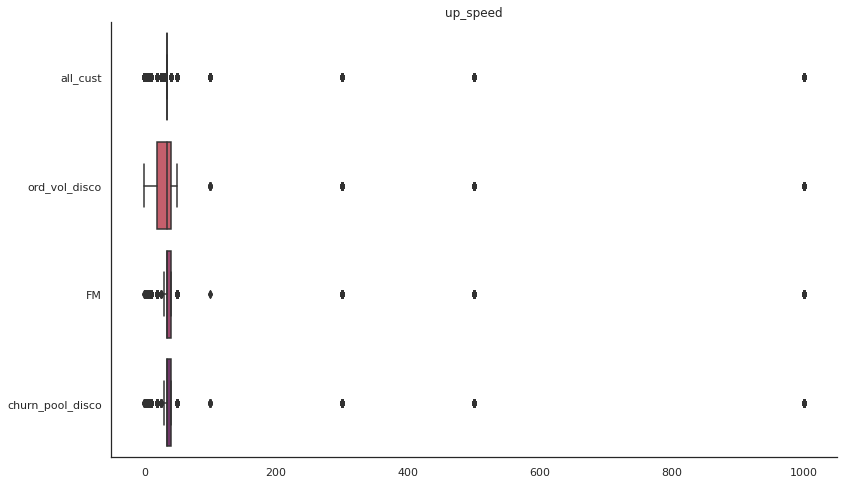

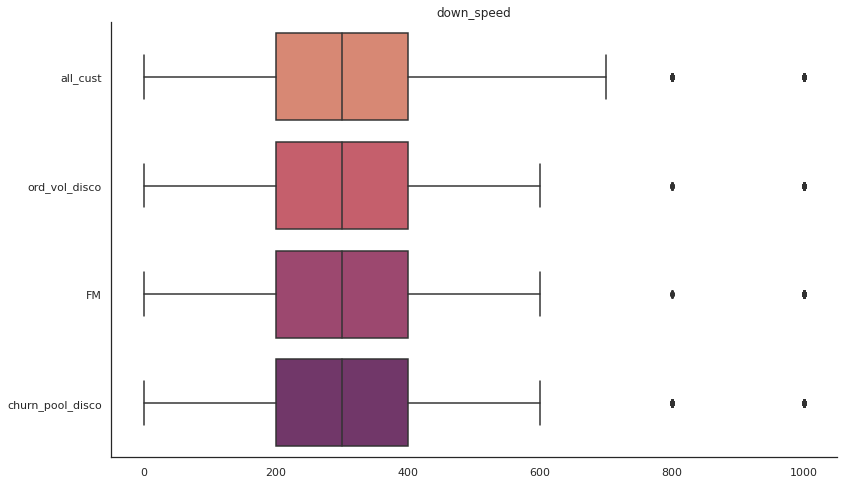

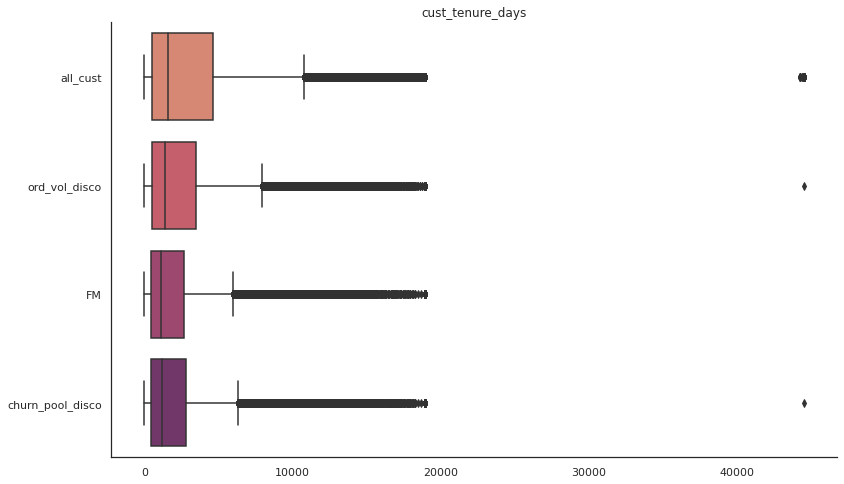

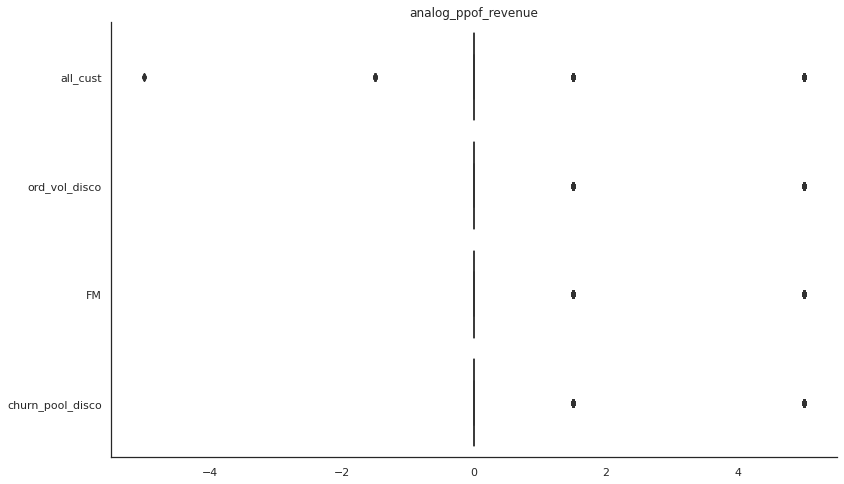

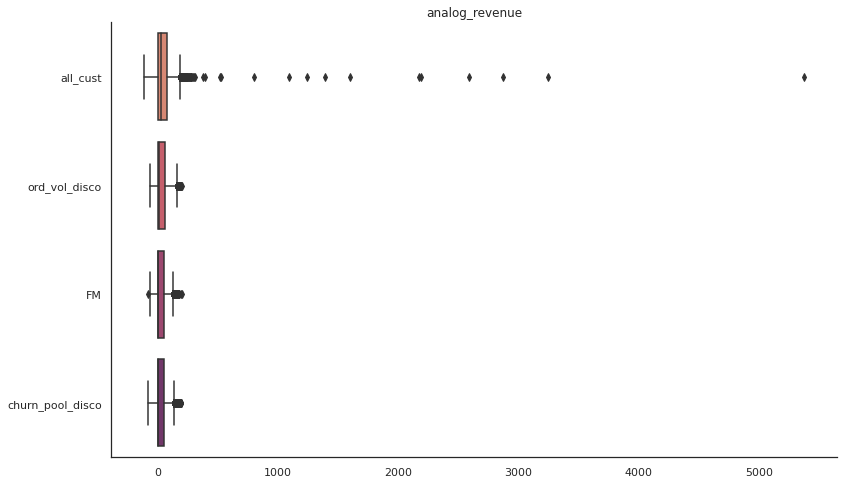

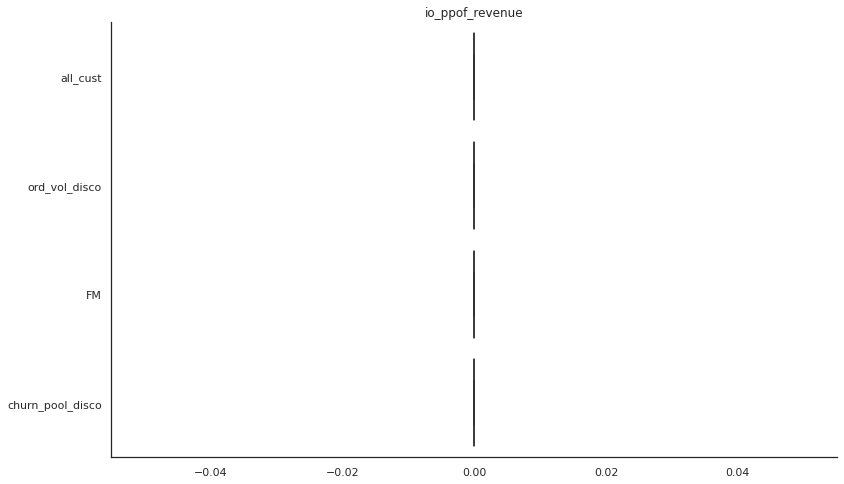

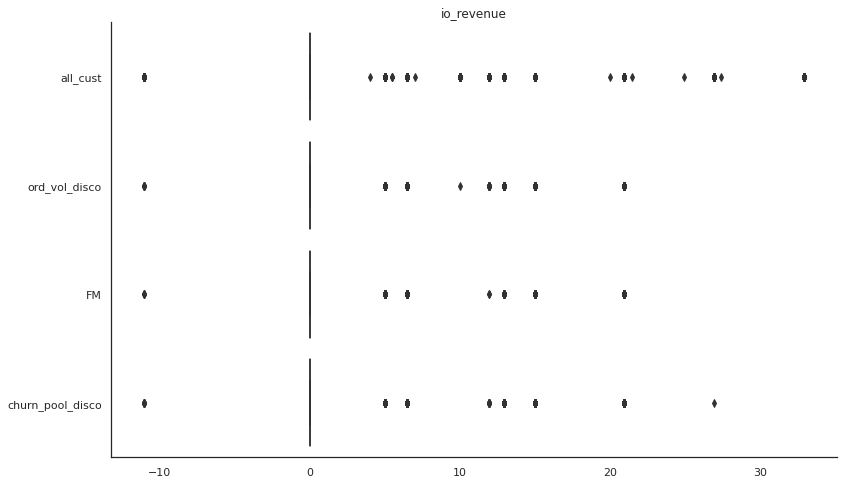

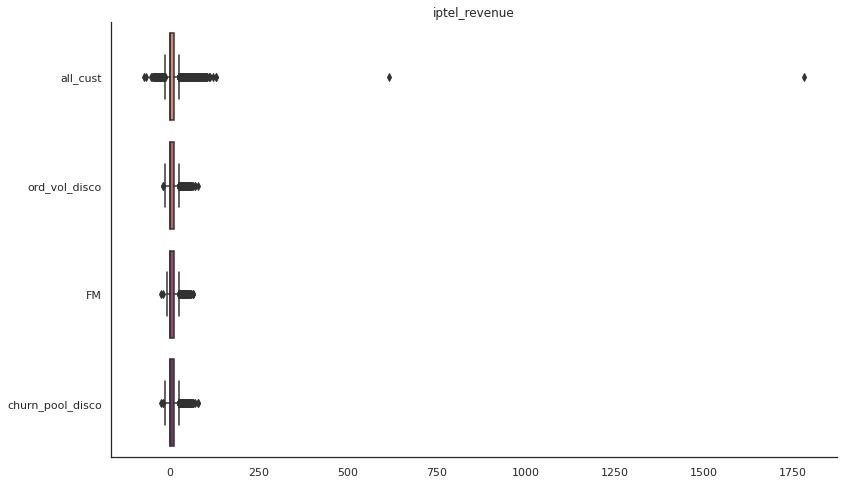

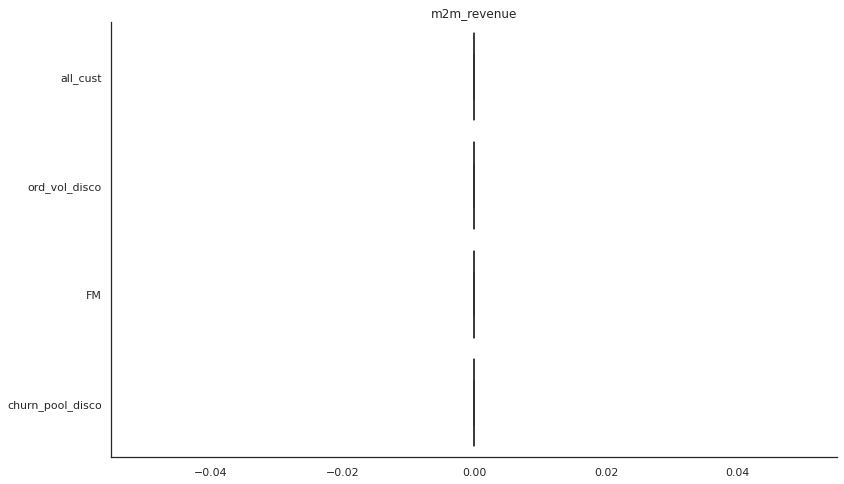

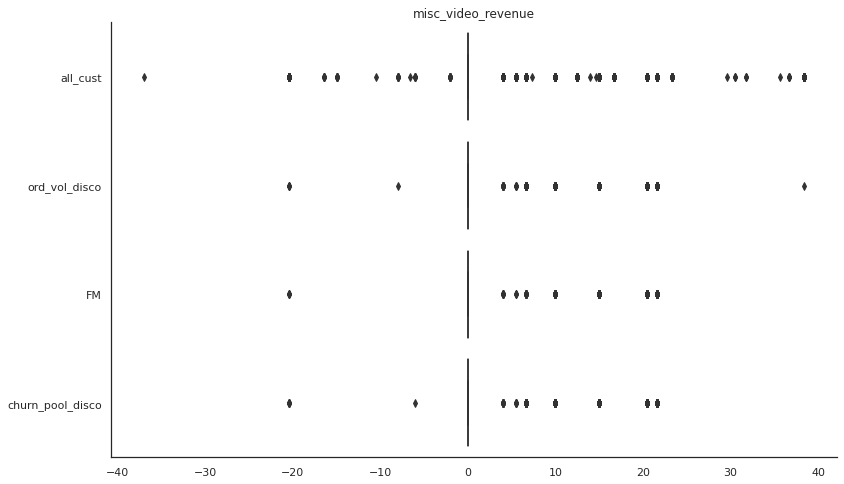

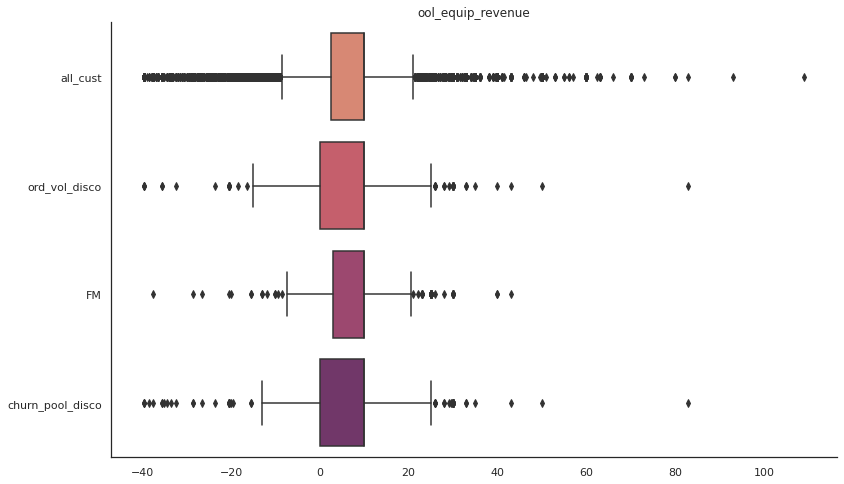

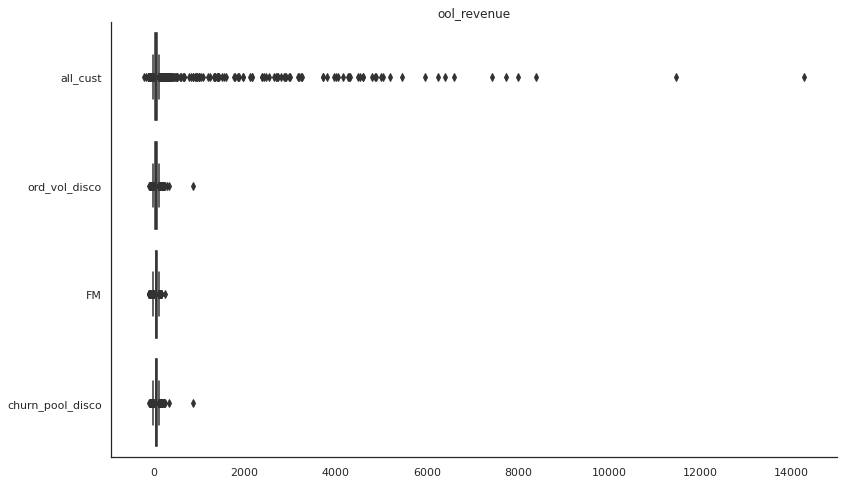

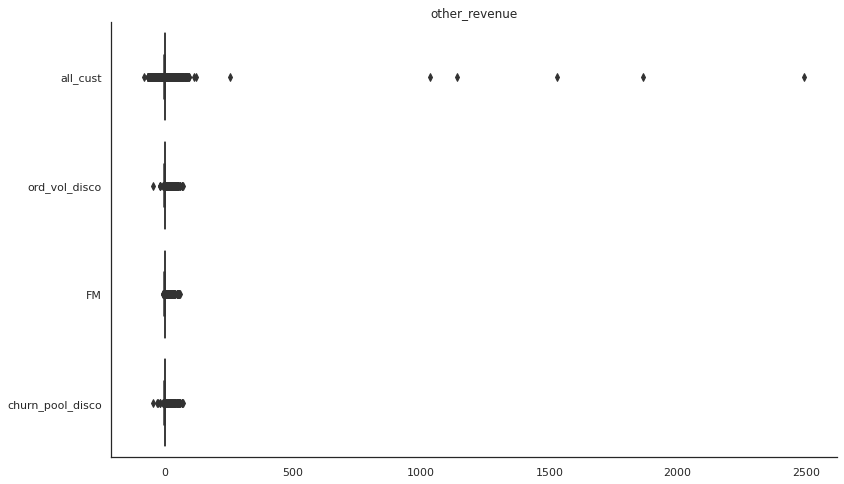

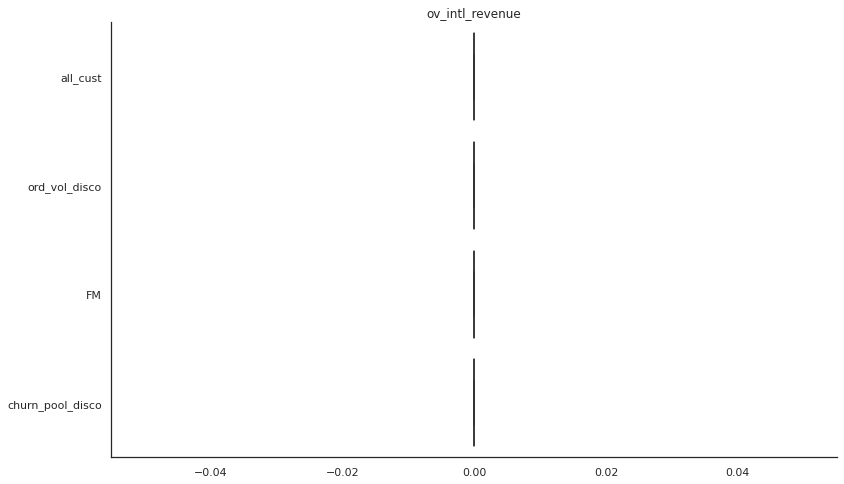

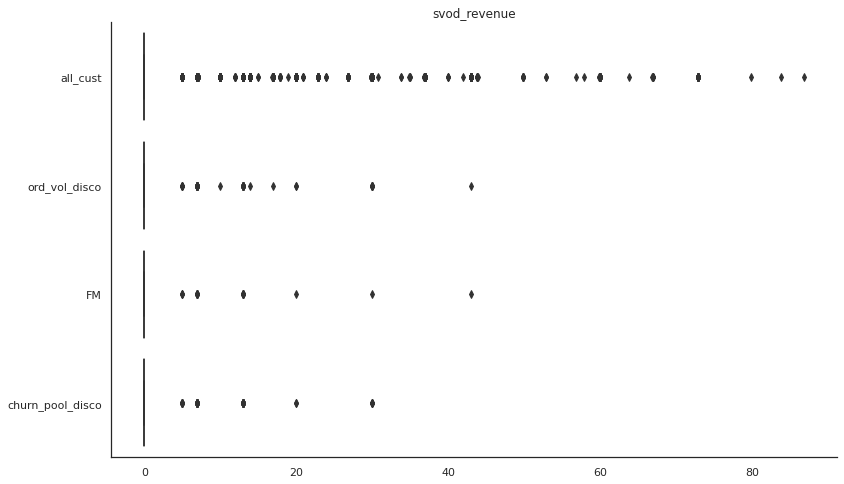

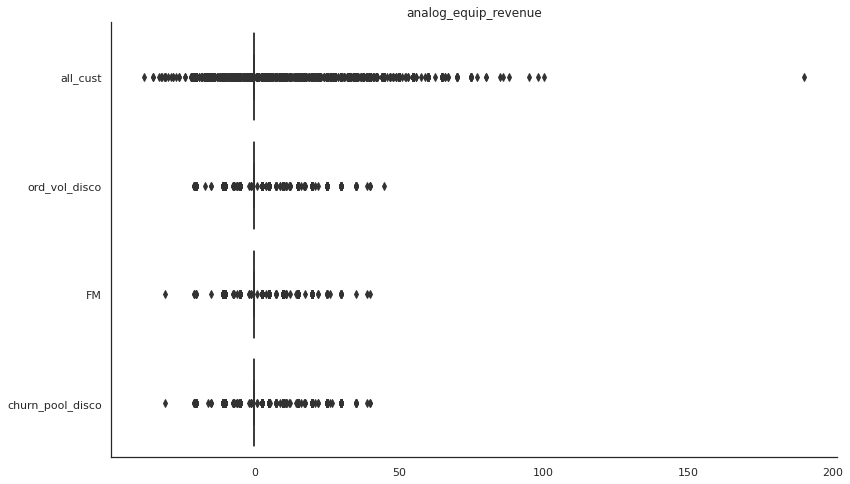

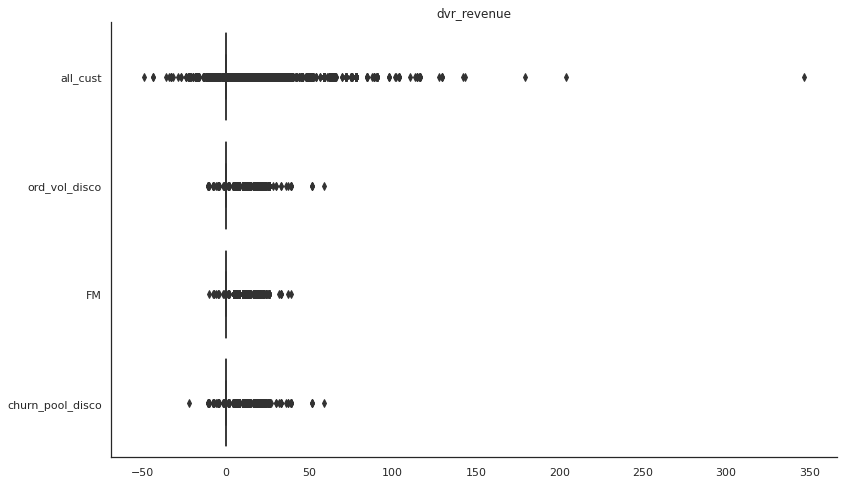

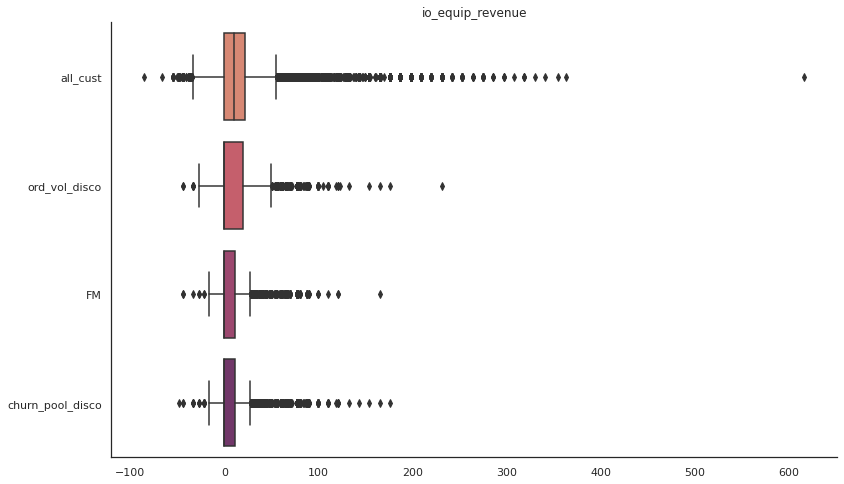

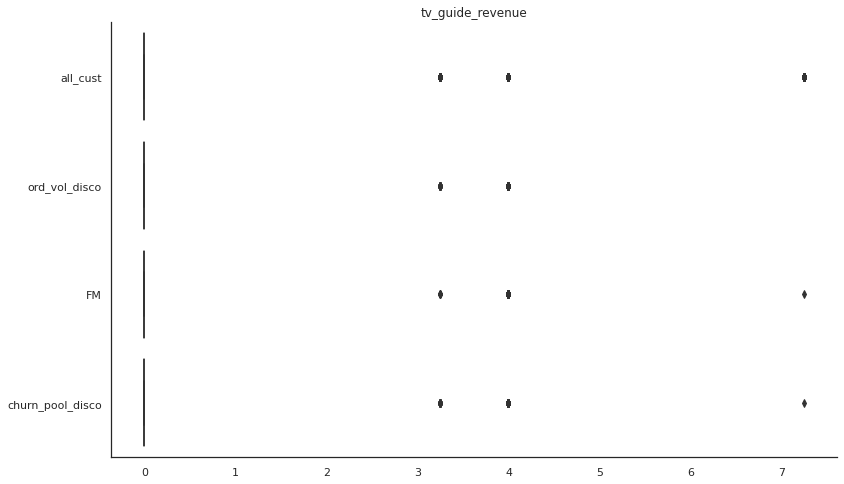

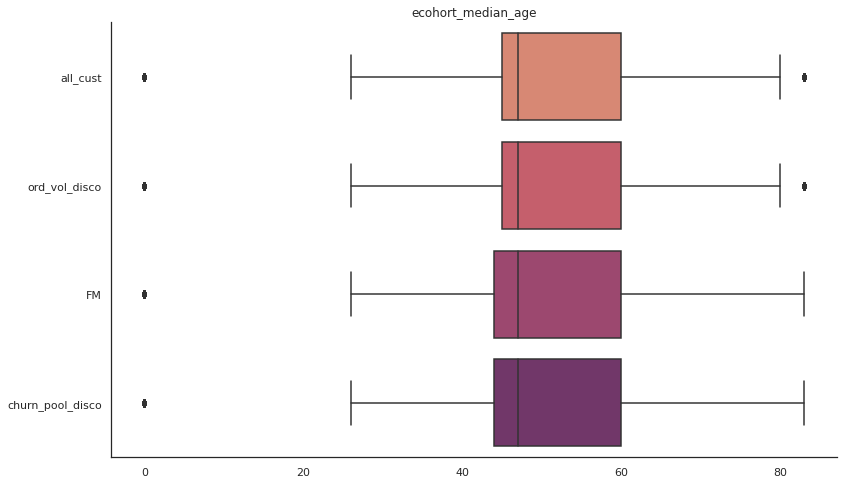

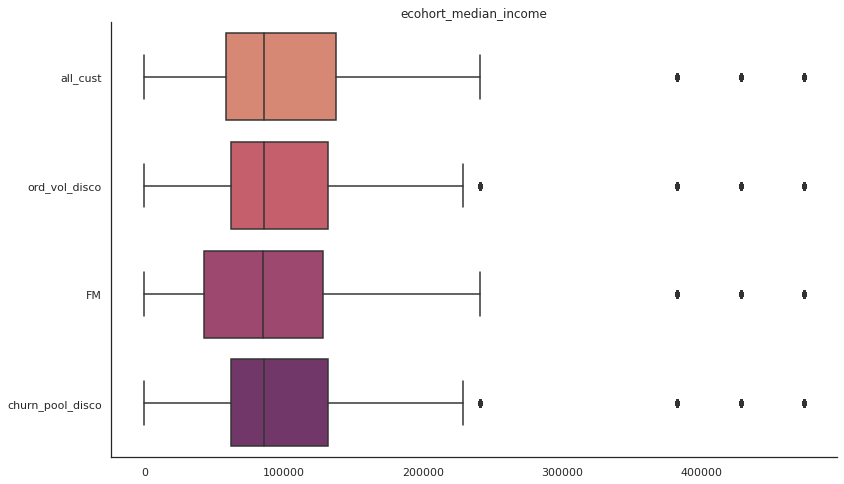

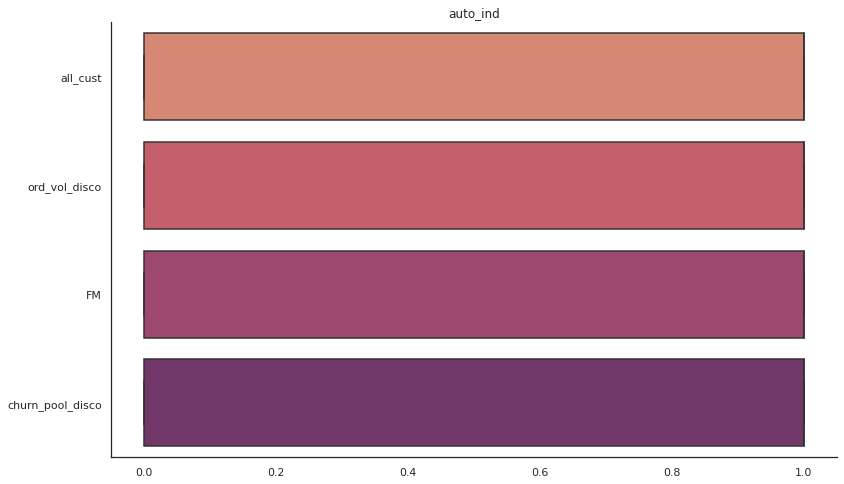

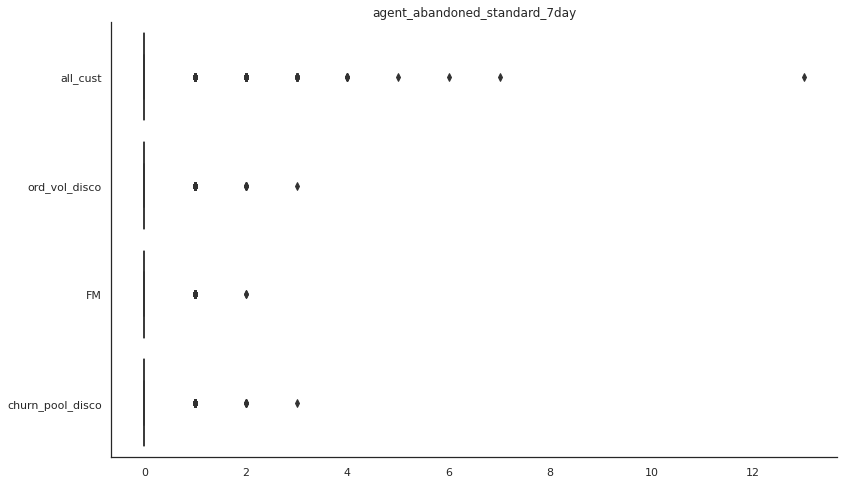

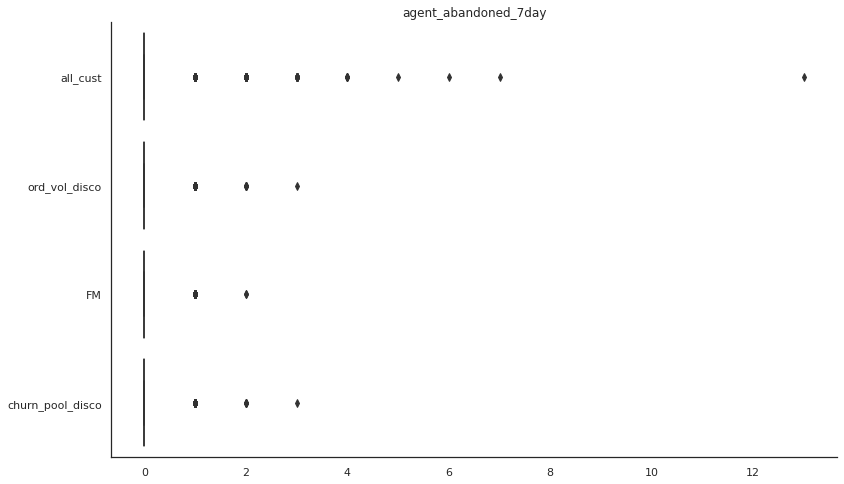

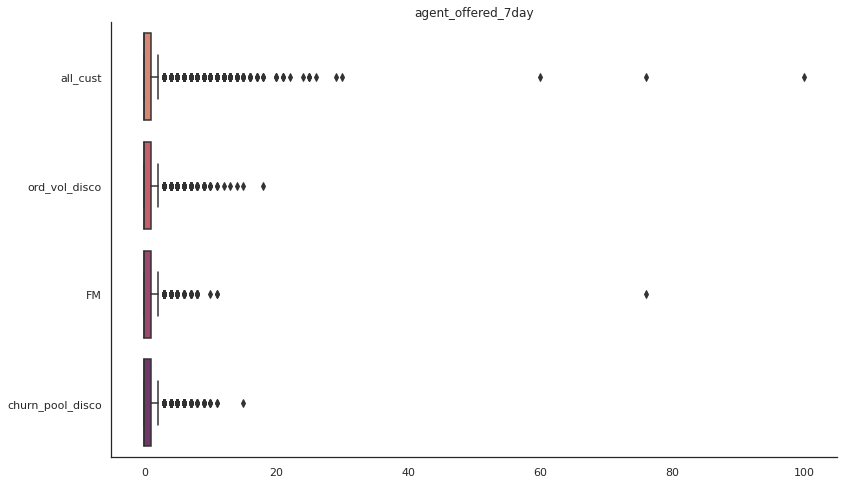

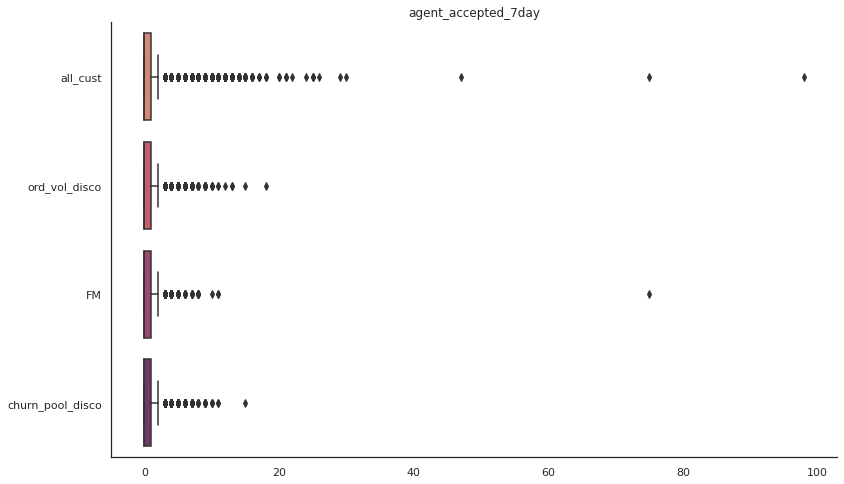

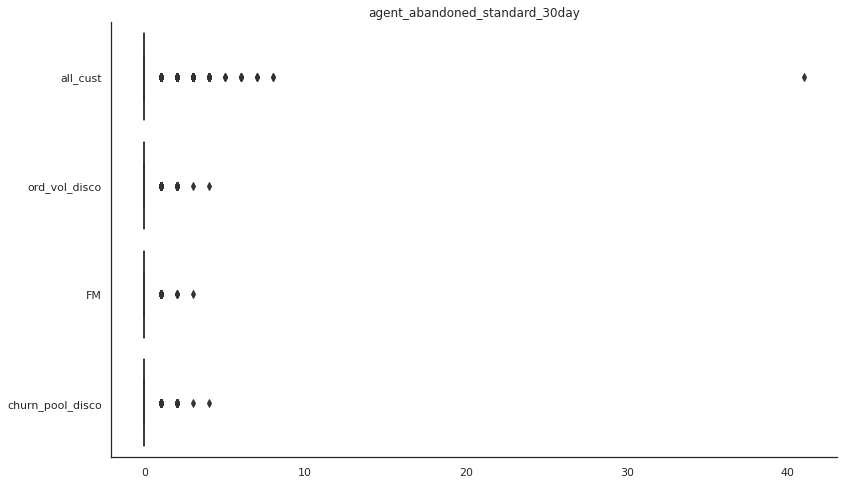

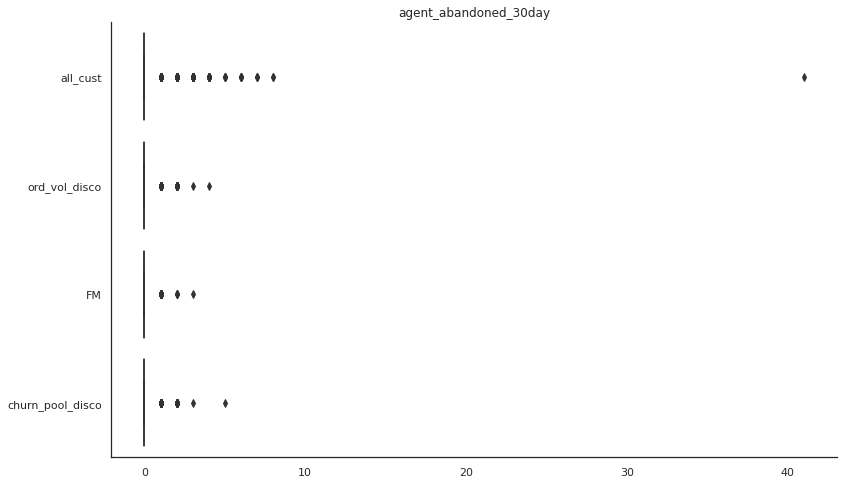

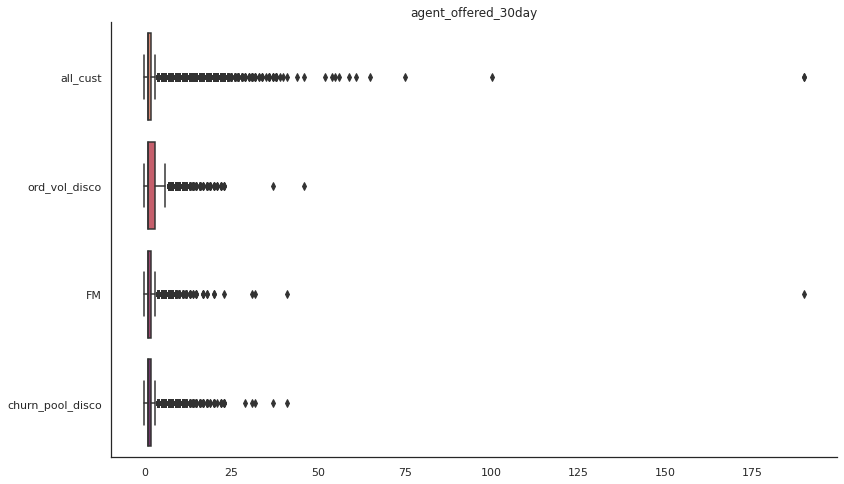

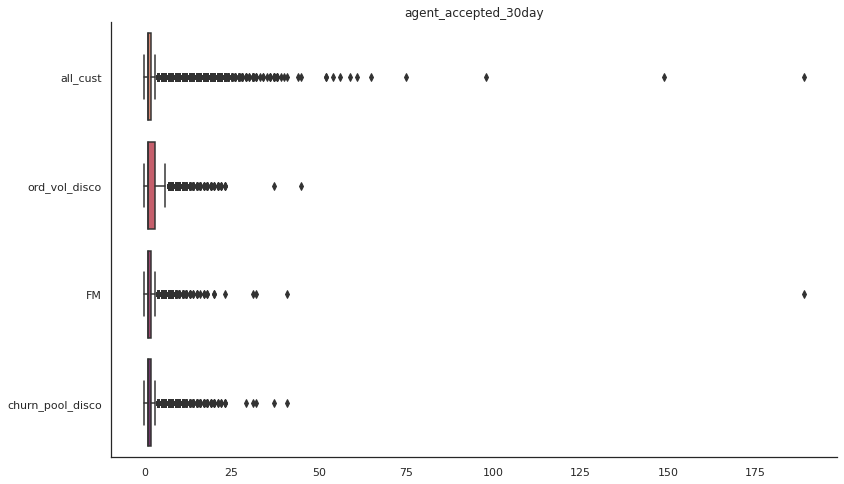

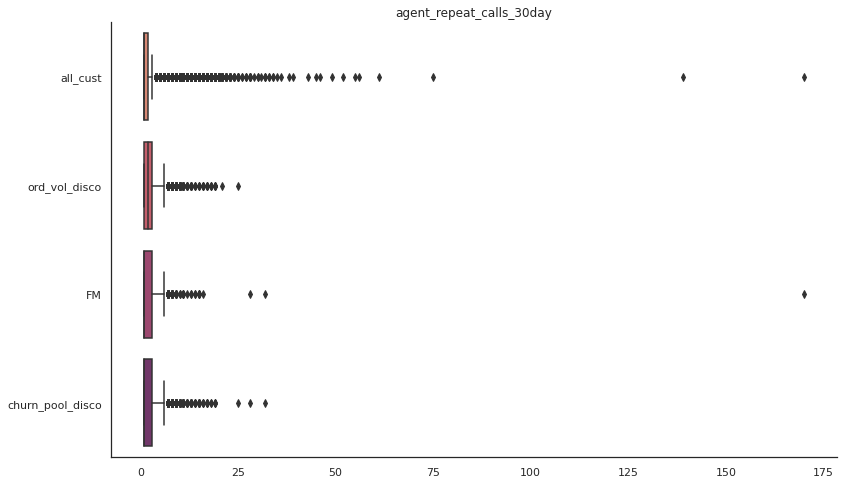

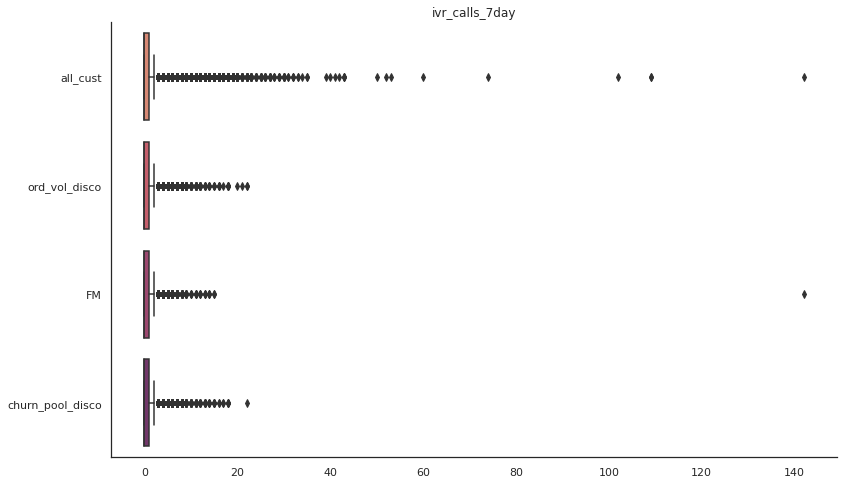

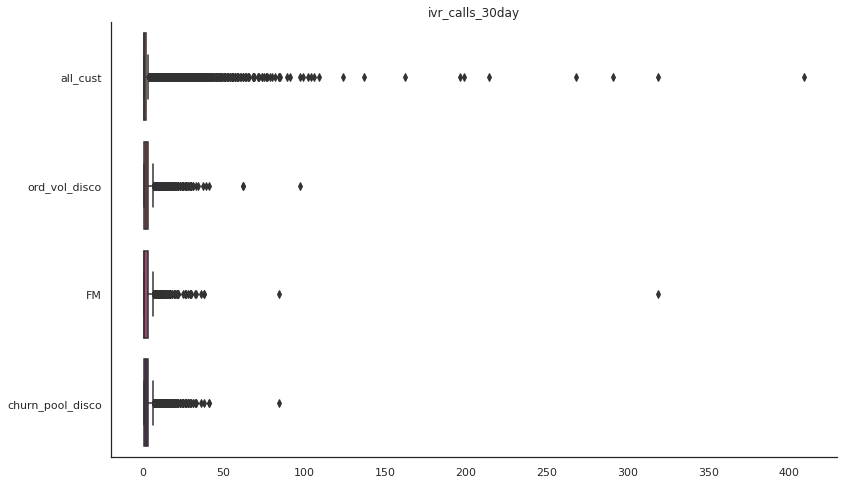

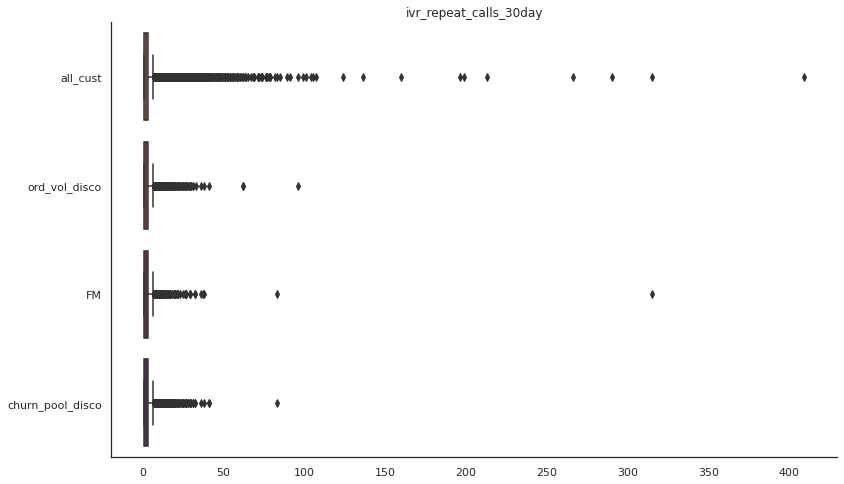

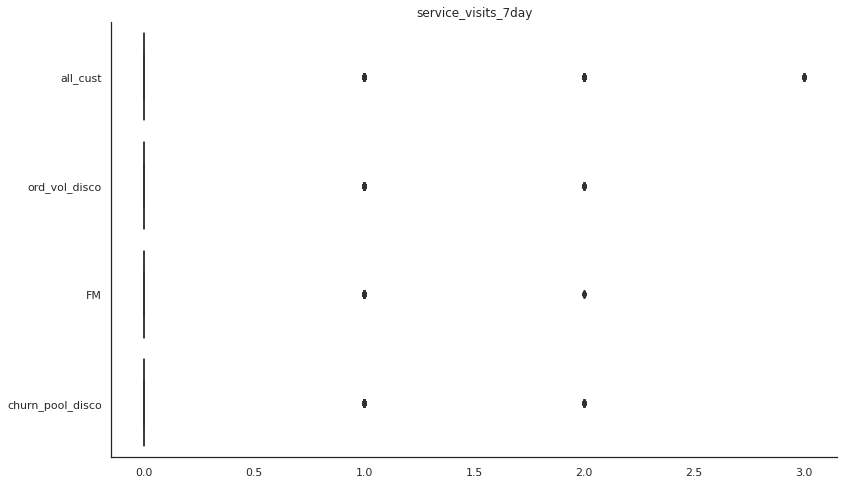

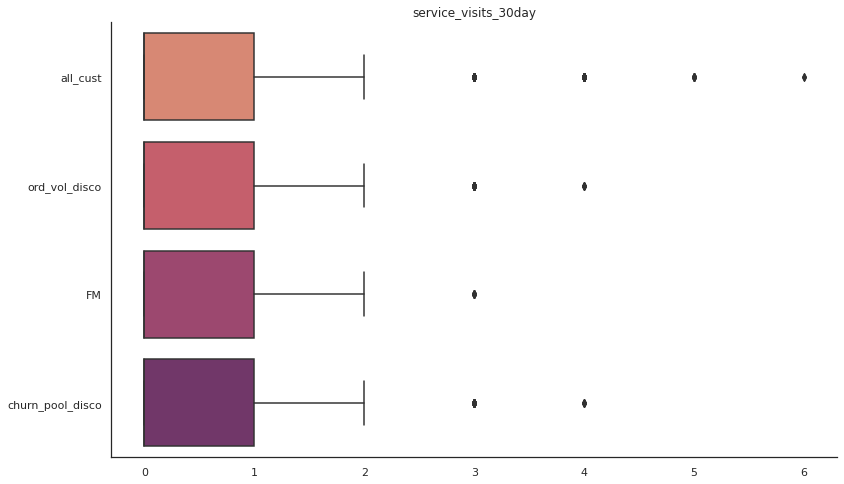

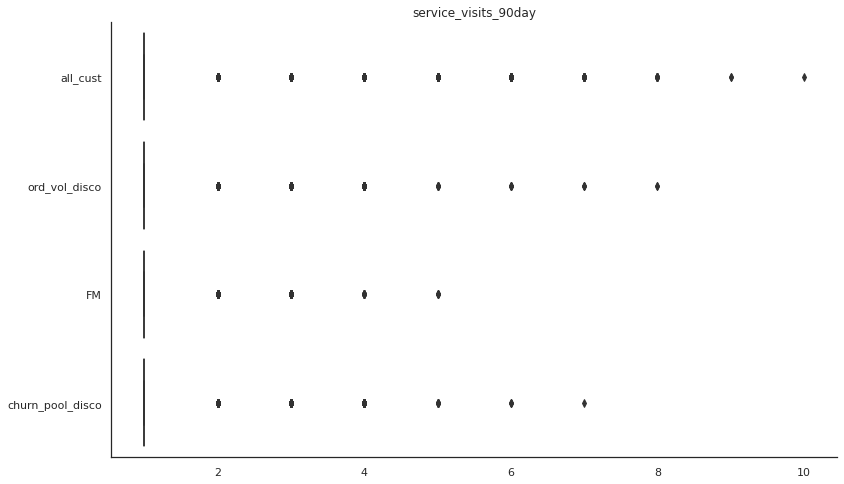

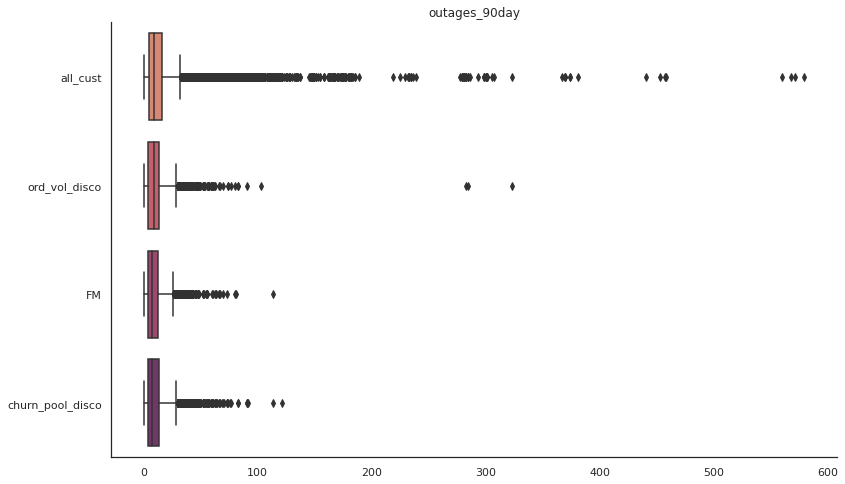

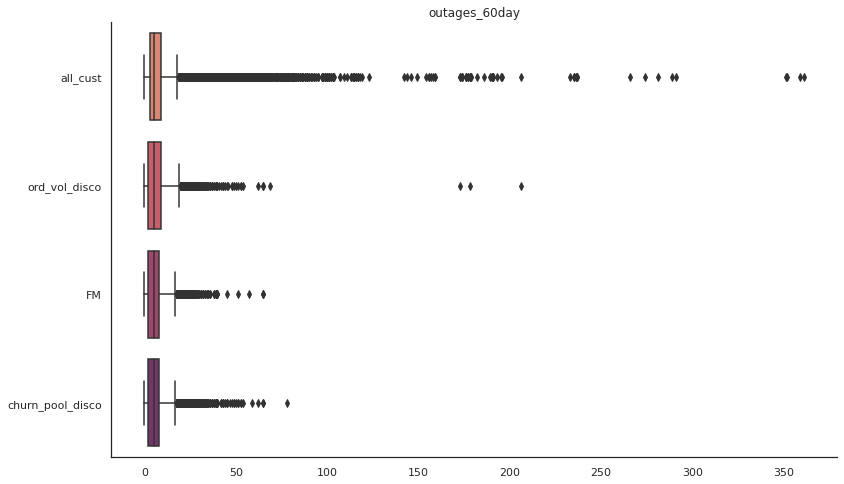

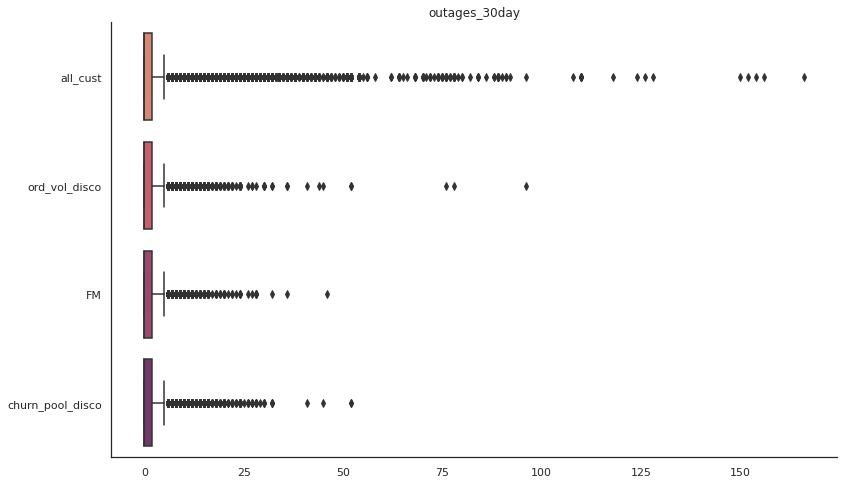

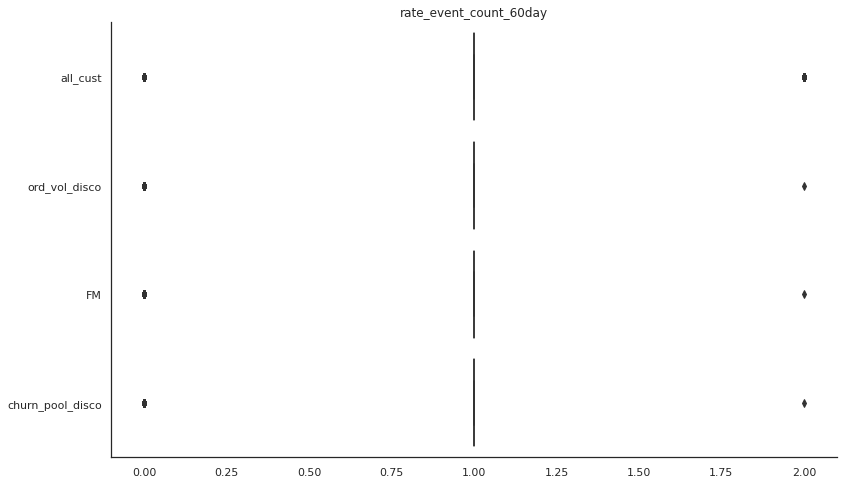

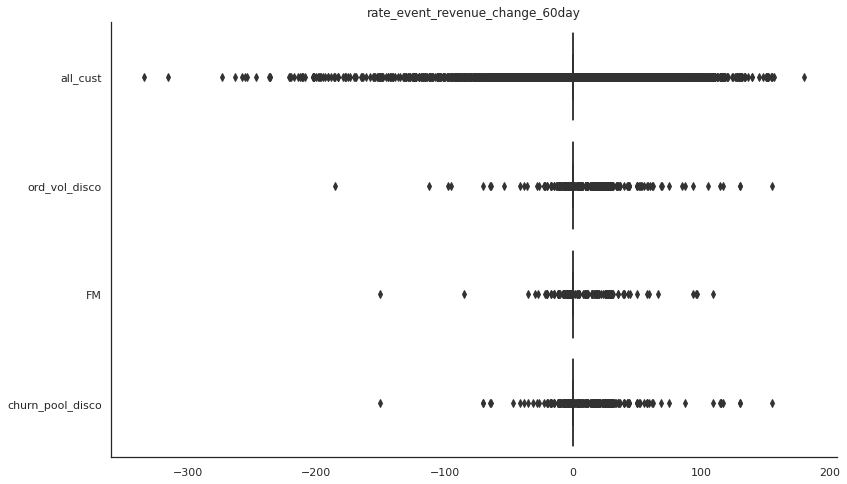

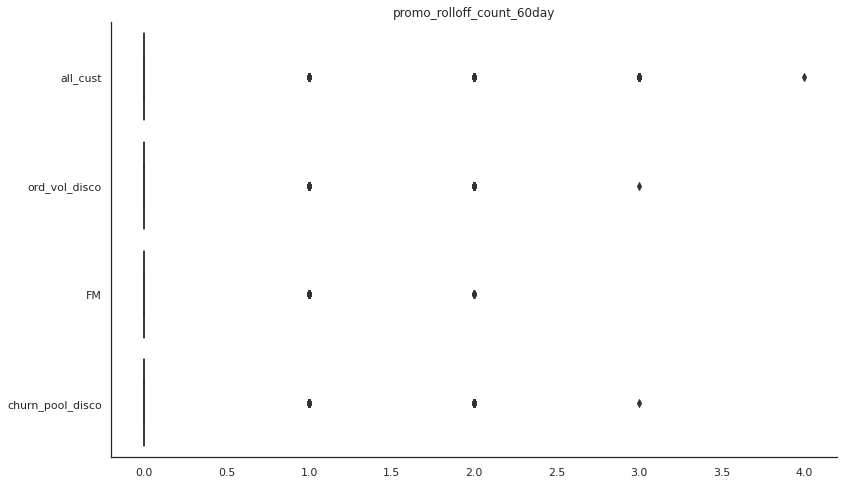

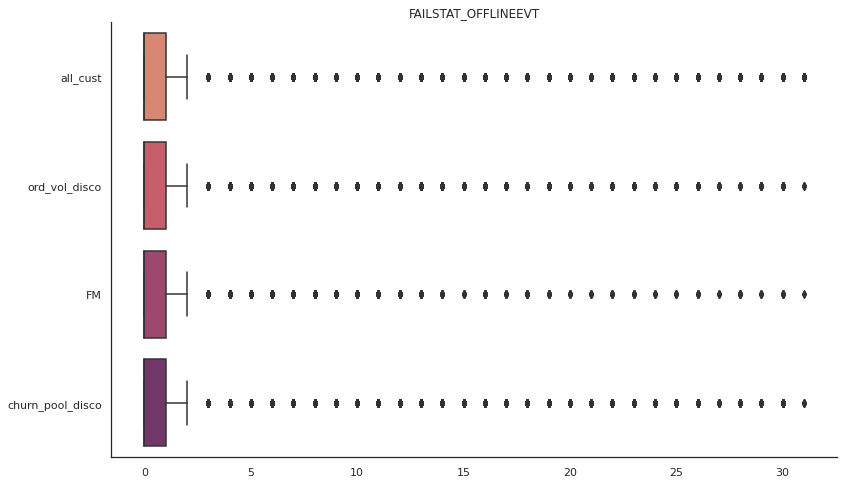

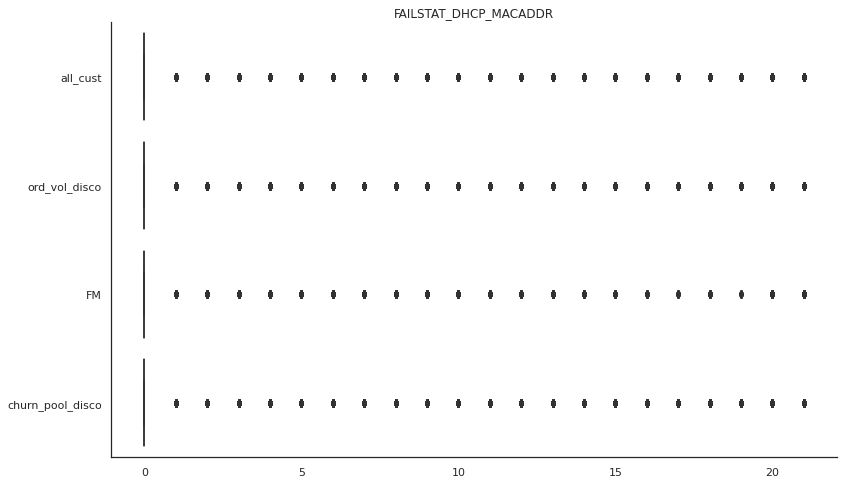

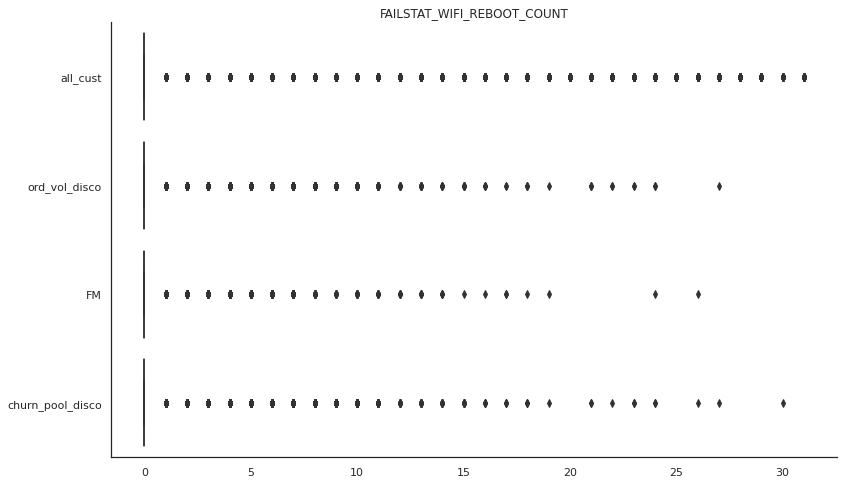

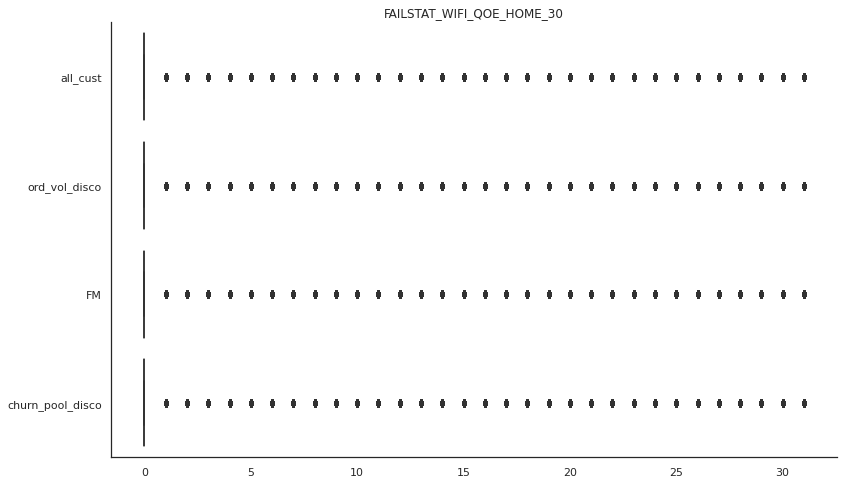

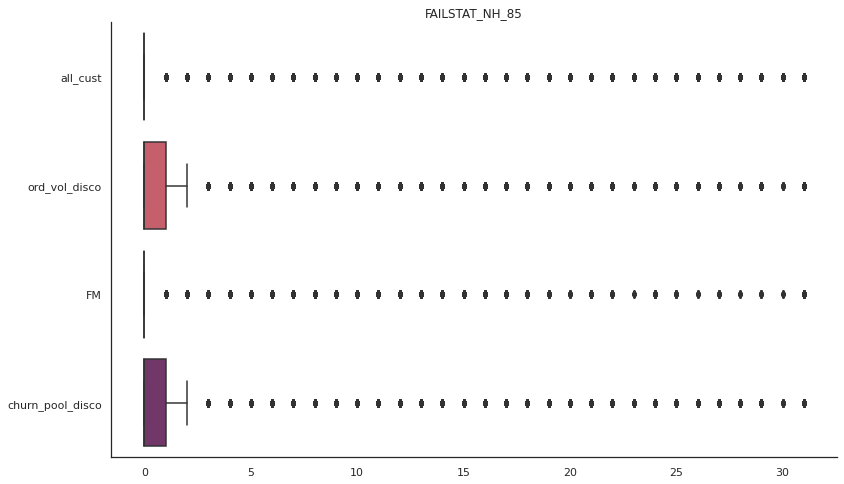

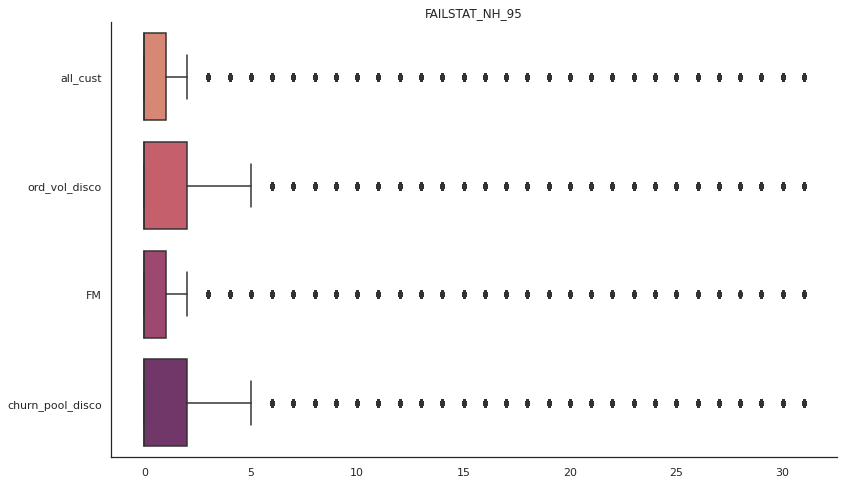

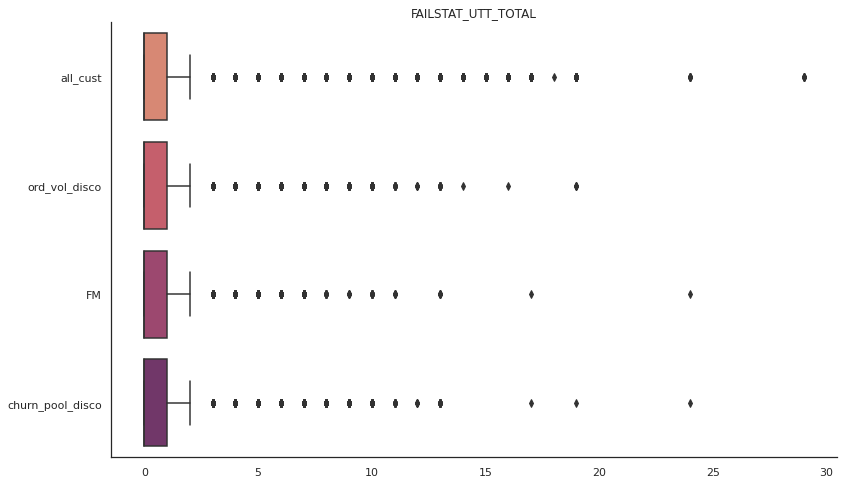

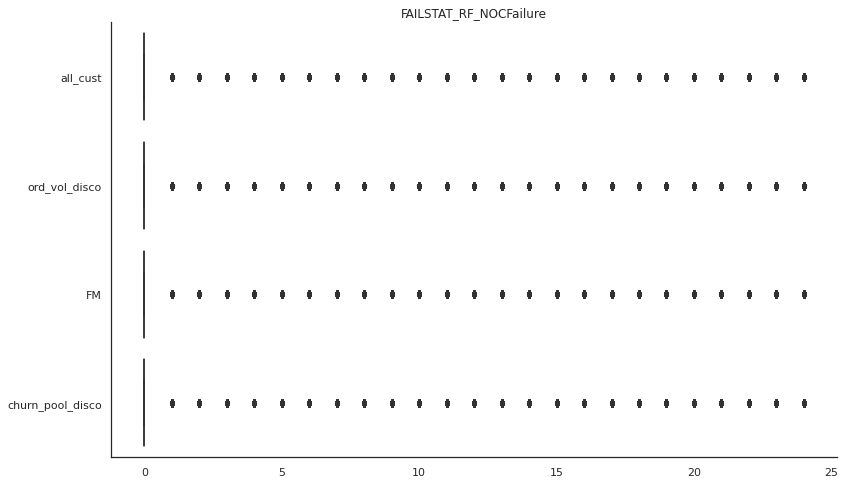

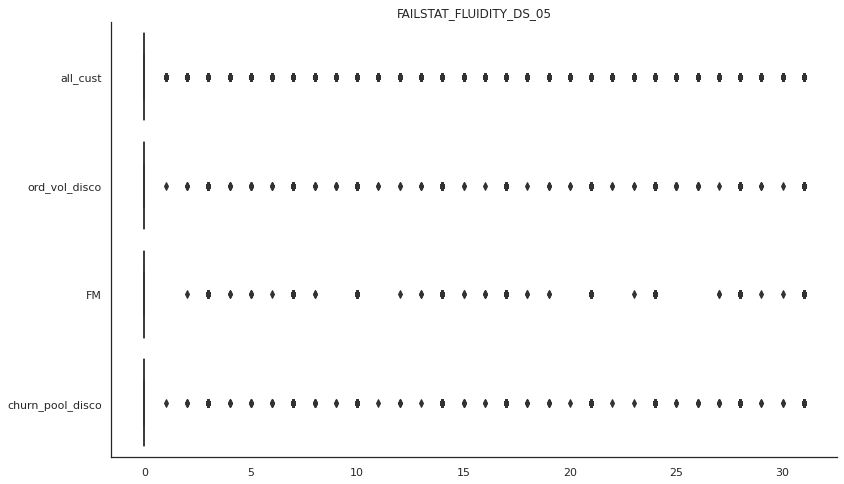

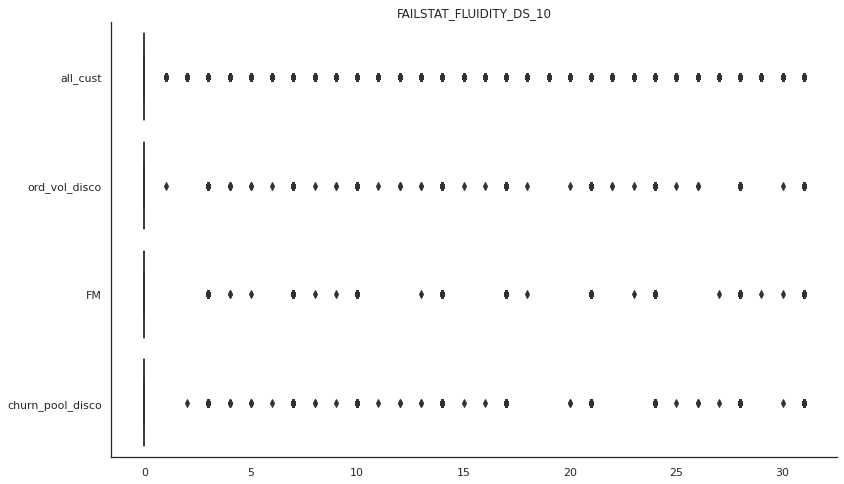

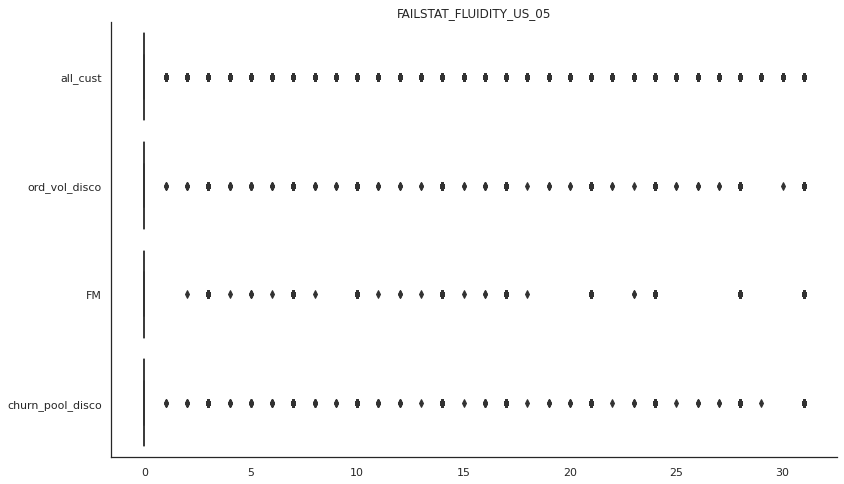

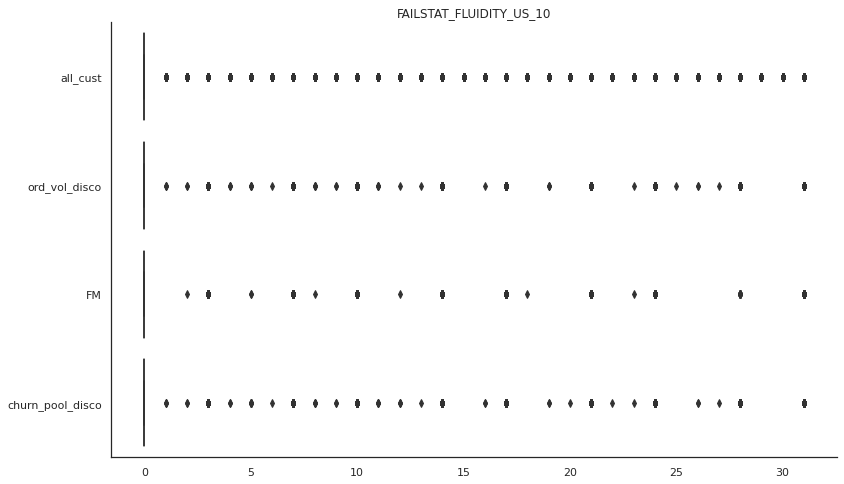

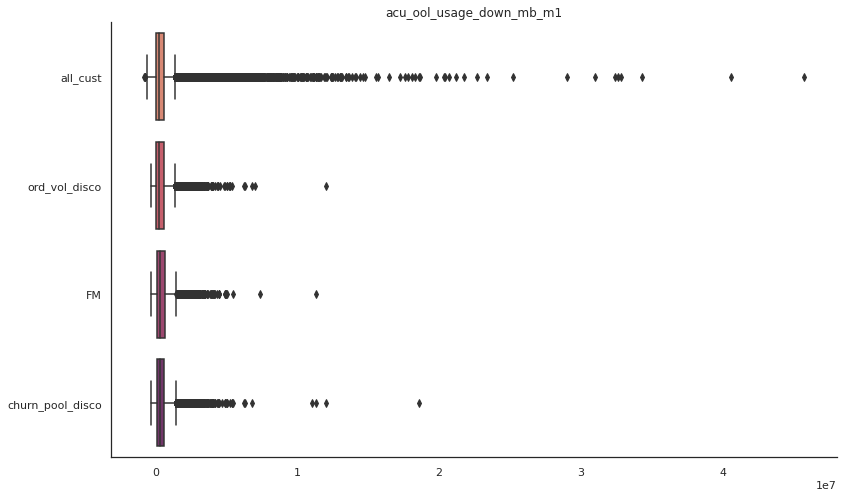

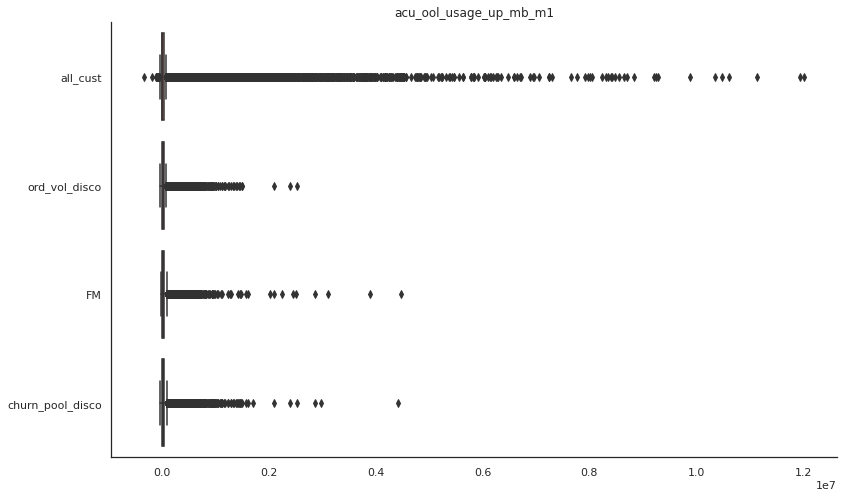

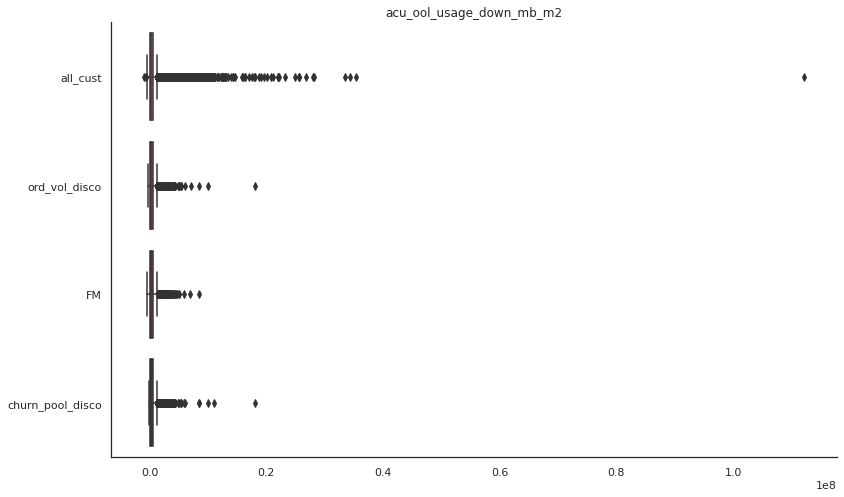

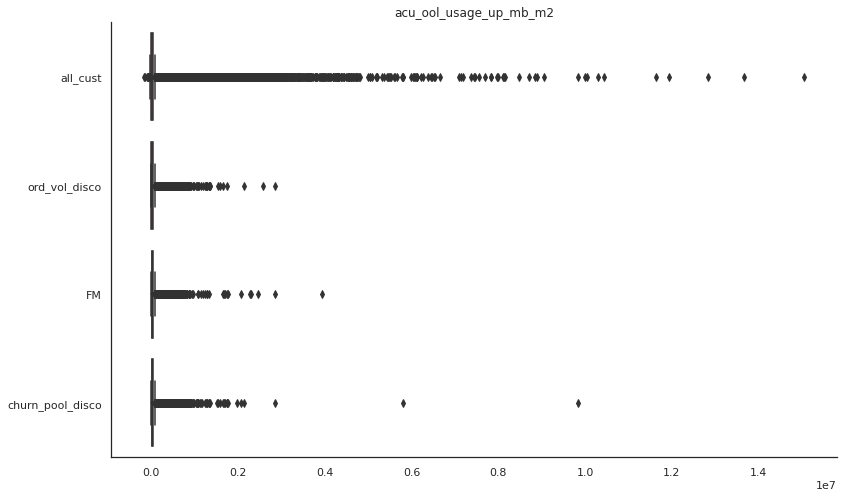

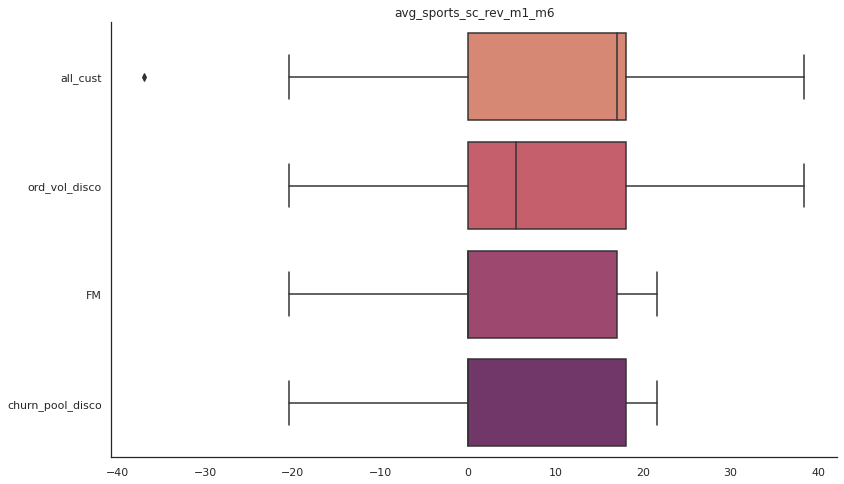

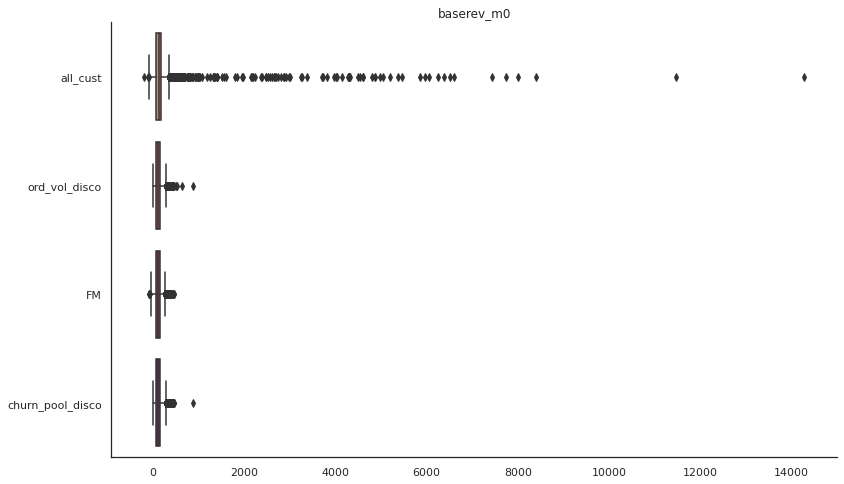

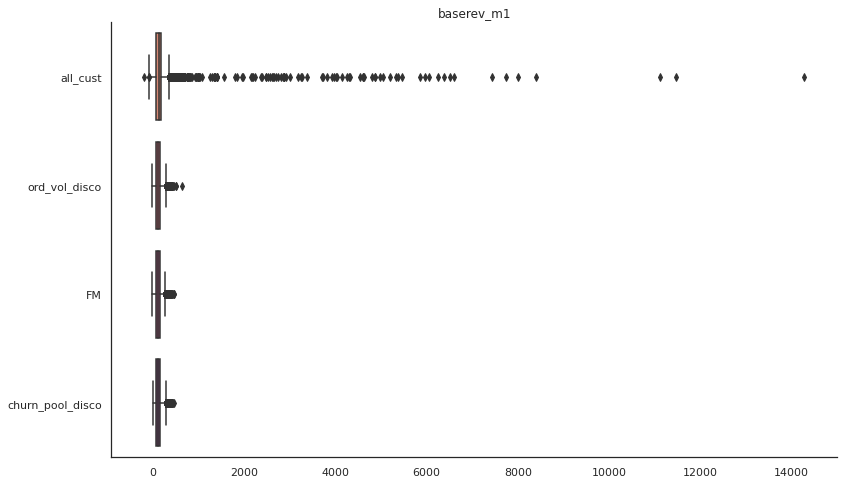

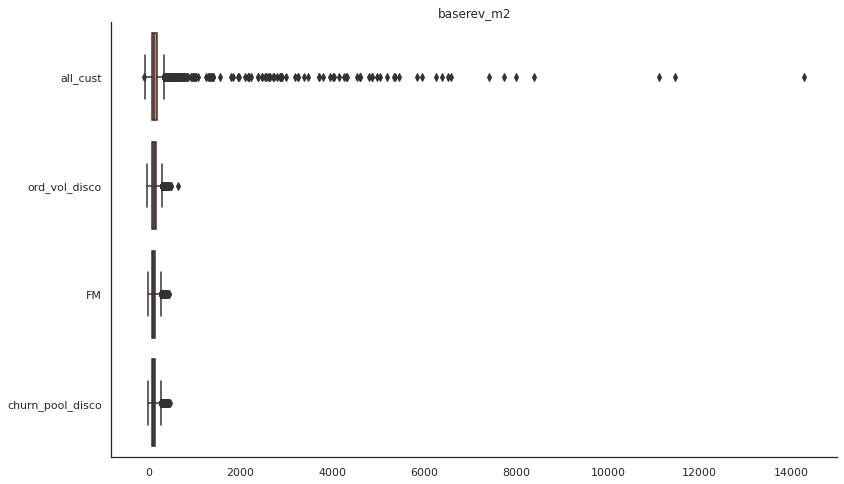

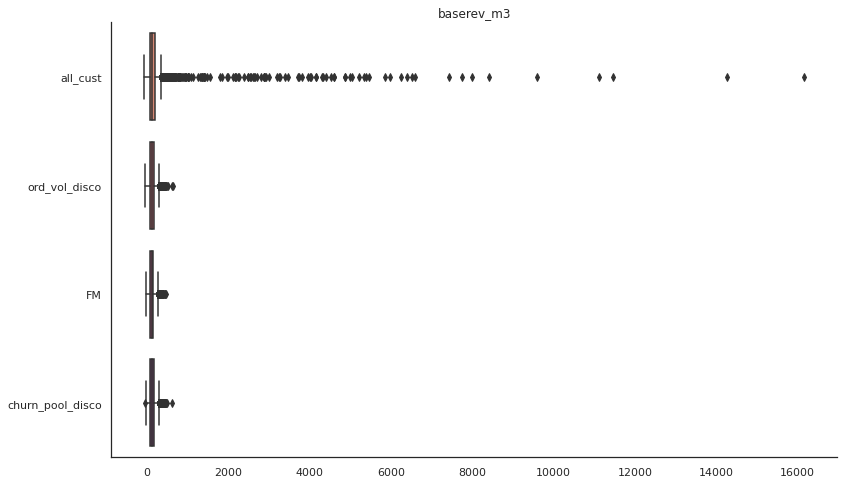

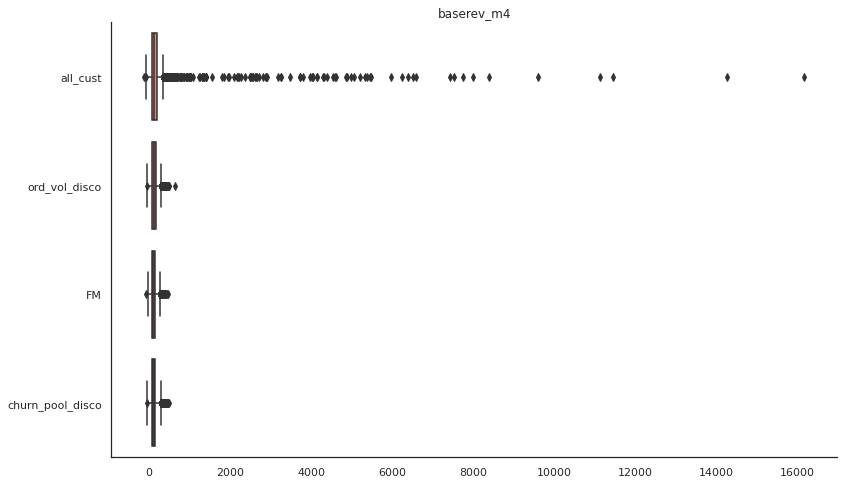

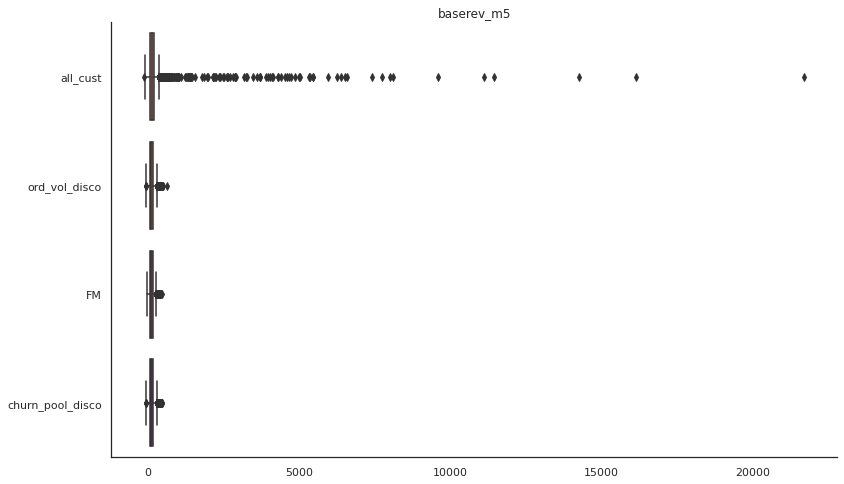

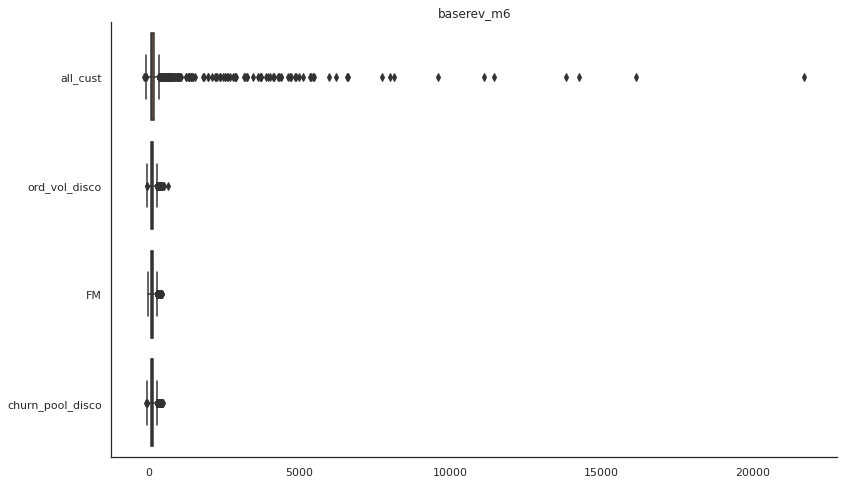

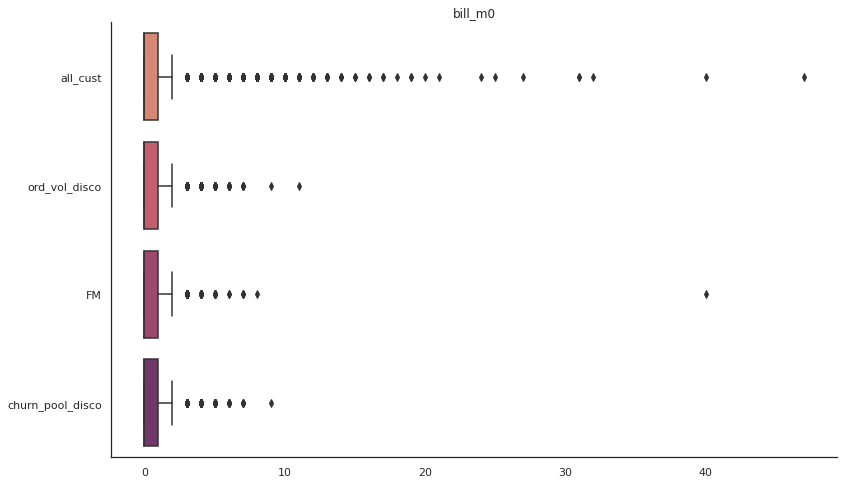

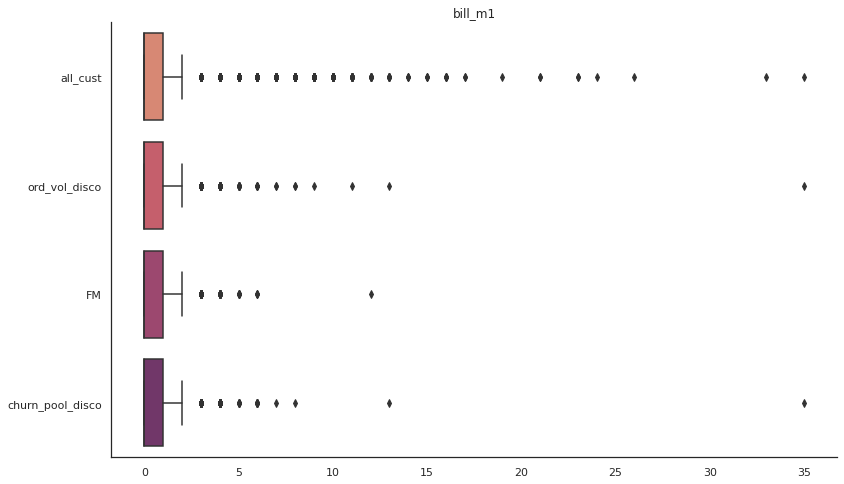

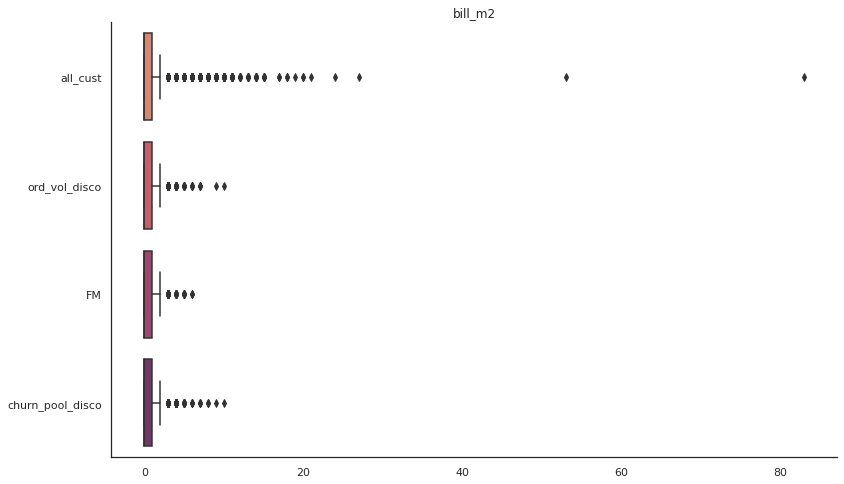

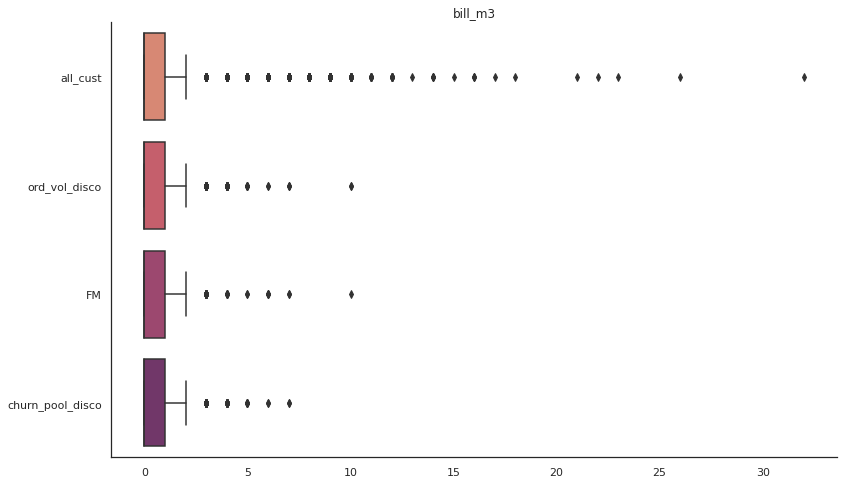

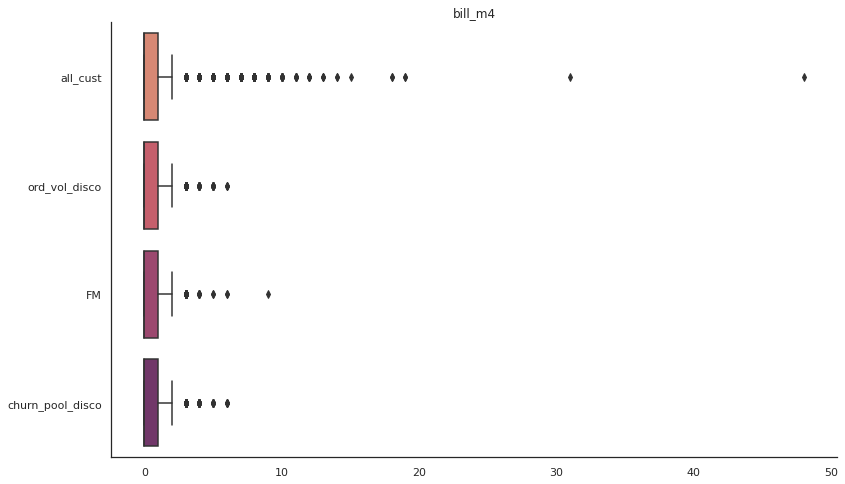

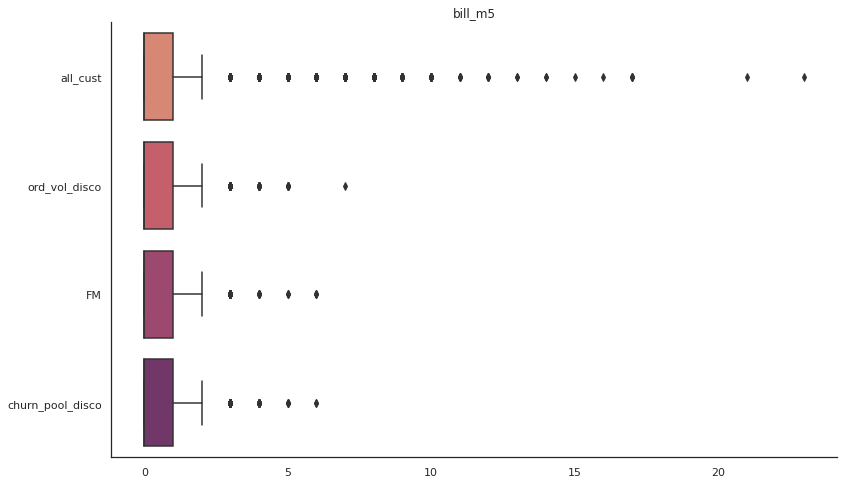

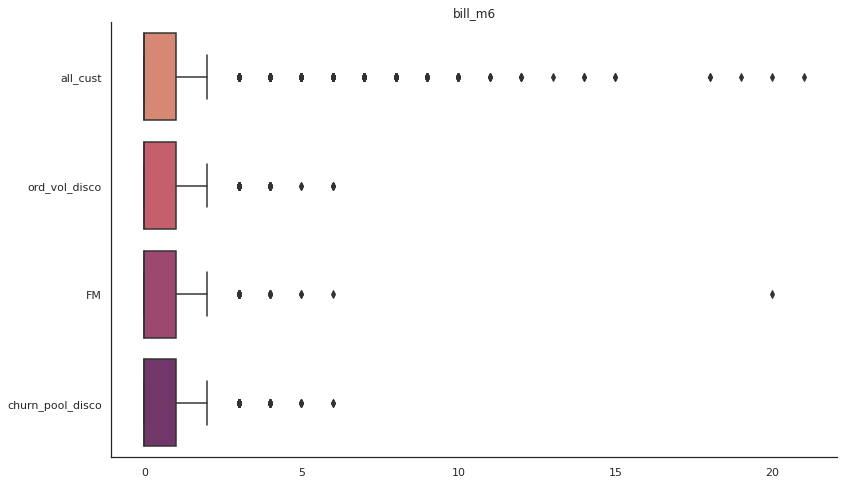

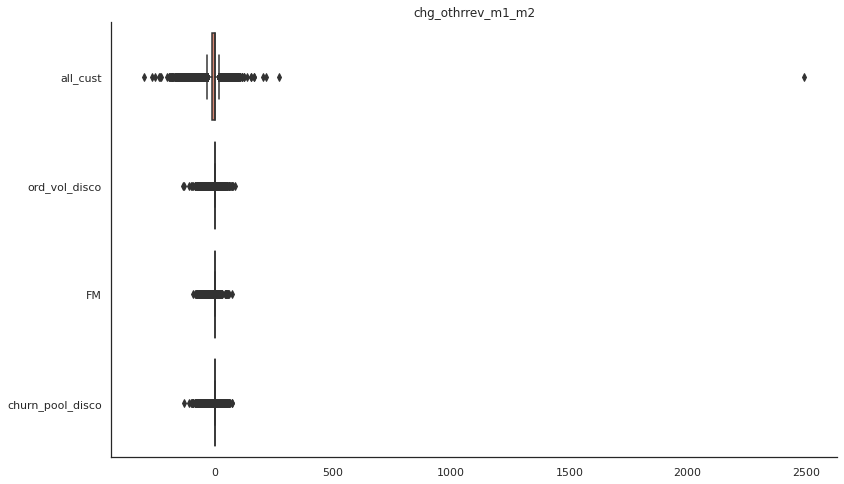

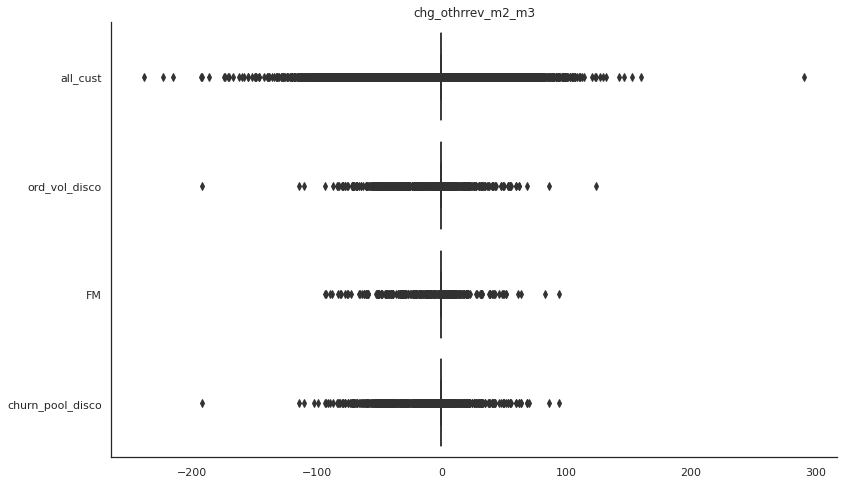

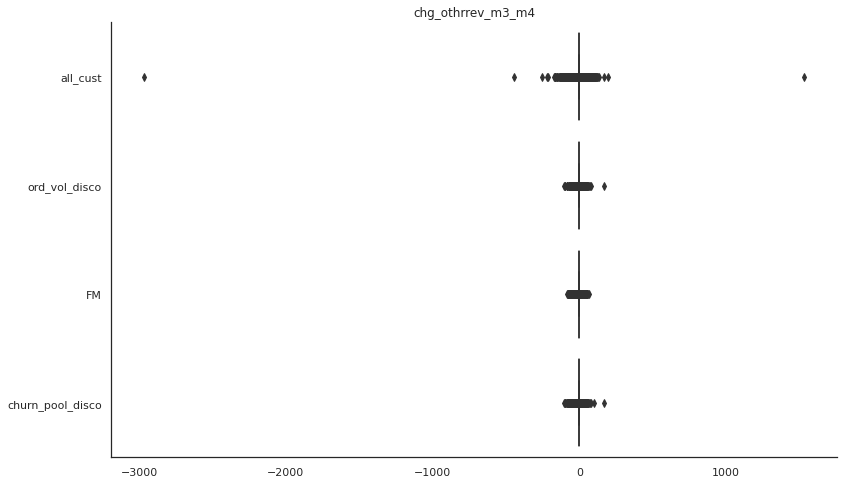

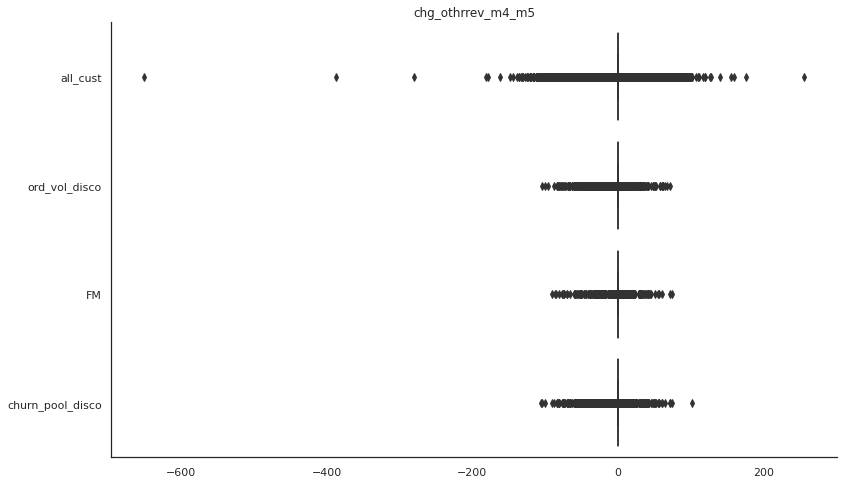

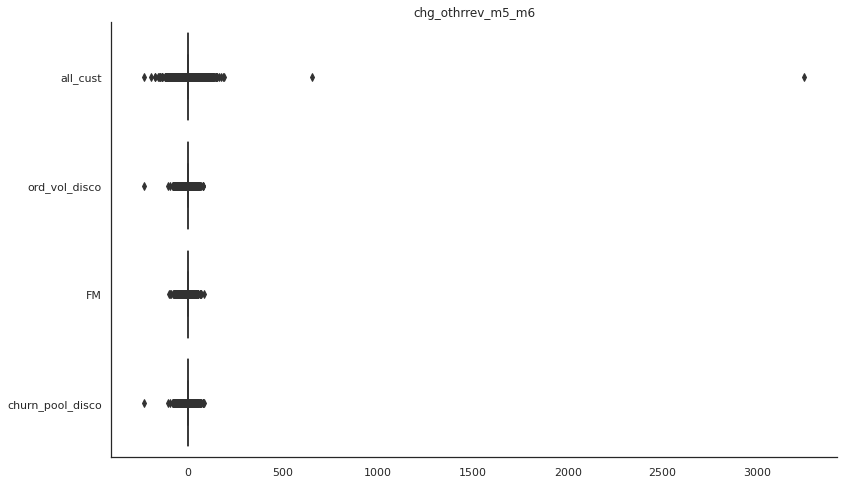

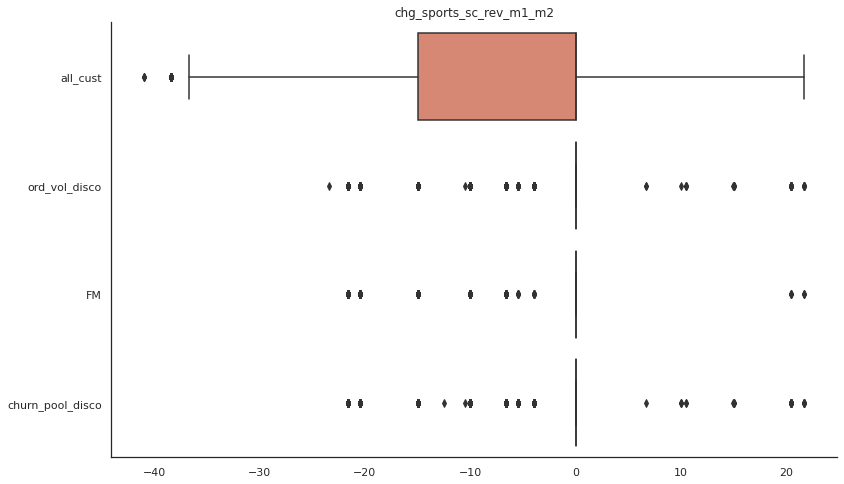

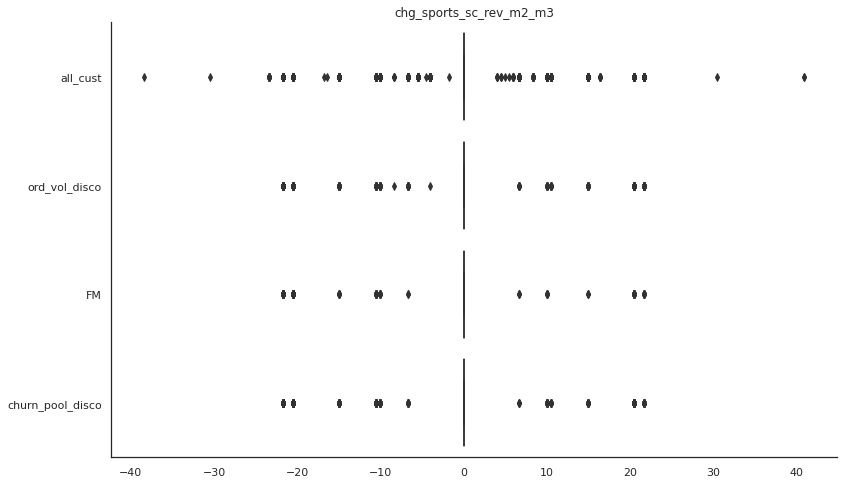

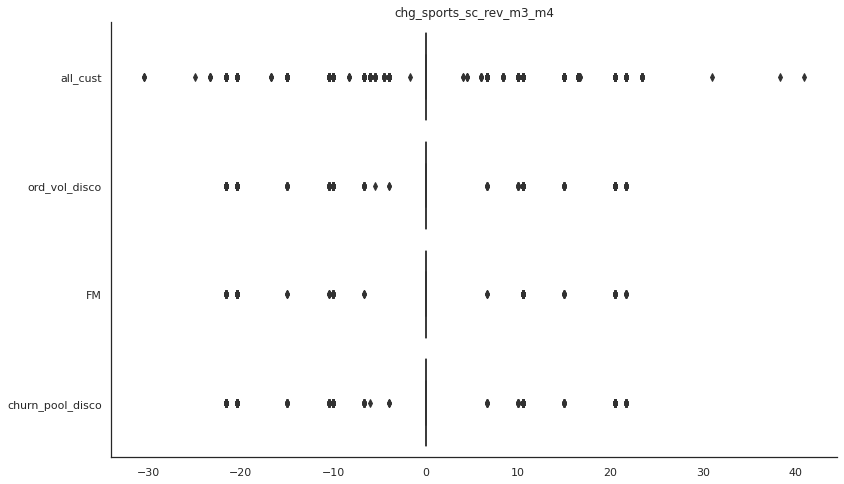

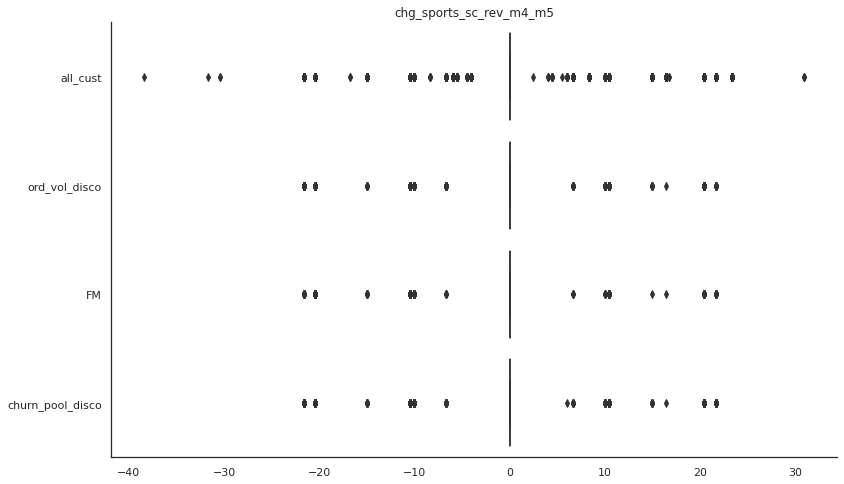

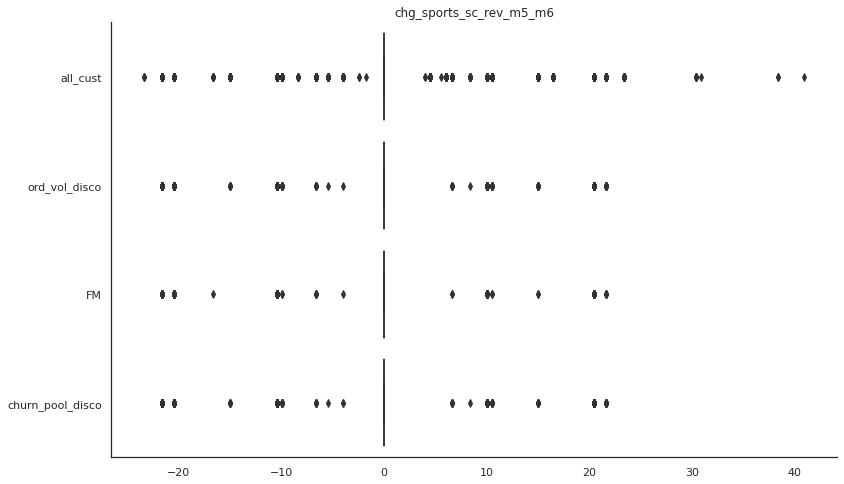

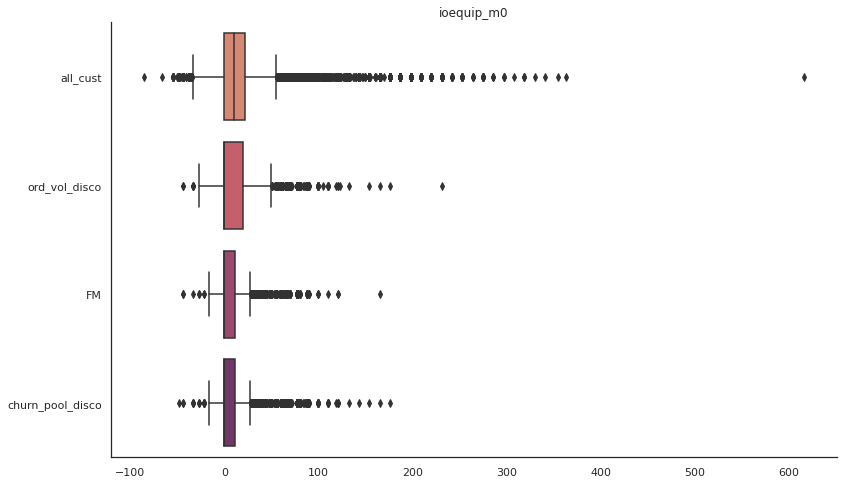

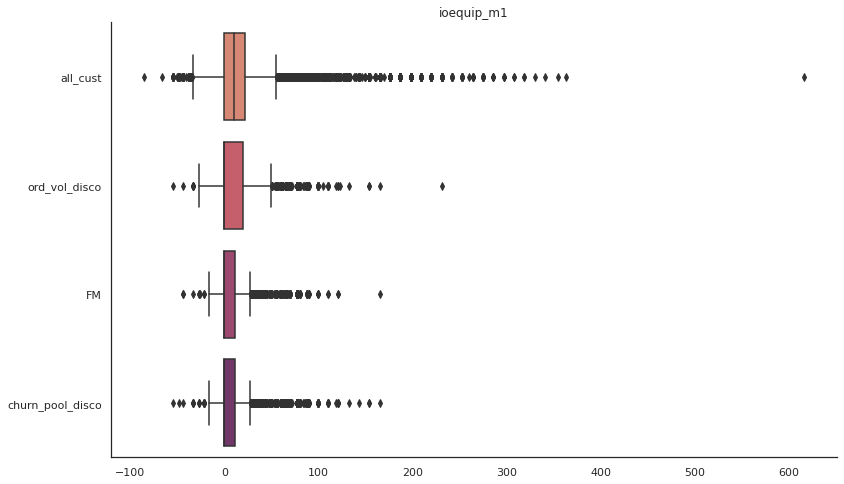

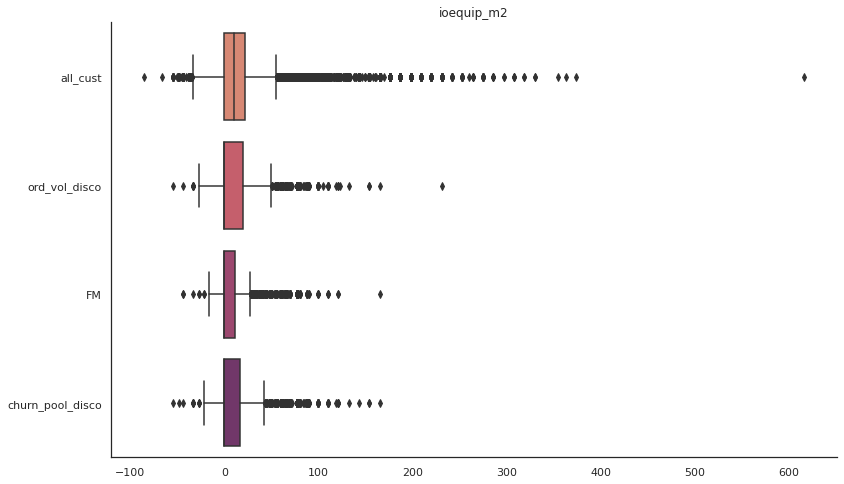

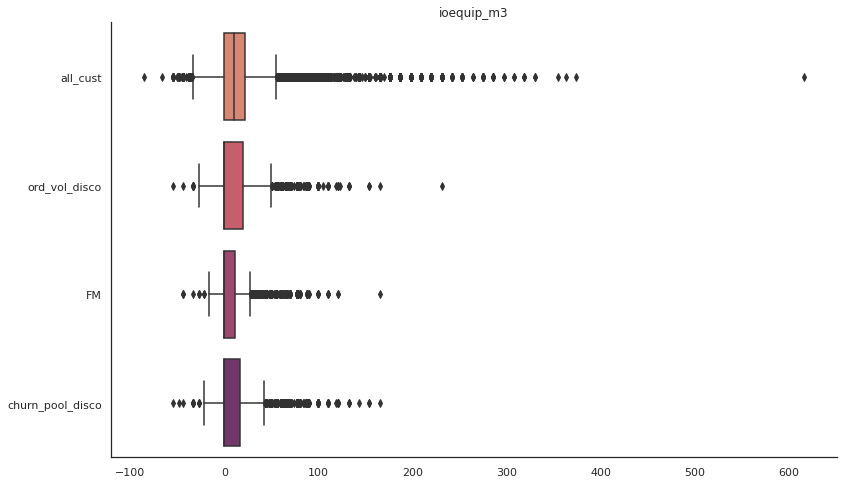

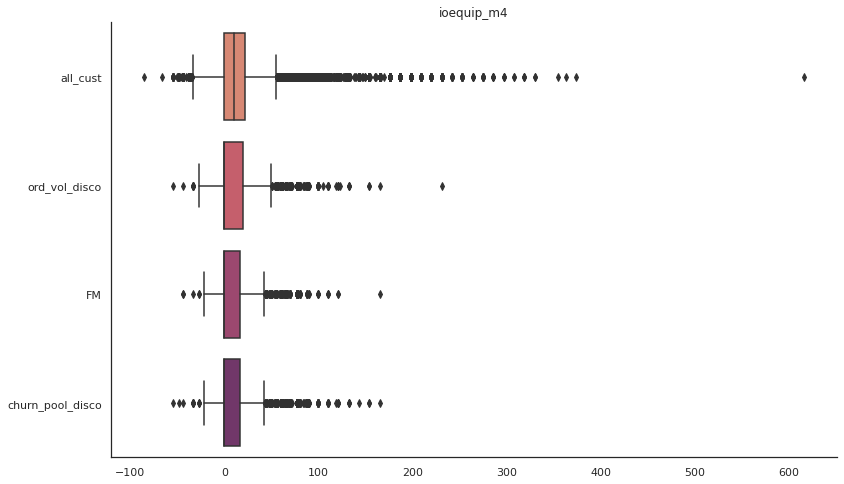

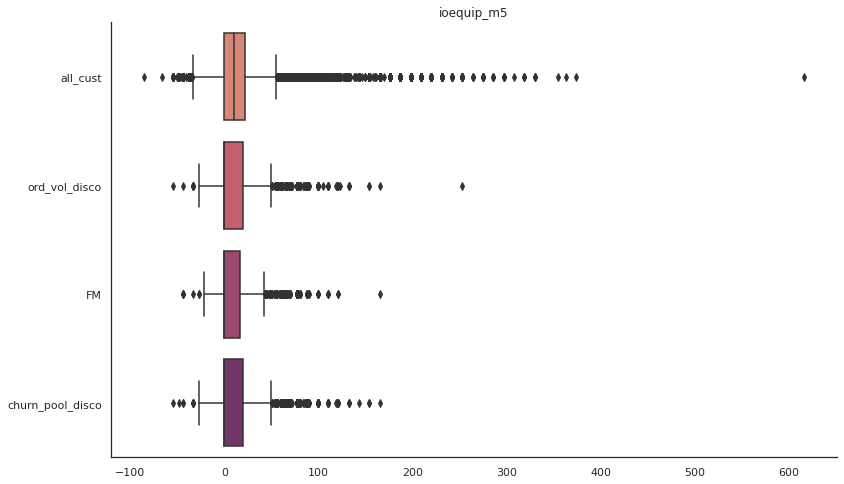

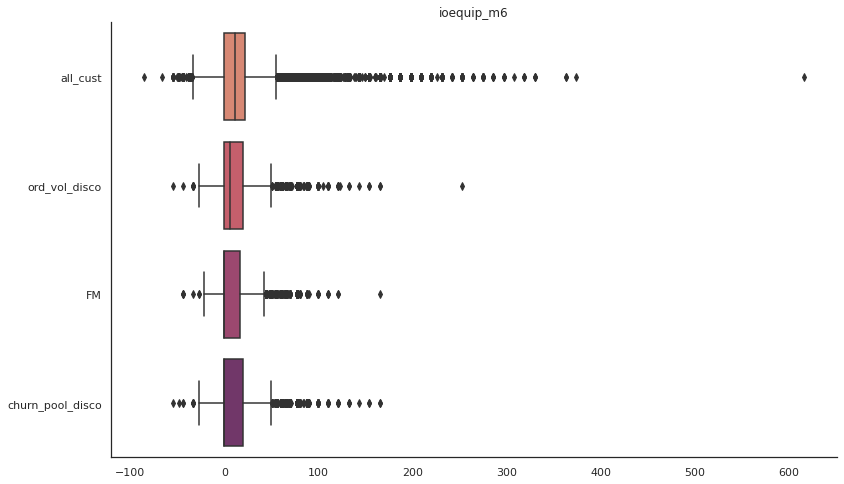

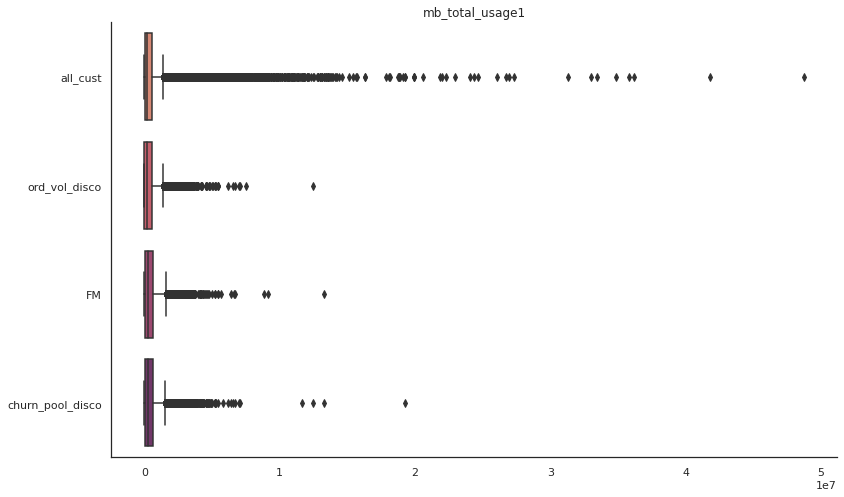

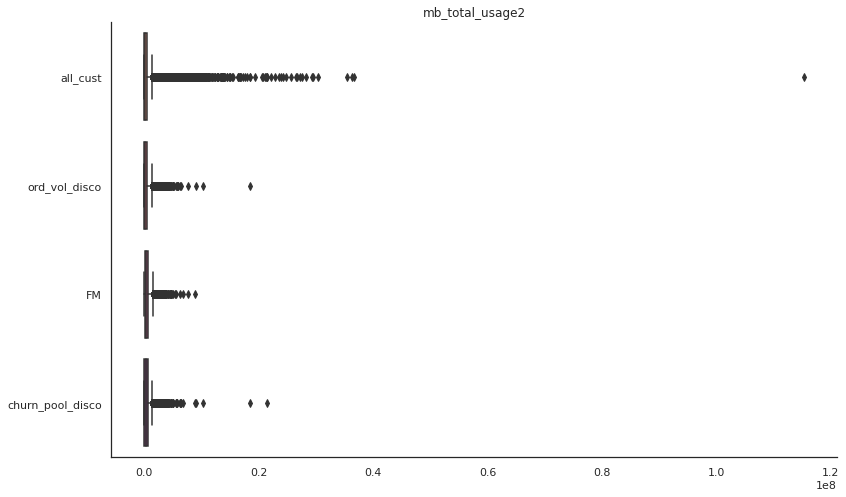

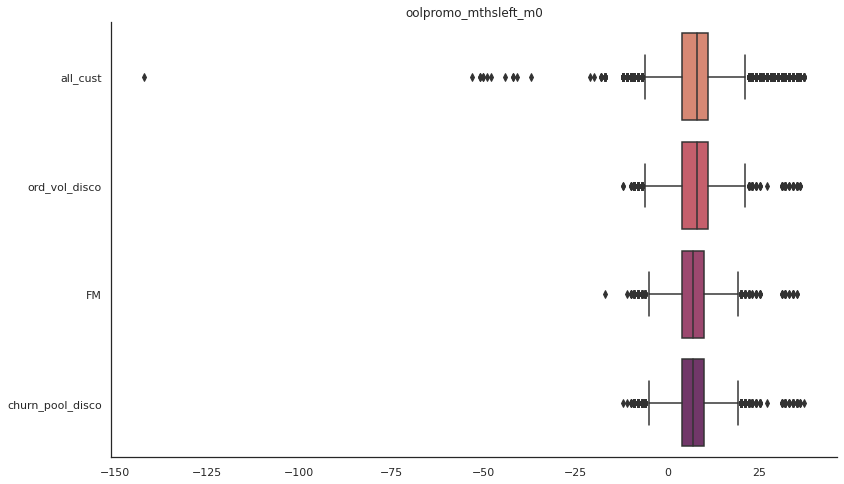

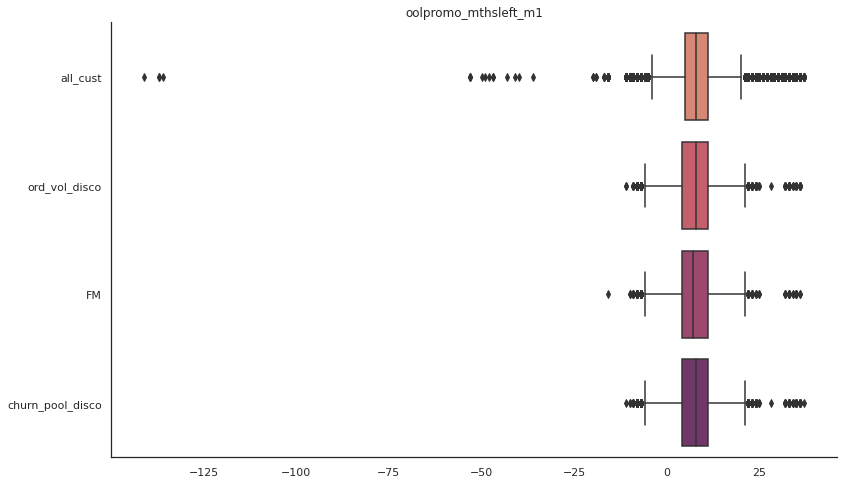

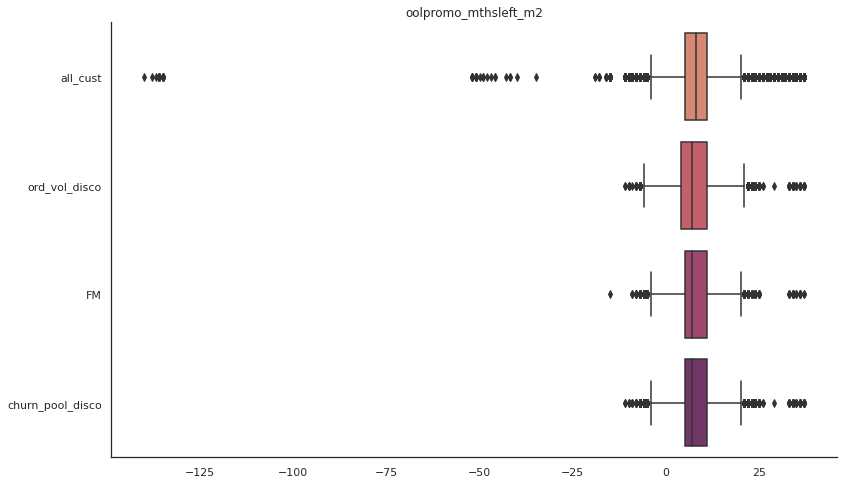

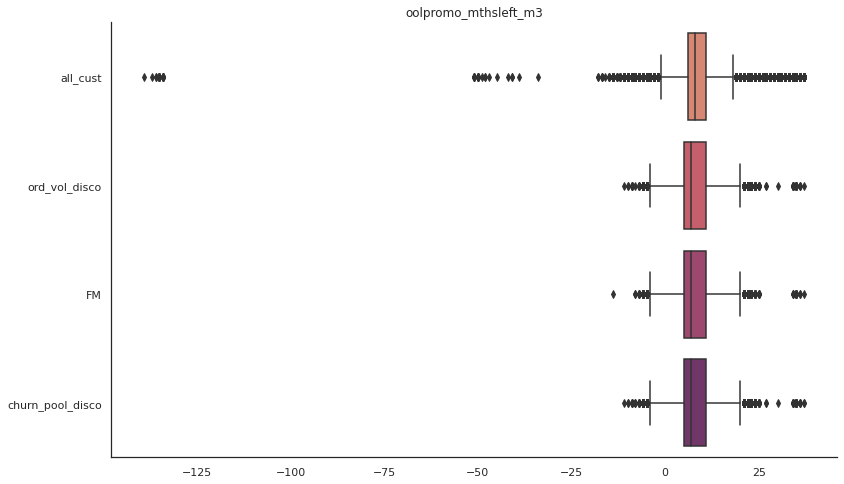

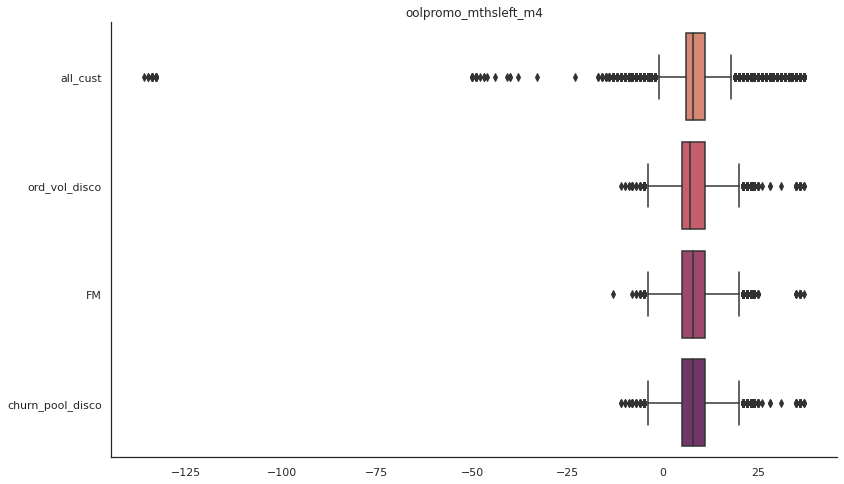

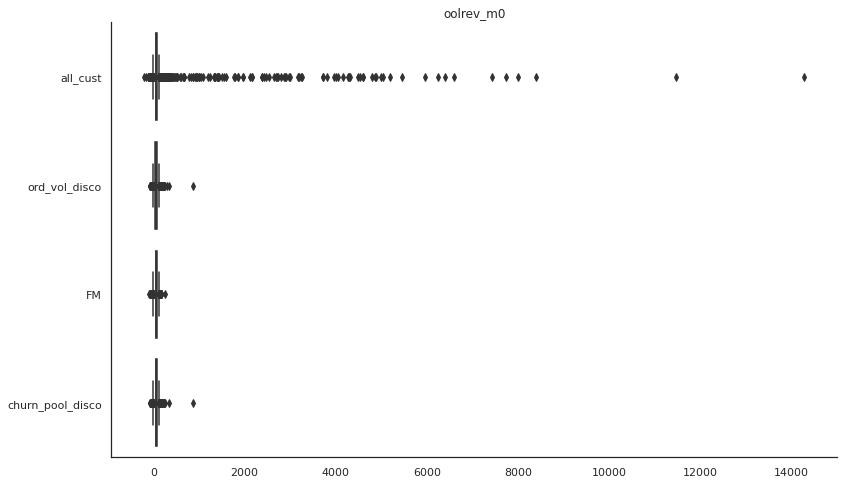

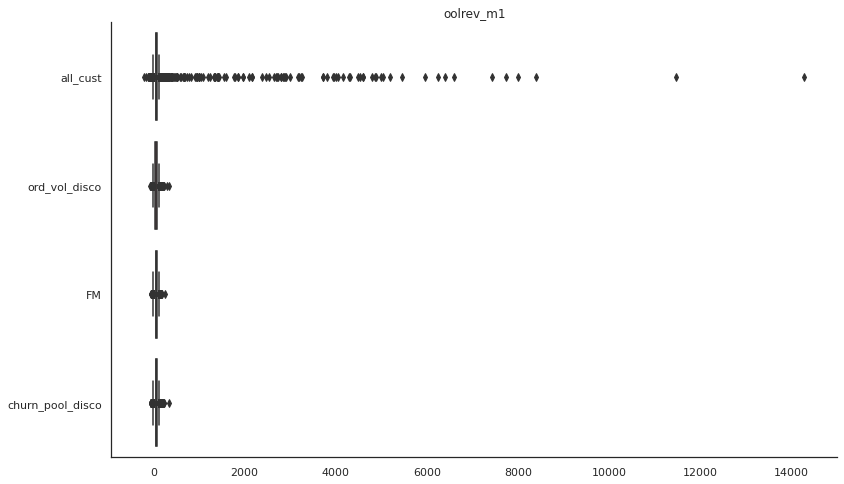

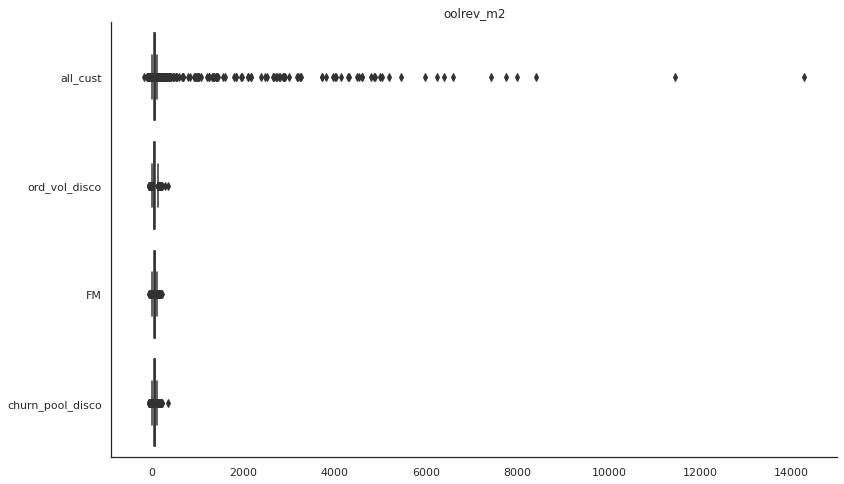

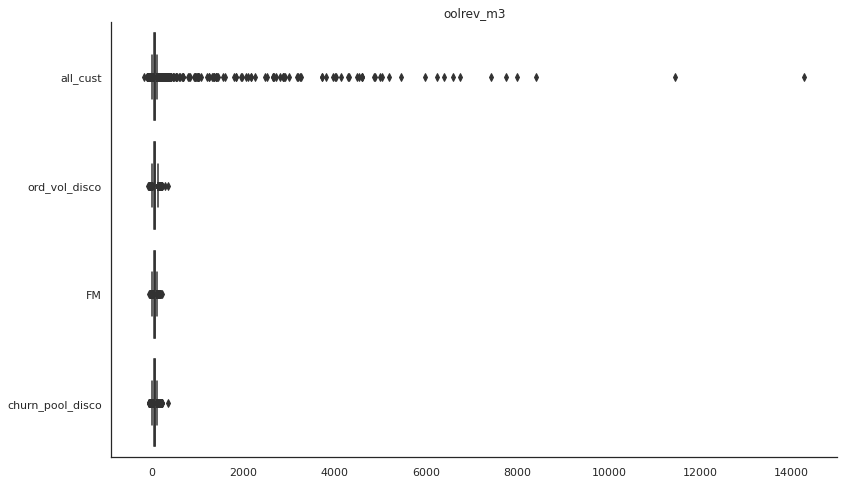

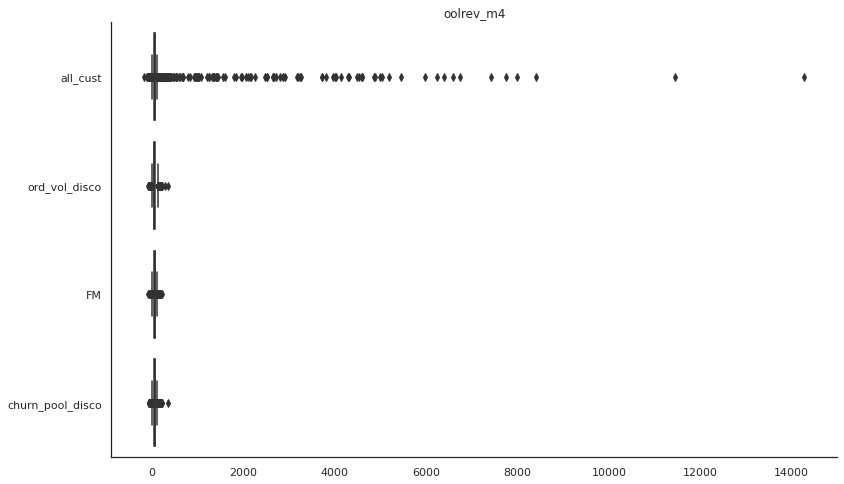

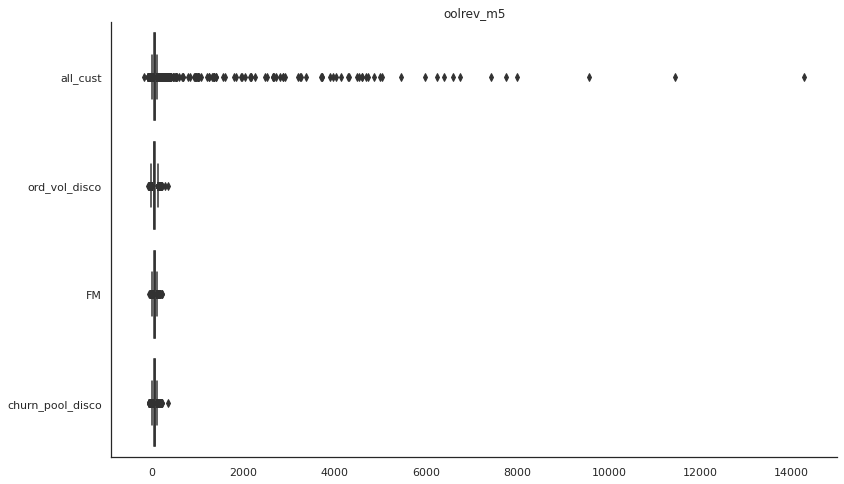

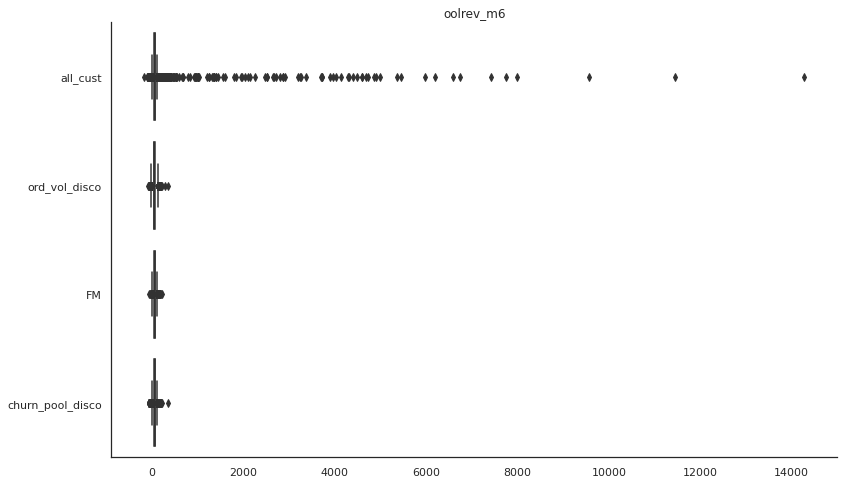

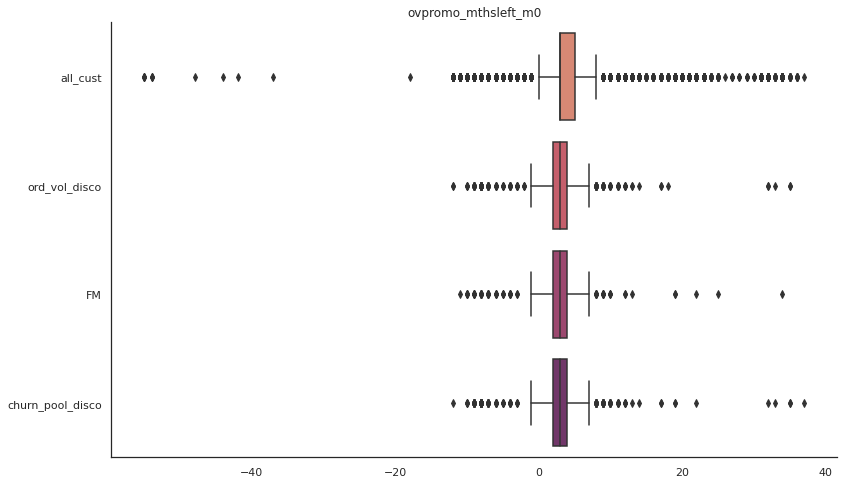

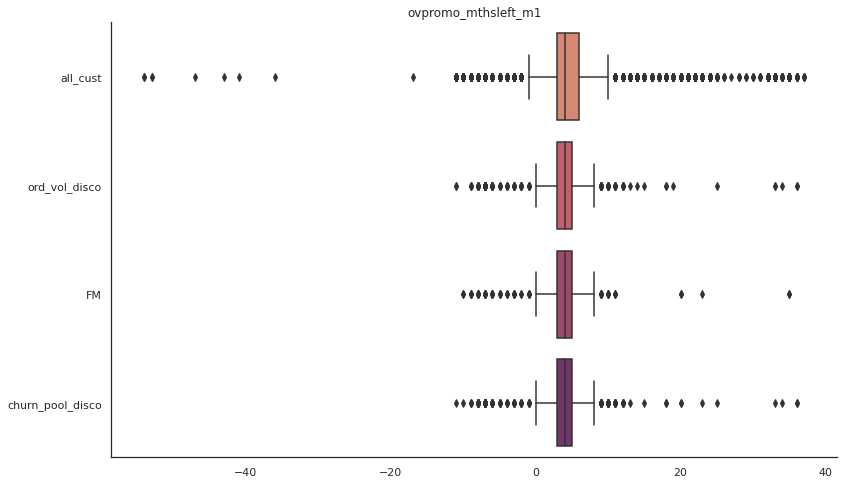

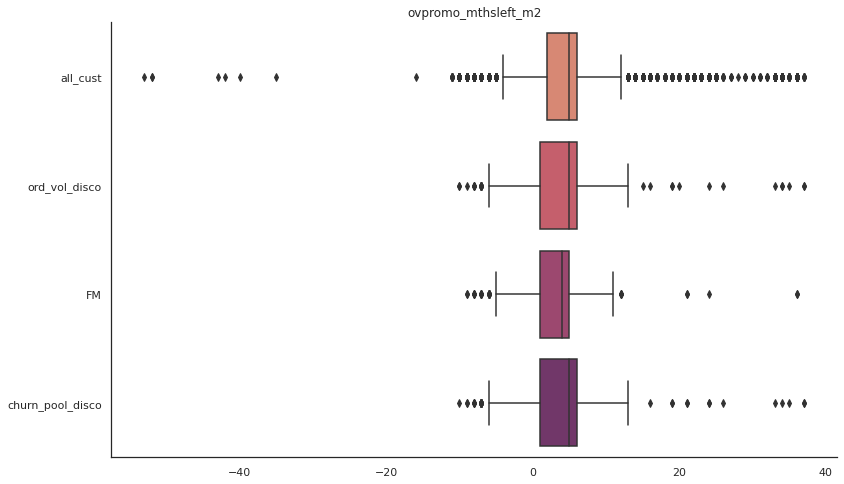

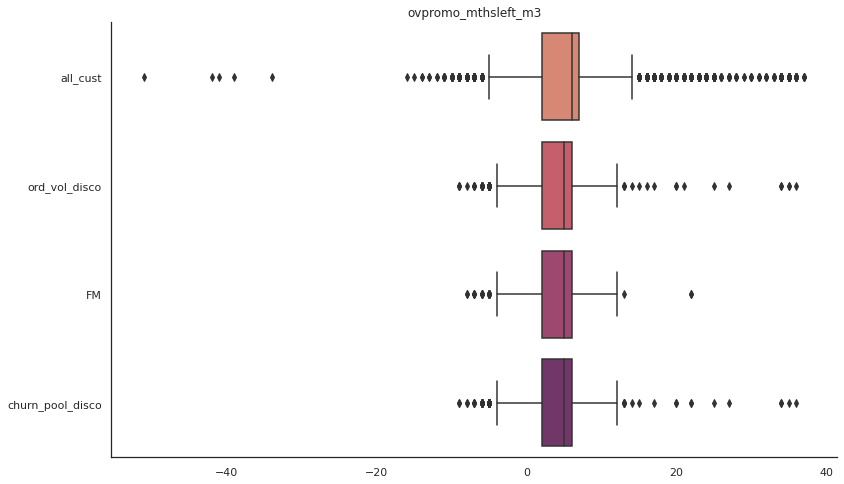

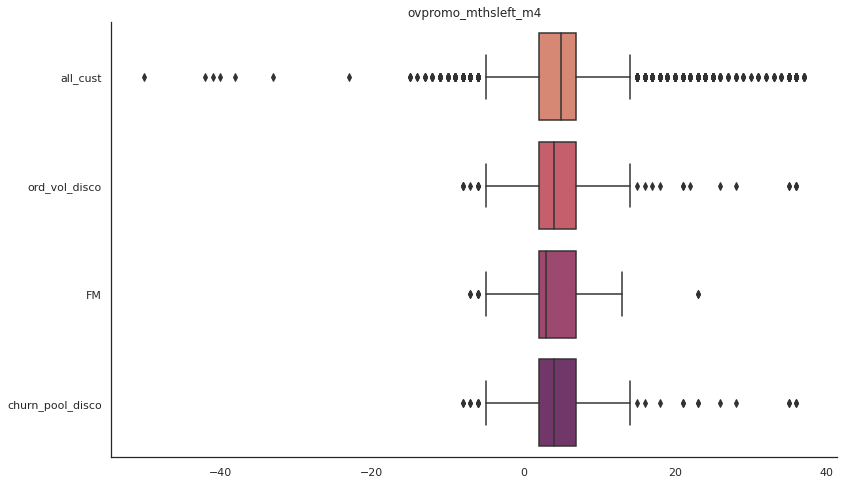

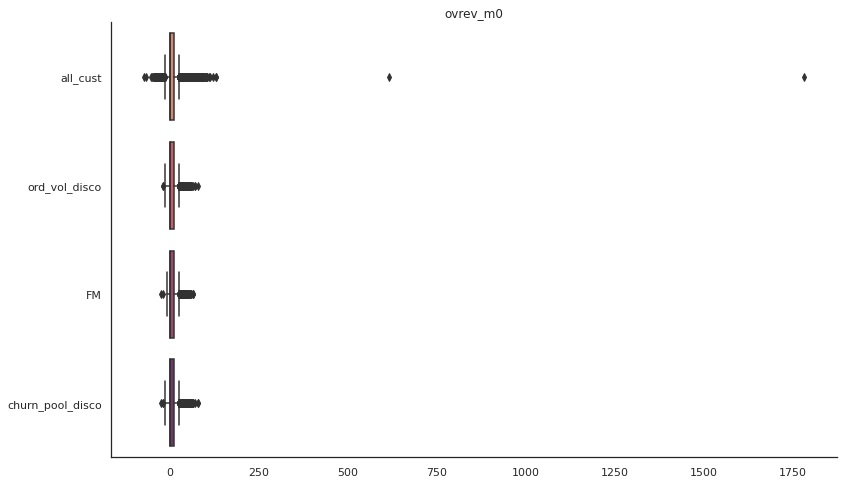

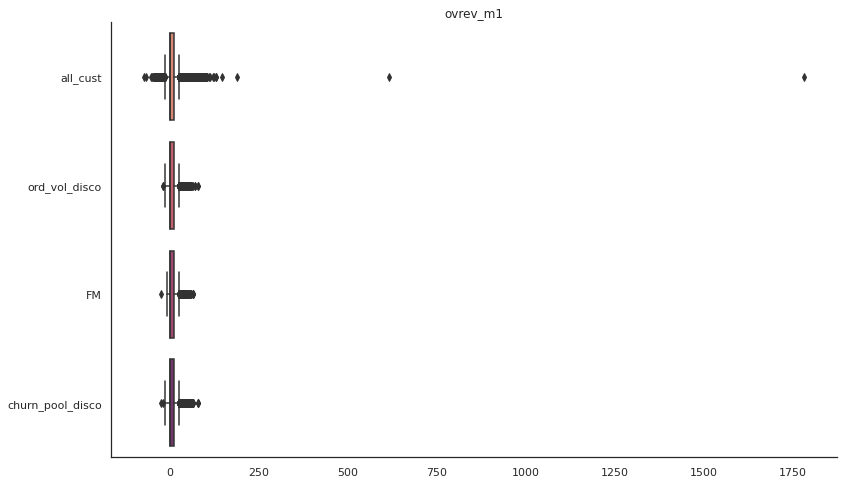

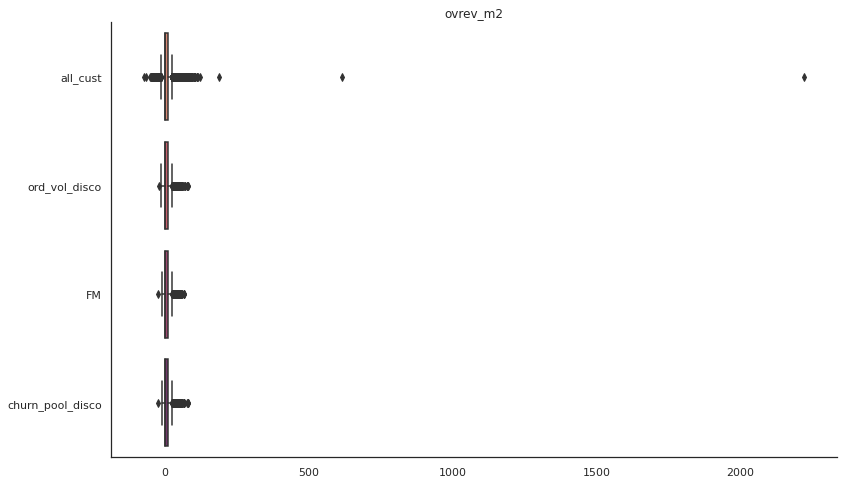

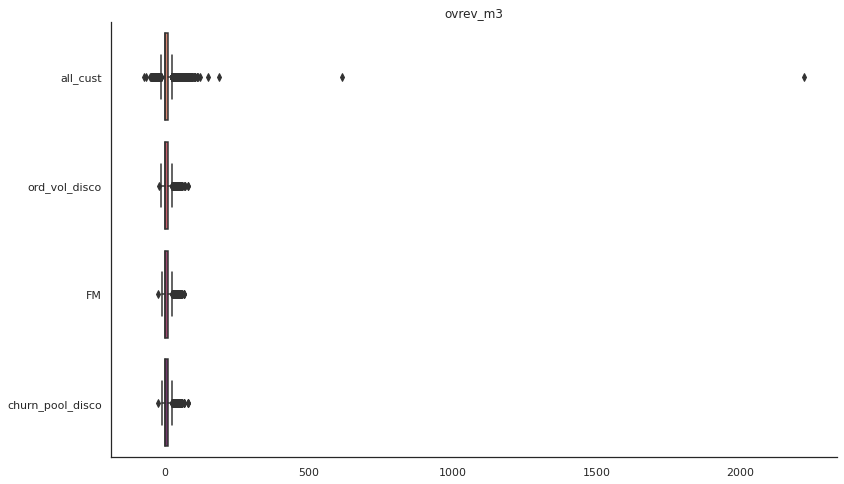

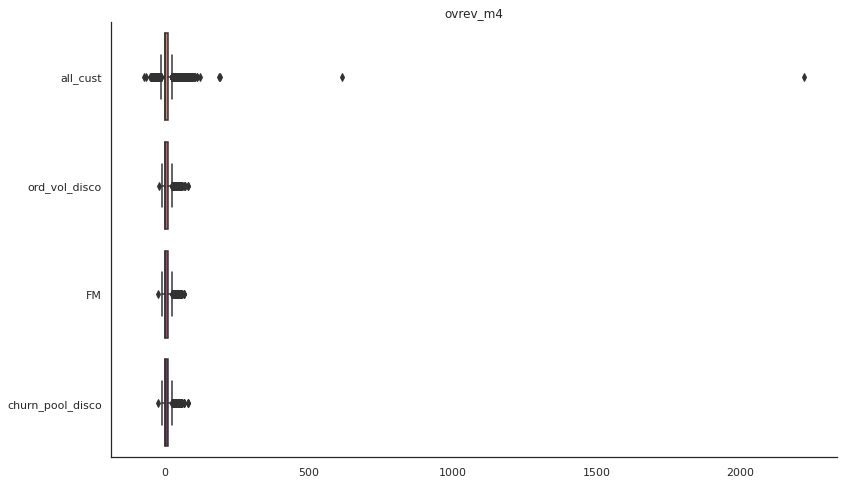

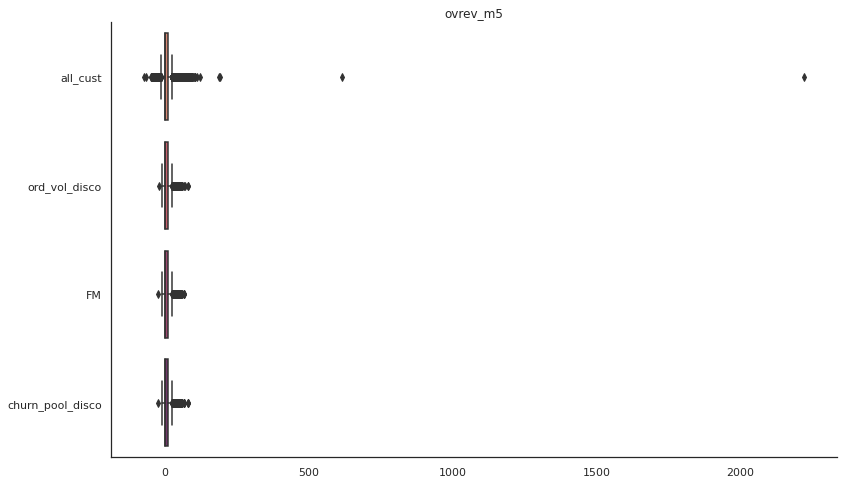

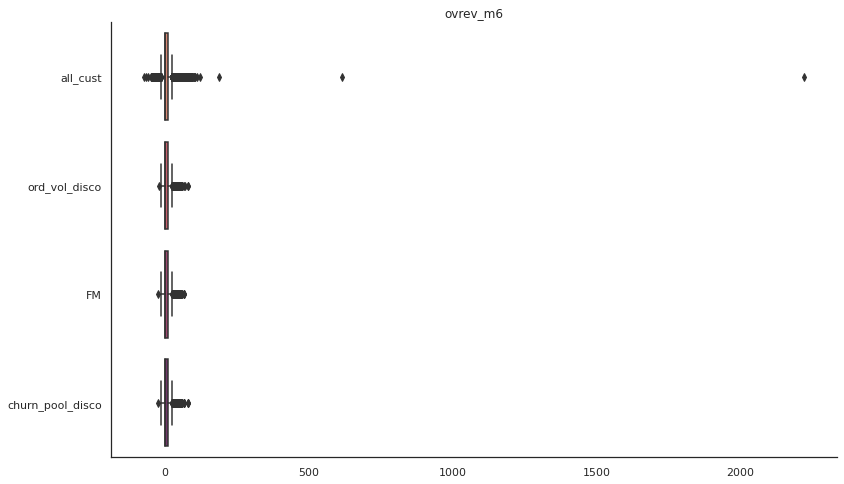

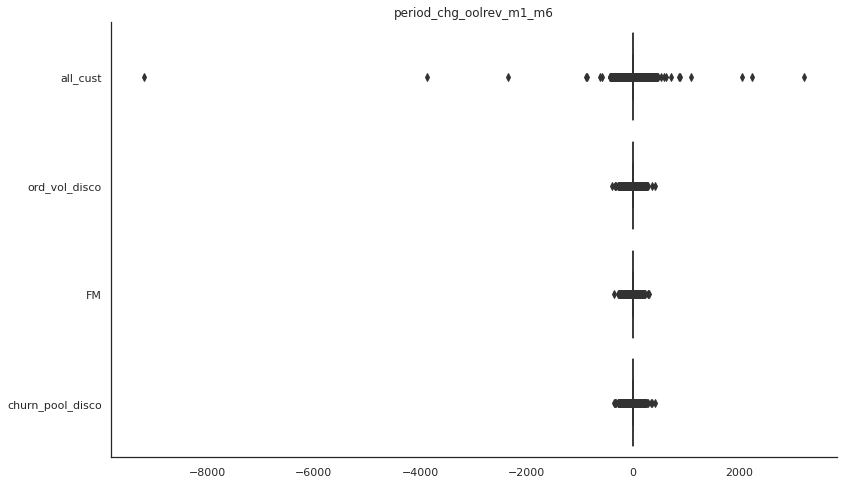

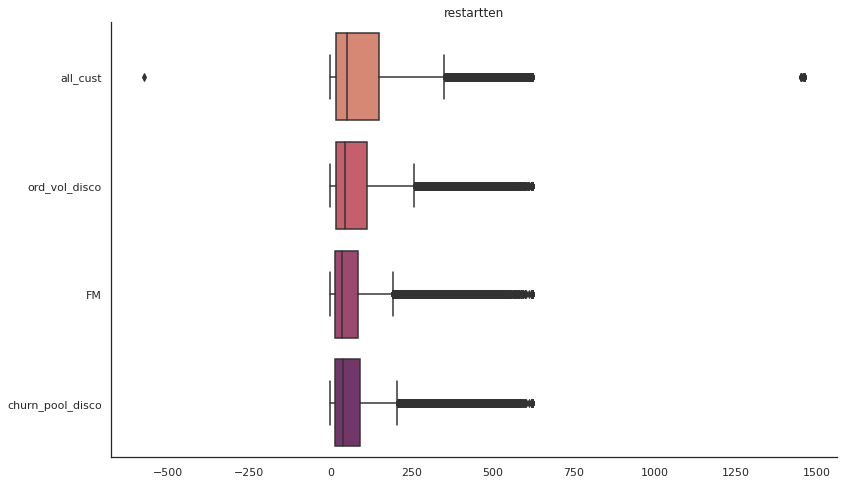

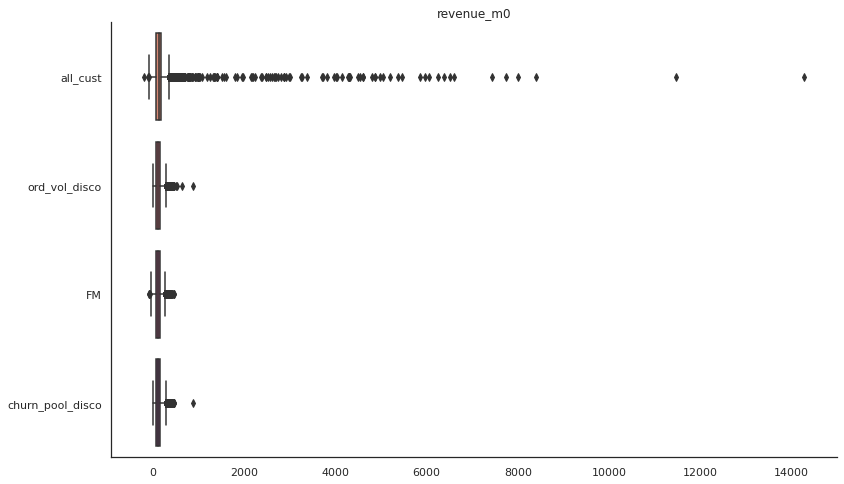

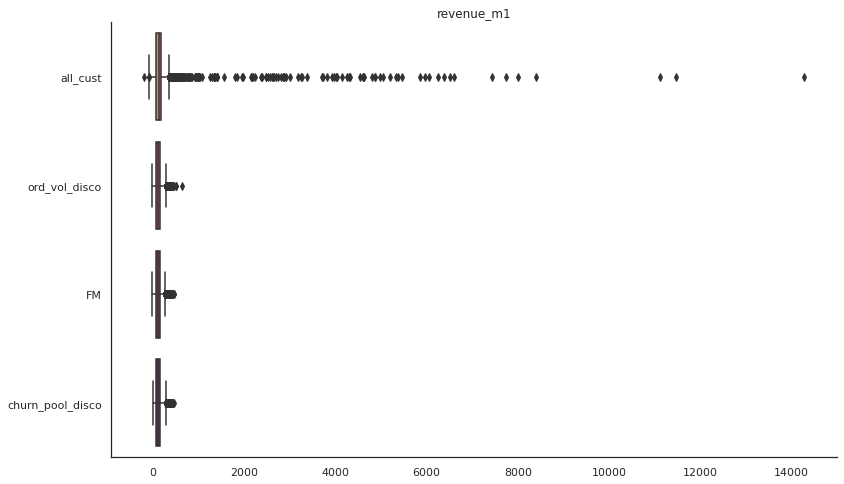

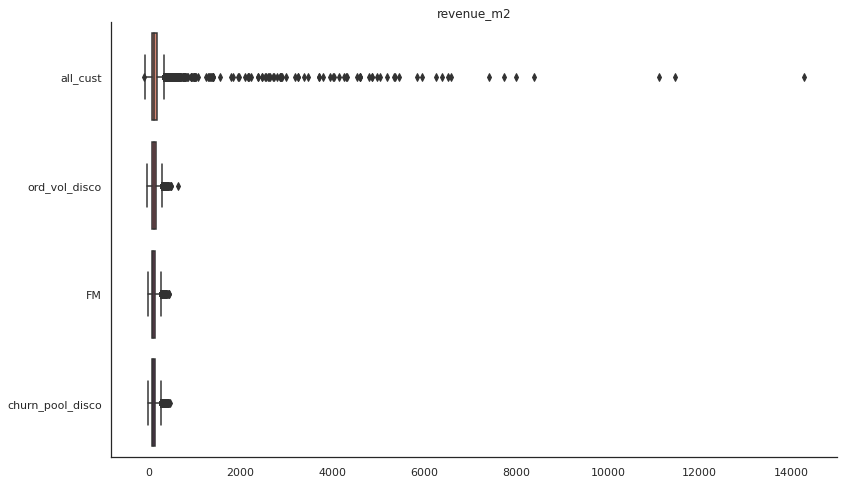

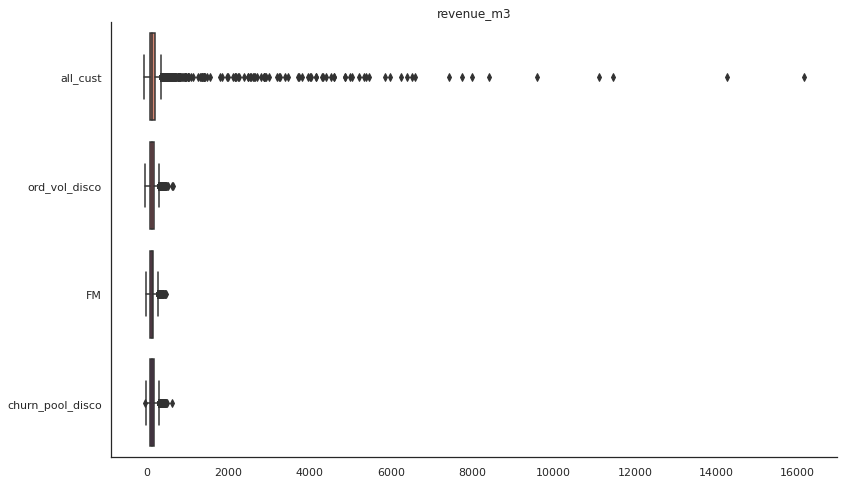

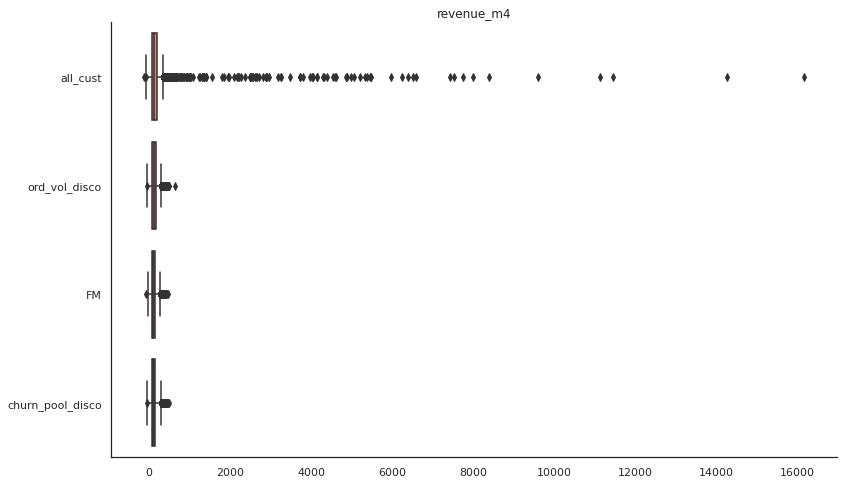

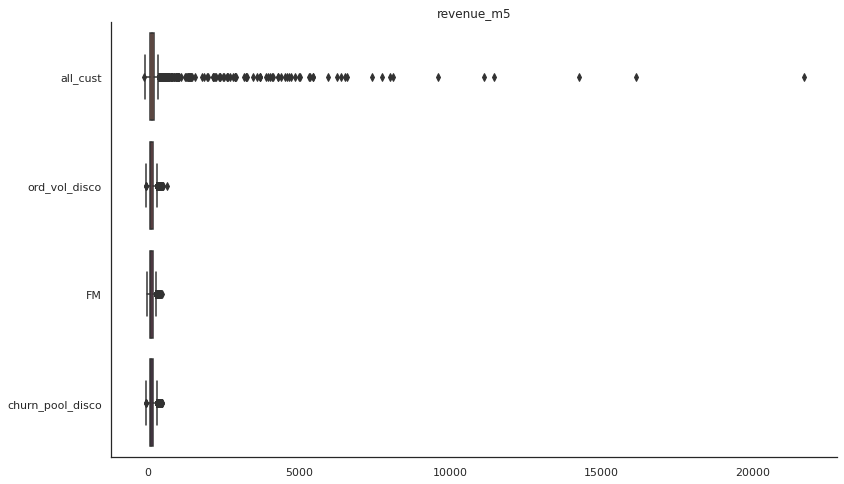

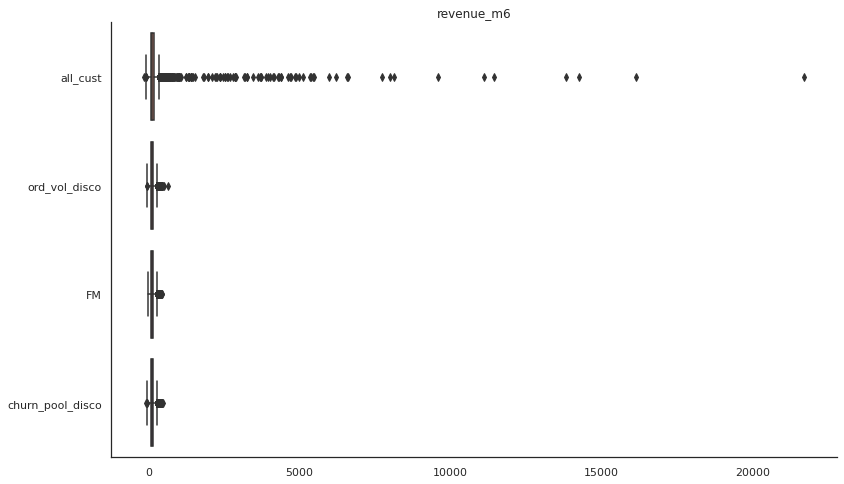

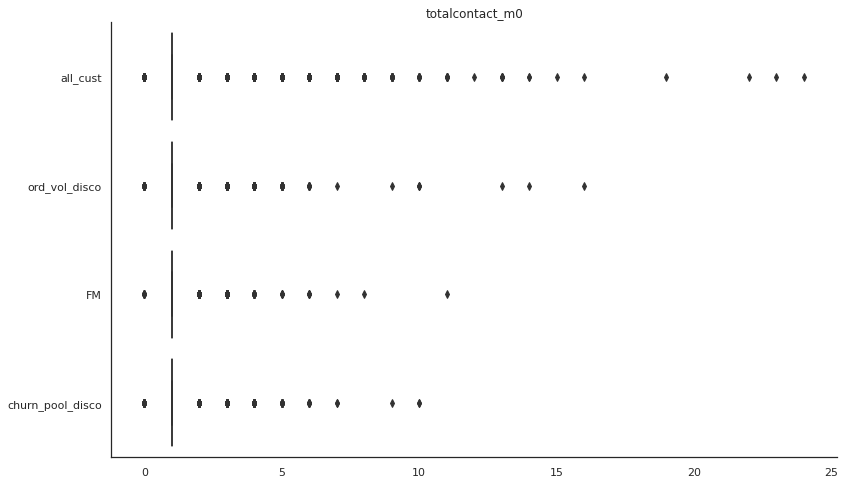

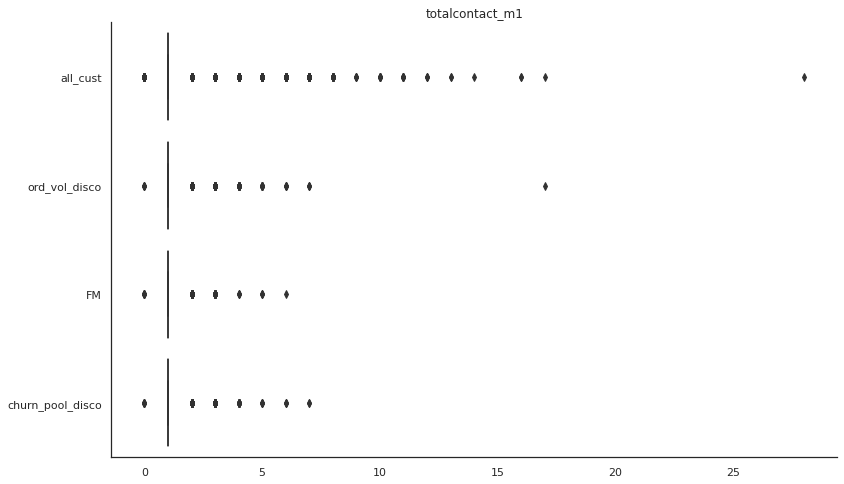

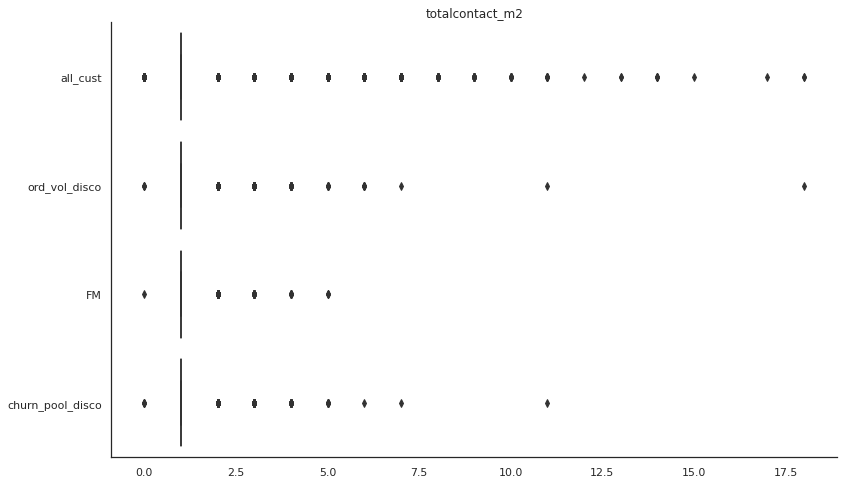

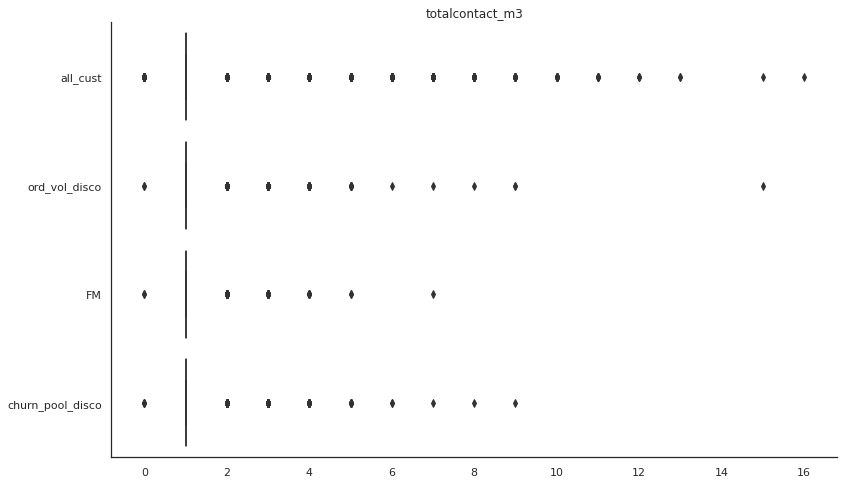

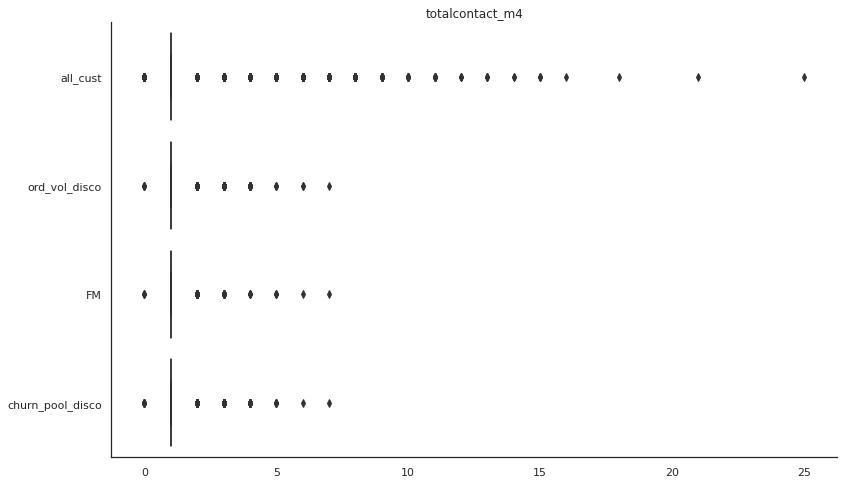

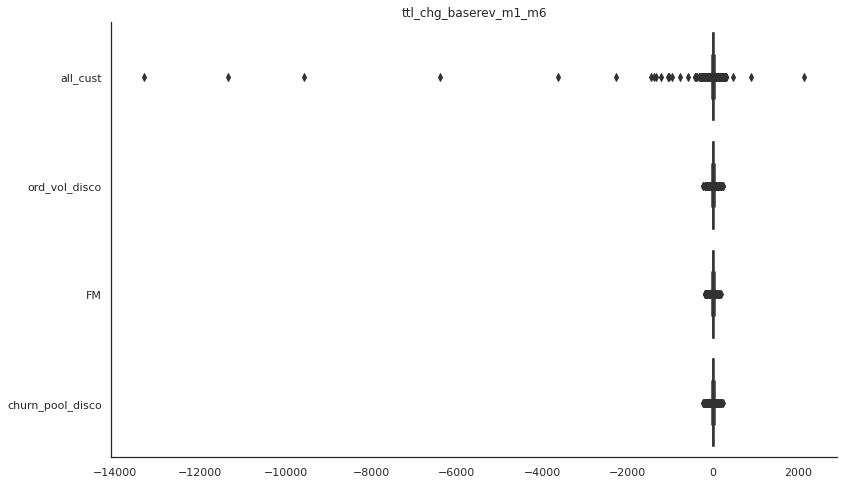

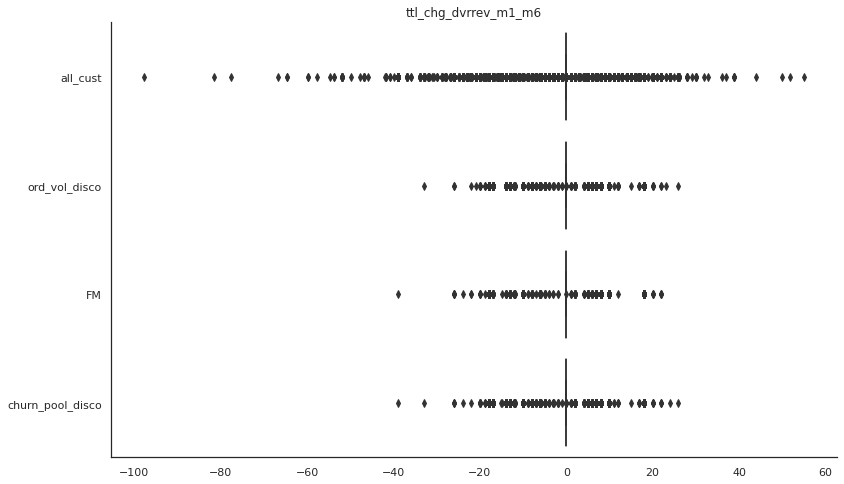

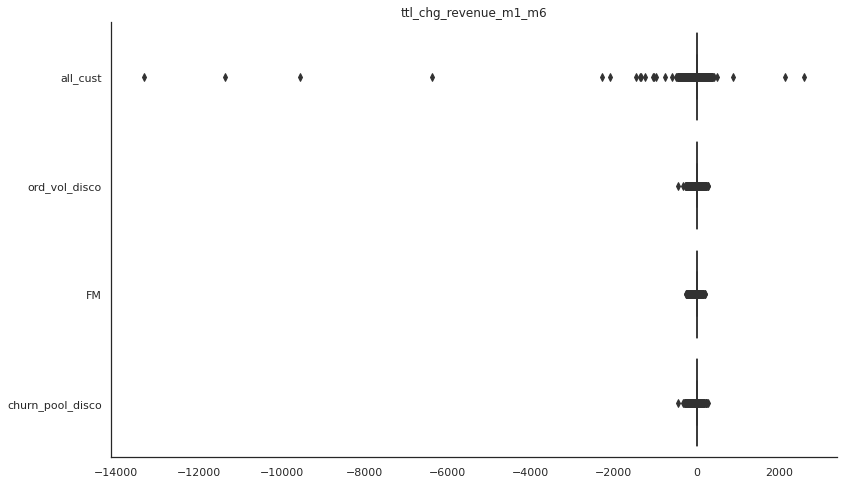

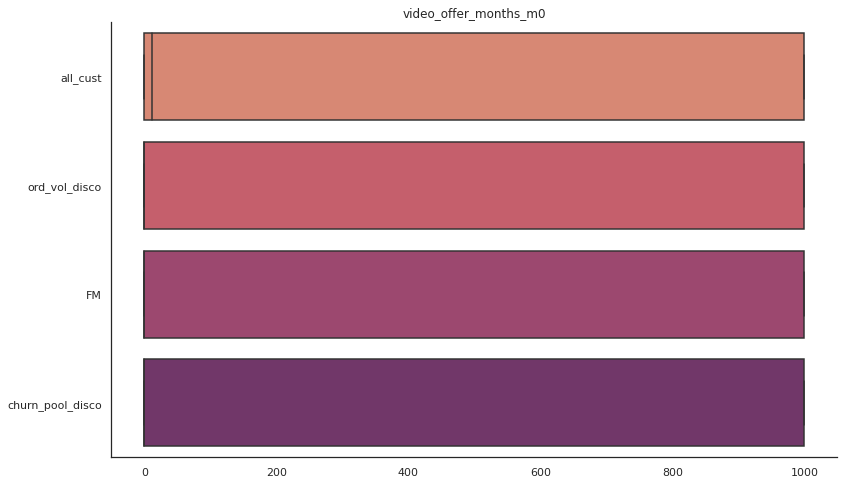

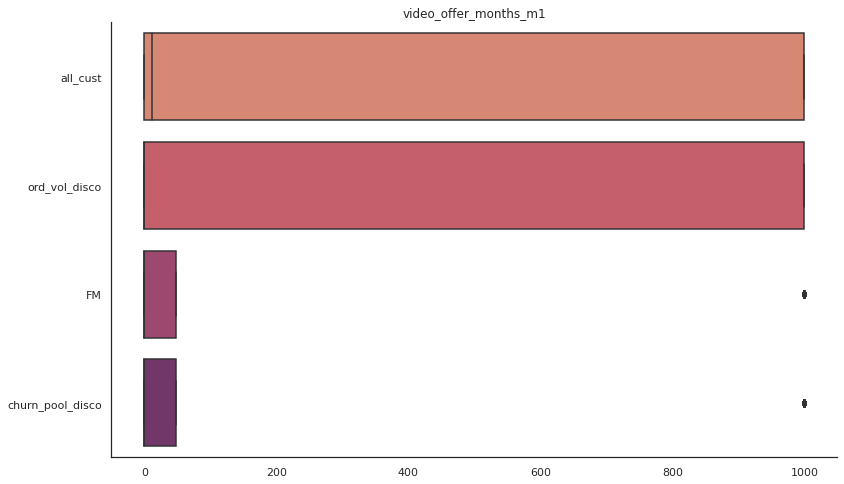

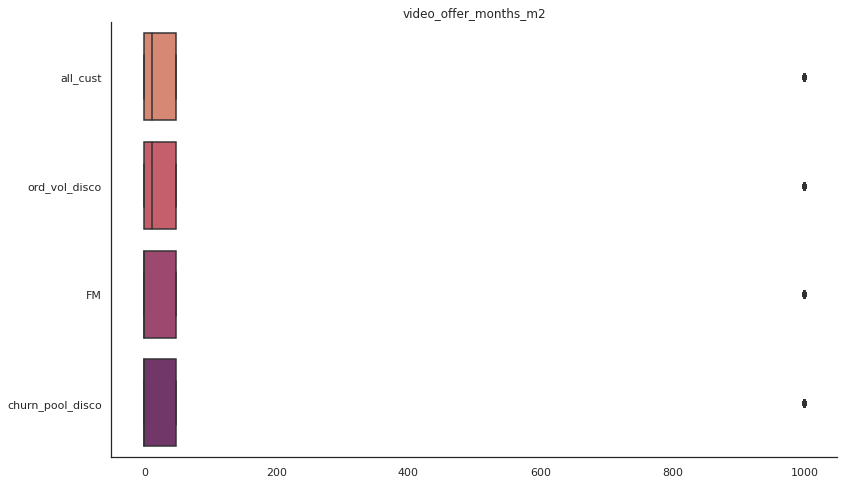

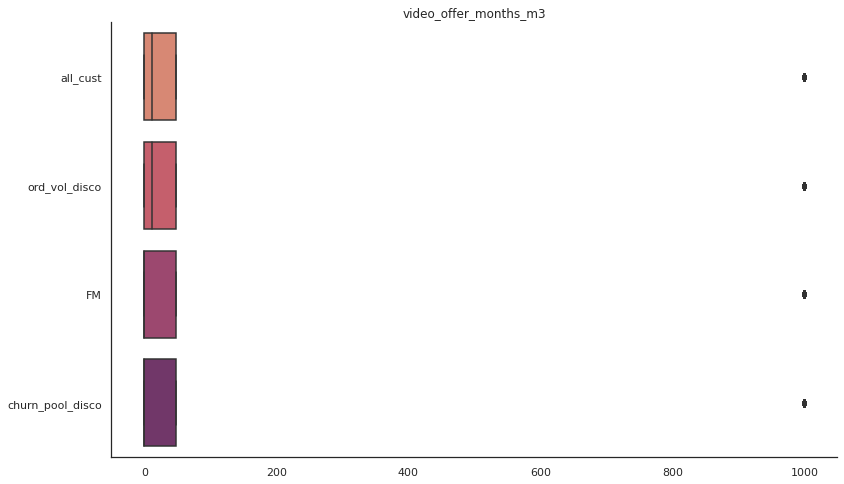

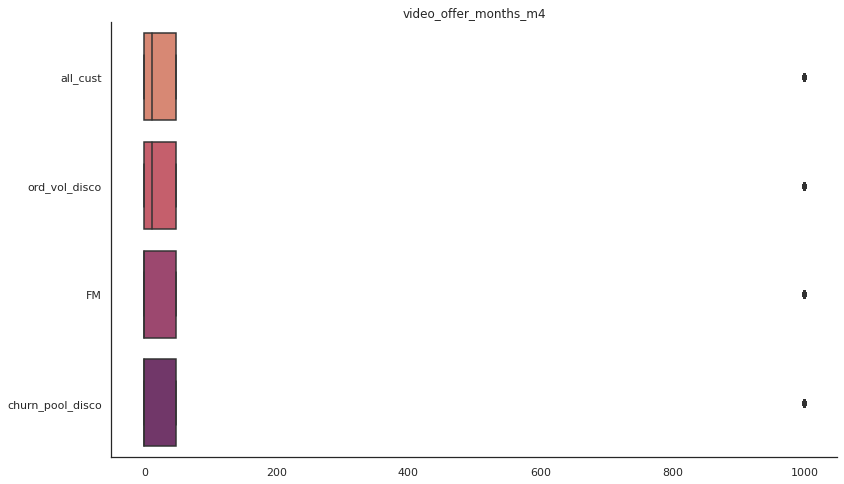

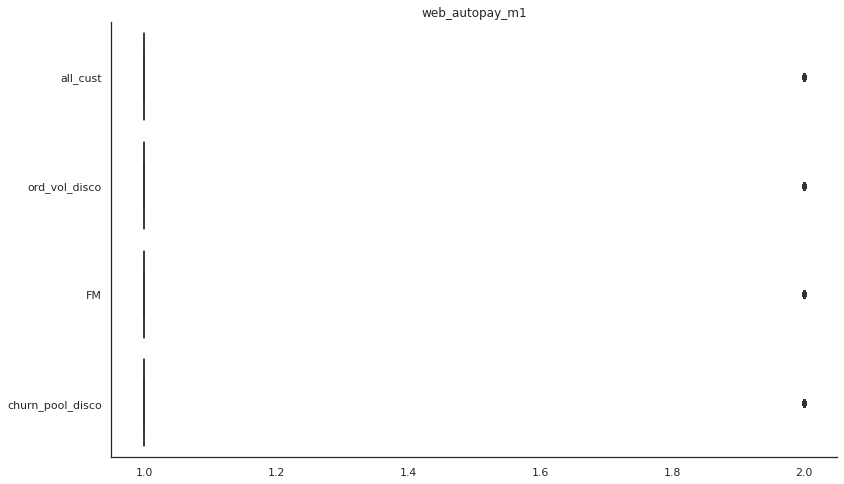

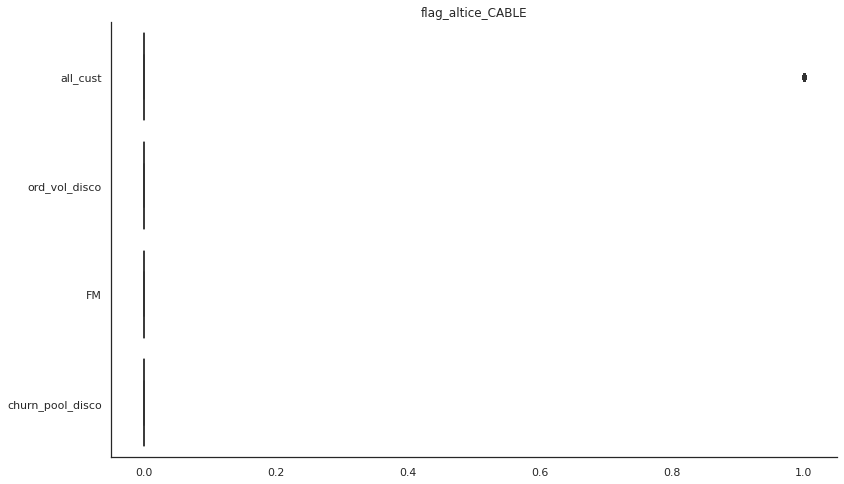

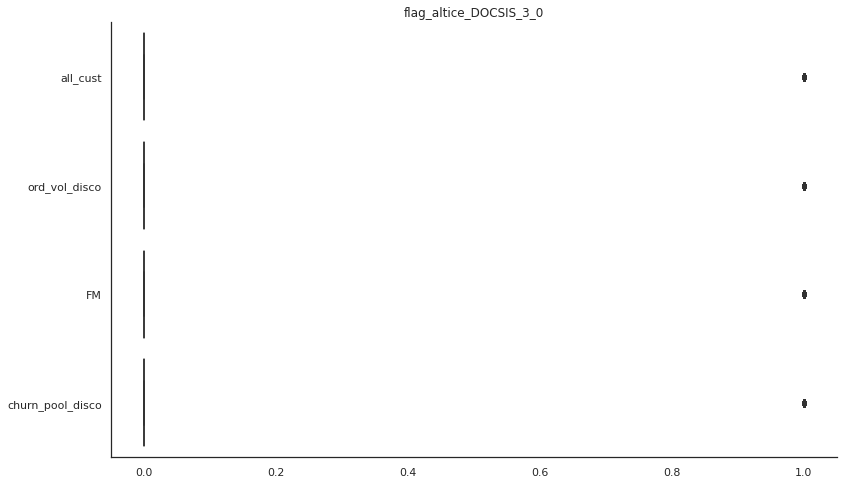

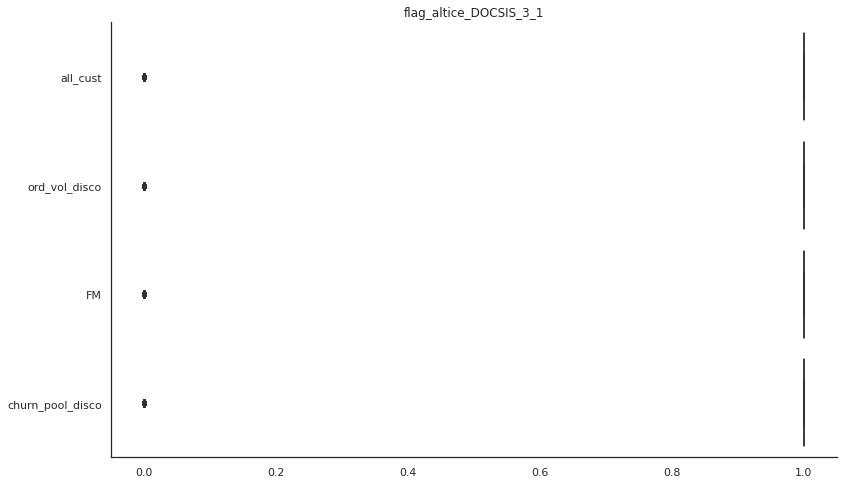

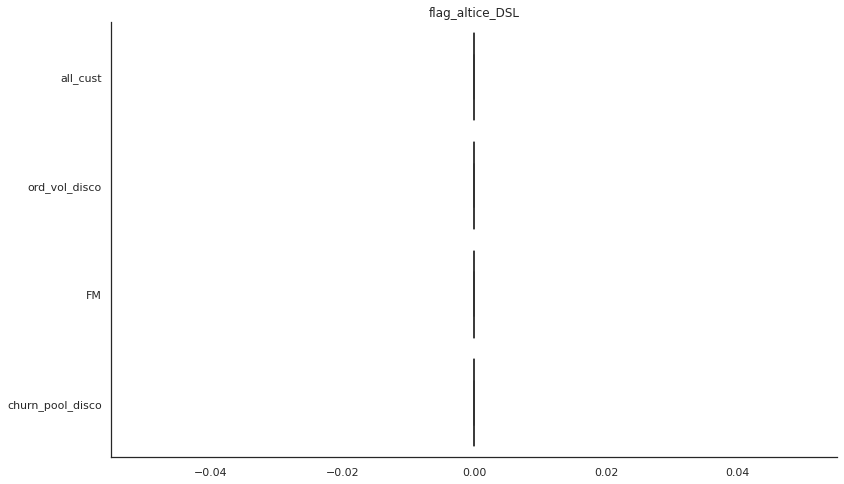

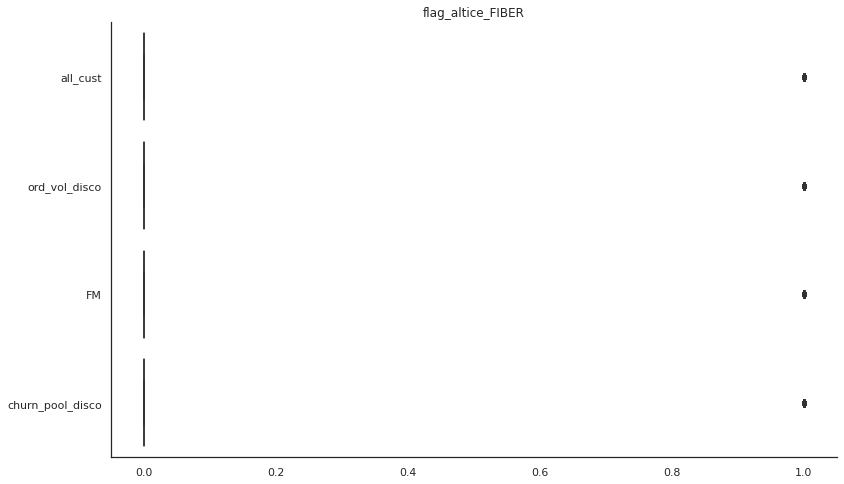

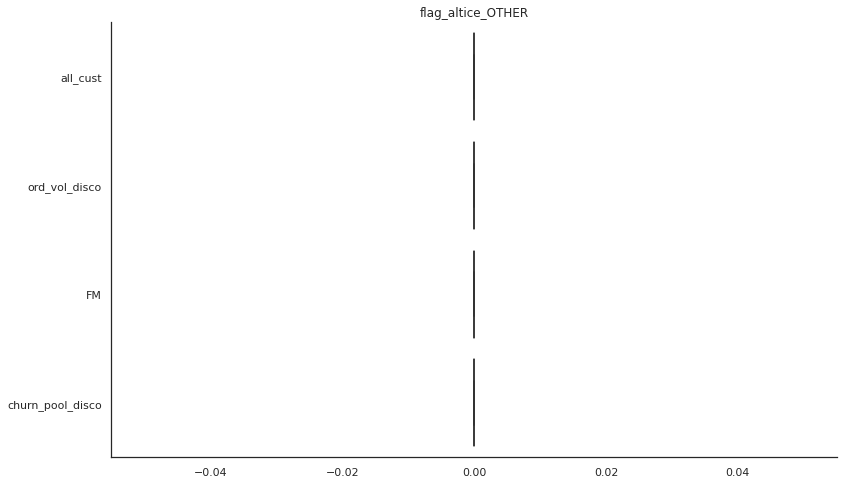

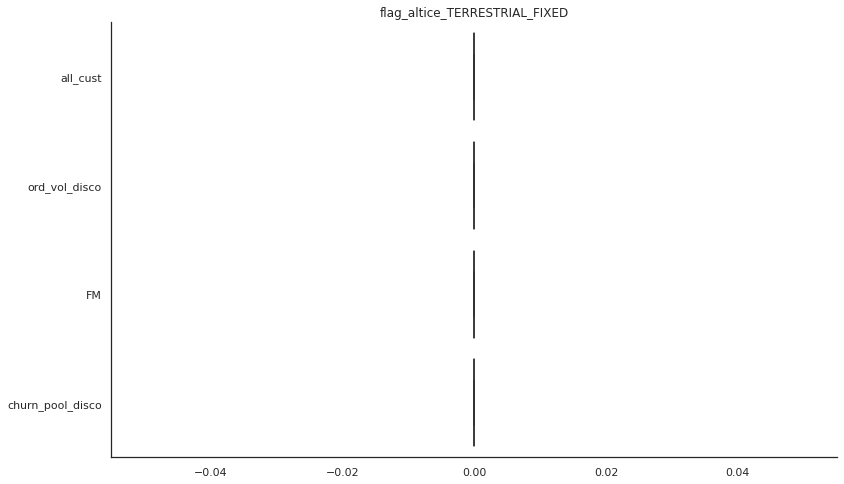

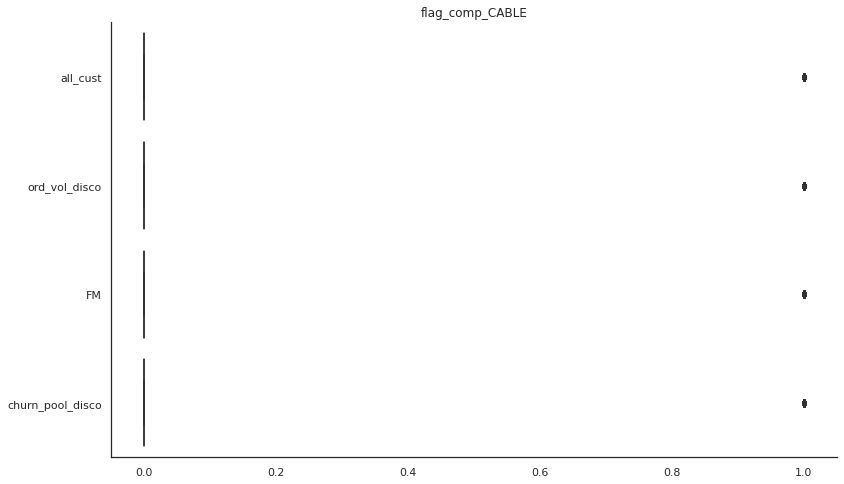

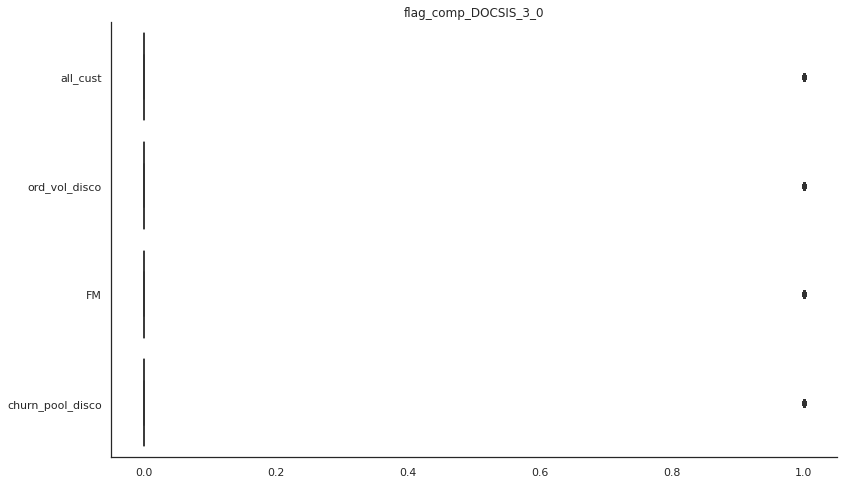

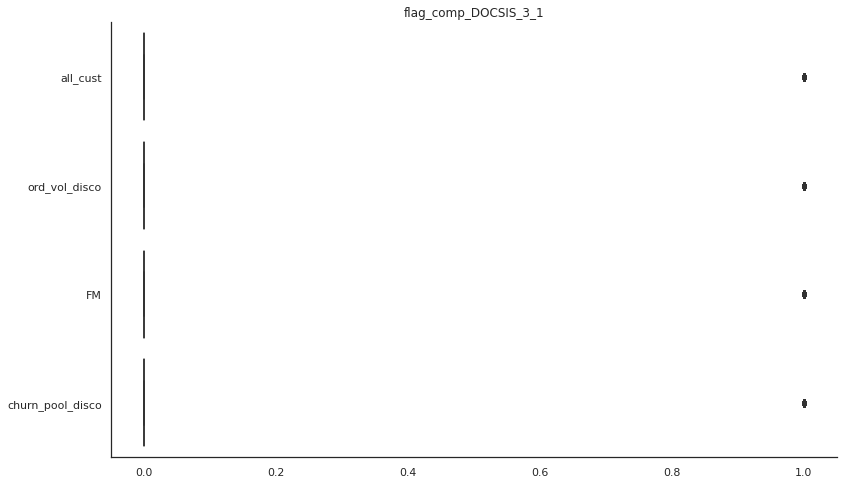

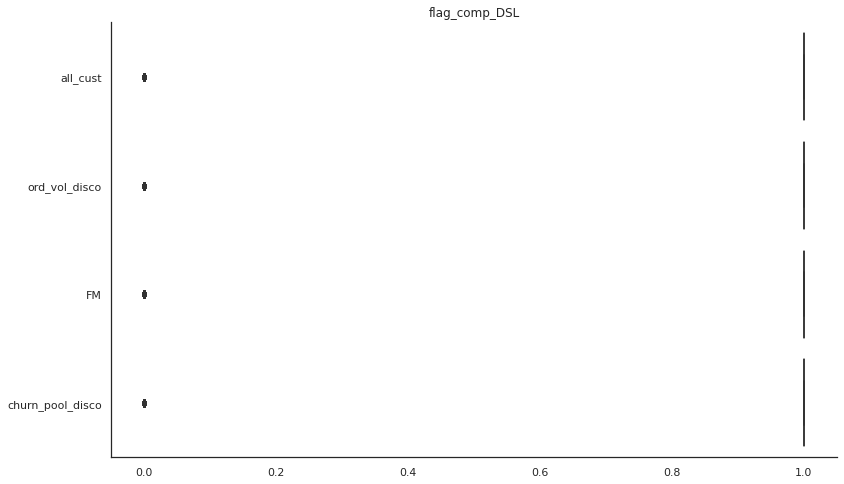

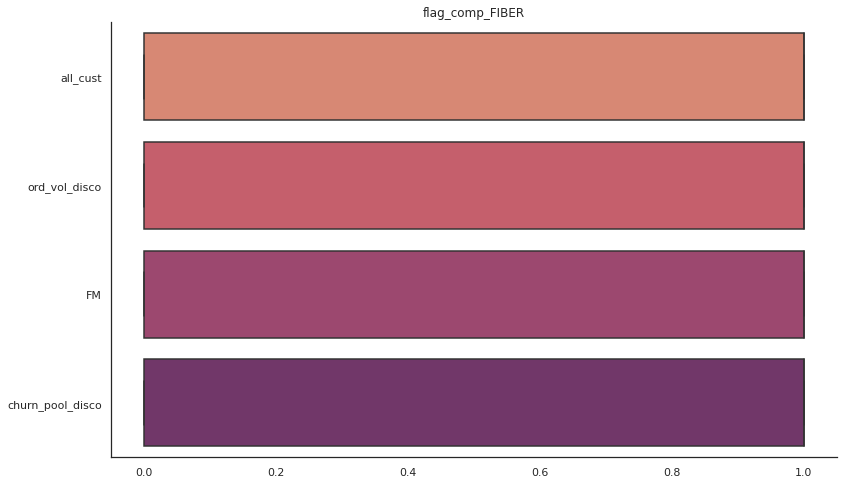

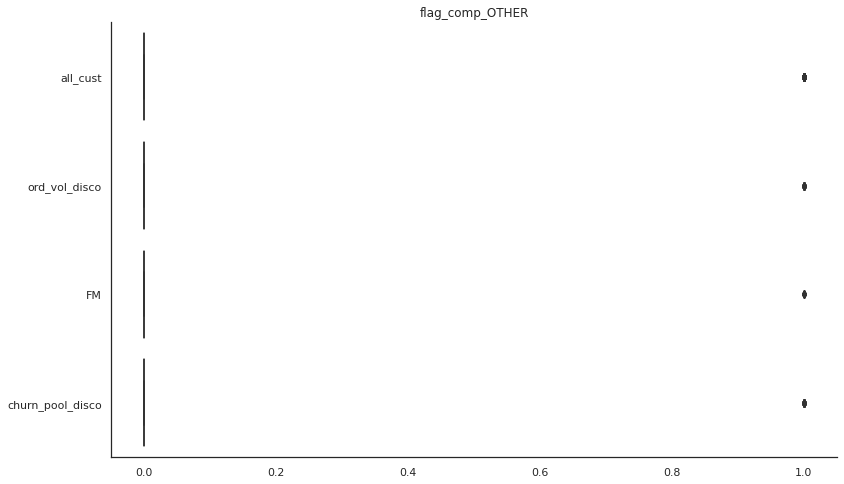

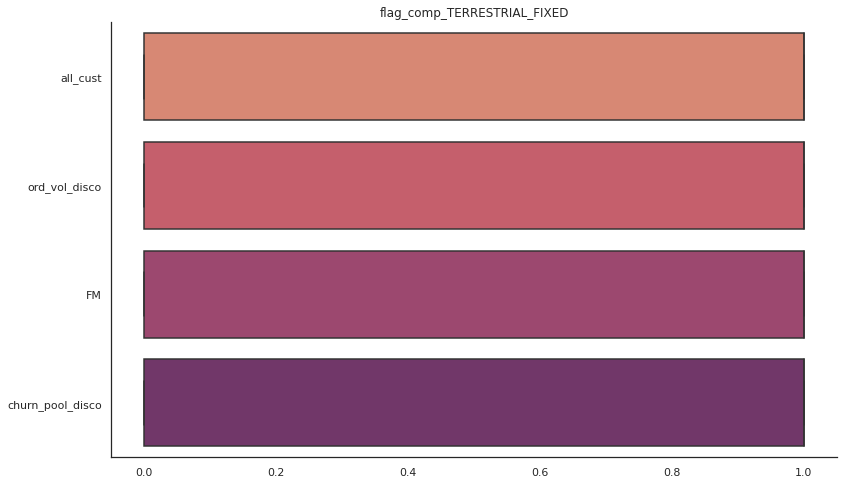

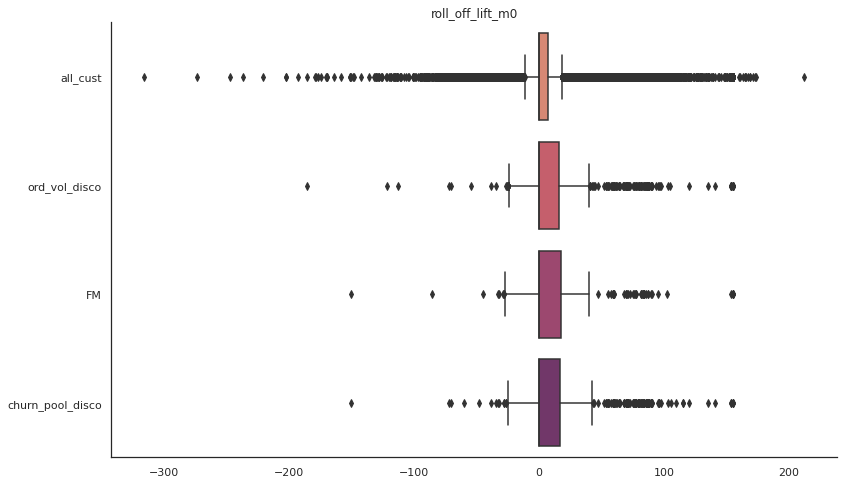

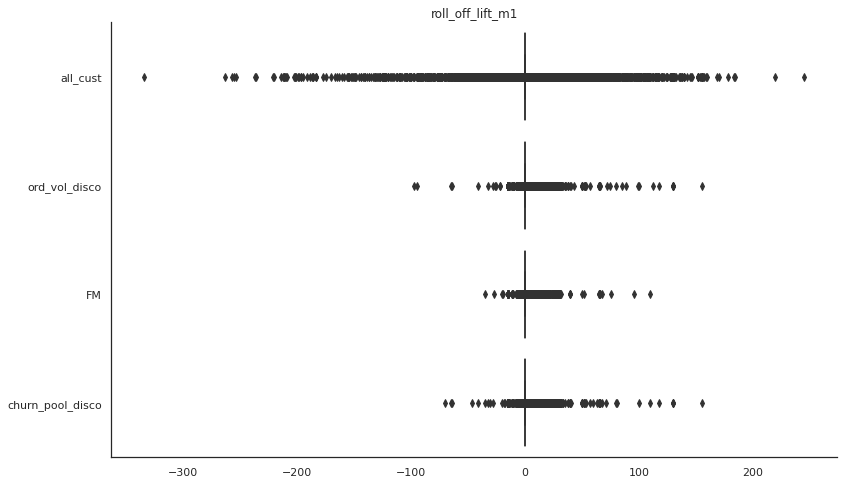

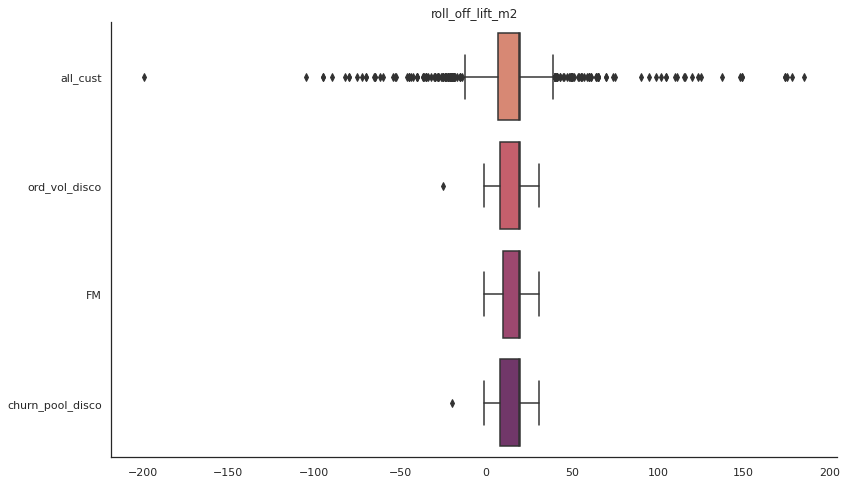

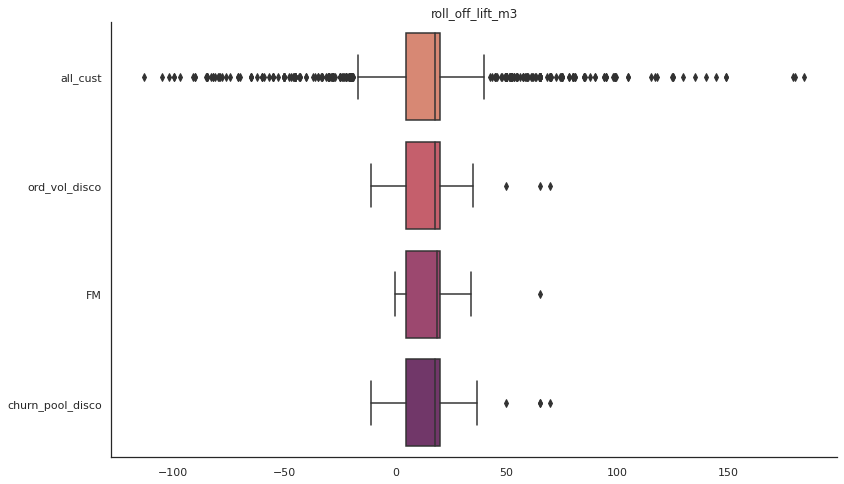

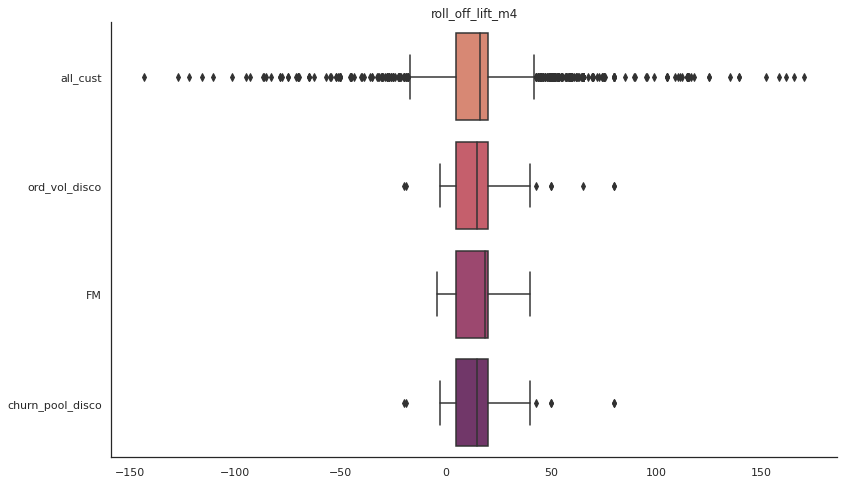

In [92]:
 for i in useful_numerical_cols:

        print(i)
        combined_dfs = pd.DataFrame({'all_cust': raw_data_res[i].astype('float'),
                                     'ord_vol_disco': raw_data_res[raw_data_res['OUTCOME_VOL_DISCO_NXT_3MTH'] == 1][i].astype('float'),
                                     'FM': raw_data_res[raw_data_res['OUTCOME_false_mover_flag'] == 1][i].astype('float'),
                                     'churn_pool_disco': raw_data_res[raw_data_res['OUTCOME_CHURN_DISCO_NXT_3MTH'] == 1][i].astype('float')})

        # combined_dfs.to_csv("Output_Data/combined_dfs.csv")
        # print(combined_dfs.describe())
        
        figu = plt.figure(i)
        sns.set(rc = {'figure.figsize':(13,8)})
        sns.set_style('white')
        sns.boxplot(data=combined_dfs,  orient="h", palette='flare').set(title=i)
        sns.despine()
        figu.savefig('box_plots_numerical_features/' + i + '.png')

## Categorical data analysis

In [19]:
raw_data_res.shape

(4634832, 357)

In [20]:
# Testing code
new1 = raw_data_res[['OUTCOME_VOL_DISCO_NXT_3MTH','OUTCOME_false_mover_flag','OUTCOME_CHURN_DISCO_NXT_3MTH', 'videopromo_rng_m0']]
new1['videopromo_rng_m0'] = new1['videopromo_rng_m0'].astype(str)

new2 = new1.groupby('videopromo_rng_m0')['OUTCOME_VOL_DISCO_NXT_3MTH','OUTCOME_false_mover_flag','OUTCOME_CHURN_DISCO_NXT_3MTH'].apply(lambda x : x.sum().astype(int)).reset_index()
new2

,videopromo_rng_m0,OUTCOME_VOL_DISCO_NXT_3MTH,OUTCOME_false_mover_flag,OUTCOME_CHURN_DISCO_NXT_3MTH
0,None,47575,23708,59966
1,a: 0-2,509,206,526
2,b: 3-5,1471,735,1819
3,c: 6-11,2305,1026,2823
4,d: 12-13,652,238,602
5,e: 14-15,118,59,171
6,f: 16-21,148,91,220
7,g: 22+,47,24,54


In [22]:
df_cat = pd.DataFrame()

for i in all_categorical_cols:
    df_new = raw_data_res[['OUTCOME_VOL_DISCO_NXT_3MTH','OUTCOME_false_mover_flag','OUTCOME_CHURN_DISCO_NXT_3MTH', i]]
    df_new[i] = df_new[i].astype(str)
    df_levels_sum = df_new.groupby(i)['OUTCOME_VOL_DISCO_NXT_3MTH','OUTCOME_false_mover_flag','OUTCOME_CHURN_DISCO_NXT_3MTH'].apply(lambda x : x.sum().astype(int)).reset_index()
    print(i)
    
    df_count = pd.DataFrame(df_new[i].value_counts(normalize=False,dropna=False).reset_index().values, columns=['levels','total_customers'])
    
    df = df_count.merge(df_levels_sum, how = 'inner', left_on = 'levels', right_on = i)
    # df['OUTCOME_VOL_DISCO_FM'] = df['OUTCOME_VOL_DISCO_NXT_3MTH'] + df['OUTCOME_false_mover_flag']
    df['cat_features'] = i
    df['unique_cnt']   = df_new[i].nunique()
    
    df = df[['cat_features', 'levels', 'unique_cnt', 'total_customers', 'OUTCOME_VOL_DISCO_NXT_3MTH','OUTCOME_false_mover_flag','OUTCOME_CHURN_DISCO_NXT_3MTH']]
    
    df['total_customers_proportion']    = round(df['total_customers'].astype(float)*100/sum(df['total_customers'].astype(float)),2)
    df['vol_disconnect_proportion']   = round(df['OUTCOME_VOL_DISCO_NXT_3MTH'].astype(float)*100/sum(df['OUTCOME_VOL_DISCO_NXT_3MTH'].astype(float)),2)
    df['false_movers_proportion']     = round(df['OUTCOME_false_mover_flag'].astype(float)*100/sum(df['OUTCOME_false_mover_flag'].astype(float)),2)
    df['churn_pool_disco_proportion'] = round(df['OUTCOME_CHURN_DISCO_NXT_3MTH'].astype(float)*100/sum(df['OUTCOME_CHURN_DISCO_NXT_3MTH'].astype(float)),2)
    
    df['vol_disconnect_rate'] = round(df['OUTCOME_VOL_DISCO_NXT_3MTH'].astype(float)*100/df['total_customers'].astype(float), 2)
    df['false_movers_rate']   = round(df['OUTCOME_false_mover_flag'].astype(float)*100/df['total_customers'].astype(float), 2)
    df['churn_pool_rate']     = round(df['OUTCOME_CHURN_DISCO_NXT_3MTH'].astype(float)*100/df['total_customers'].astype(float), 2)
    

    df_cat = pd.concat([df_cat, df])
    

cleansed_city
cleansed_state
cleansed_zipcode
head_end_desc
nwm_facility_desc
local_market_segment
market_region
operating_area_desc
metro_area_desc
product_class_desc
cust_equip_class
ool_svc_tier_detail_desc
speed_price_down_up
speed_down_up
video_tier_lvl2_group_desc
ecohort_code_desc
ecohort_group_desc
ecohort_income_range_desc
ecohort_age_range_desc
ecohort_spending_type_desc
ecohort_credit_line_type_desc
ecohort_credit_usage_type_desc
ecohort_lifestage_desc
archetype_desc
archetype_group_desc
curr_misc_combo_str_desc
curr_ool_combo_str_desc
ebill_status_desc
customer_type_desc
agent_last_queueName
agent_last_dept
agent_repeat_1_prevDept
agent_repeat_1_prevInteractionReason
agent_repeat_1_prevSrcInteractionReason
agent_repeat_2_prevDept
agent_repeat_2_prevInteractionReason
agent_repeat_2_prevSrcInteractionReason
agent_repeat_3_prevDept
agent_repeat_3_prevInteractionReason
agent_repeat_3_prevSrcInteractionReason
ivr_last_dept
ivr_last_interactionReason
ivr_last_ivrInteractionEndRes

In [23]:
df_cat.head(100)

,cat_features,levels,unique_cnt,total_customers,OUTCOME_VOL_DISCO_NXT_3MTH,OUTCOME_false_mover_flag,OUTCOME_CHURN_DISCO_NXT_3MTH,total_customers_proportion,vol_disconnect_proportion,false_movers_proportion,churn_pool_disco_proportion,vol_disconnect_rate,false_movers_rate,churn_pool_rate
0,cleansed_city,BROOKLYN,1788,396220,4654,2562,6544,8.55,8.81,9.82,9.89,1.17,0.65,1.65
1,cleansed_city,BRONX,1788,315466,3564,2033,4724,6.81,6.75,7.79,7.14,1.13,0.64,1.50
2,cleansed_city,NEWARK,1788,57288,638,399,887,1.24,1.21,1.53,1.34,1.11,0.70,1.55
3,cleansed_city,LUBBOCK,1788,55217,1038,432,1258,1.19,1.96,1.66,1.90,1.88,0.78,2.28
4,cleansed_city,AMARILLO,1788,51879,1415,530,1660,1.12,2.68,2.03,2.51,2.73,1.02,3.20
5,cleansed_city,STAMFORD,1788,48252,350,269,495,1.04,0.66,1.03,0.75,0.73,0.56,1.03
6,cleansed_city,TYLER,1788,46367,271,192,292,1.00,0.51,0.74,0.44,0.58,0.41,0.63
7,cleansed_city,COLLEGE STATION,1788,45198,476,243,616,0.98,0.90,0.93,0.93,1.05,0.54,1.36
8,cleansed_city,GREENVILLE,1788,45059,344,218,404,0.97,0.65,0.84,0.61,0.76,0.48,0.90
9,cleansed_city,BRIDGEPORT,1788,41532,498,382,686,0.90,0.94,1.46,1.04,1.20,0.92,1.65


In [24]:
df_cat.rename(columns = {'OUTCOME_VOL_DISCO_NXT_3MTH': 'vol_disconnects', 'OUTCOME_false_mover_flag': 'false_movers', 'OUTCOME_CHURN_DISCO_NXT_3MTH': 'churn_pool_disco'}, inplace = True)
df_cat.to_csv('Output_Data/categorical_features_details.csv')

## XGBoost for feature Importance

In [53]:
raw_data_res.shape

(4634832, 357)

In [57]:
raw_data_res_cpy = raw_data_res.copy()

#### 1. Remove Constant features

In [5]:
## remove constant
# raw_data_res_v2 = raw_data_res.loc[:,raw_data_res.apply(pd.Series.nunique) != 1]
# raw_data_res_v2.shape

(4634832, 343)

In [15]:
# raw_data_res.apply(pd.Series.nunique) == 1

month_id                                          True
curr_dt                                           True
chc_id                                           False
corp                                             False
house                                            False
cust                                             False
account_id                                       False
house_id                                         False
fta                                              False
node_latitude                                    False
node_longitude                                   False
latitude                                         False
longitude                                        False
cleansed_city                                    False
cleansed_state                                   False
cleansed_zipcode                                 False
house_mkt_code                                   False
head_end_desc                                    False
nwm_facili

In [16]:
# all_categorical_cols - to be used

high_cardinality_100_cat_cols_fs = ['cleansed_city', 'cleansed_zipcode', 'head_end_desc', 'nwm_facility_desc', 'speed_price_down_up', 'curr_misc_combo_str_desc', 'curr_ool_combo_str_desc',
'service_visit_1_task_code_str', 'service_visit_1_fix_code_str', 'service_visit_2_task_code_str', 'service_visit_2_fix_code_str', 'service_visit_3_task_code_str',
'service_visit_3_fix_code_str', 'video_offer_desc', 'ool_offer_desc']

# useful_numerical_cols - to be used

perm_remove_cols = ['FAILSTAT_NH_85', 'FAILSTAT_NH_95', 'FAILSTAT_UTT_TOTAL', 'FAILSTAT_RF_NOCFailure', 'FAILSTAT_FLUIDITY_DS_05', 'FAILSTAT_FLUIDITY_DS_10', 'FAILSTAT_FLUIDITY_US_05', 'FAILSTAT_FLUIDITY_US_10', 'prod_m0', 
'chg_othrrev_m1_m2', 'chg_othrrev_m2_m3', 'chg_othrrev_m3_m4', 'chg_othrrev_m4_m5', 'chg_othrrev_m5_m6', 'chg_sports_sc_rev_m1_m2', 'chg_sports_sc_rev_m2_m3', 'chg_sports_sc_rev_m3_m4', 'chg_sports_sc_rev_m4_m5',
'chg_sports_sc_rev_m5_m6', 'competitive_area', 'mb_ool_range1', 'mb_ool_range2', 'ool_offer_desc_m0', 'ool_offer_desc_m1', 'ool_offer_desc_m2', 'ool_offer_desc_m3', 'ool_offer_desc_m4', 'oolpromo_rng_m0', 'oolpromo_rng_m1',
'oolpromo_rng_m2', 'oolpromo_rng_m3', 'oolpromo_rng_m4', 'oolrev_m0', 'oolrev_m1', 'oolrev_m2', 'oolrev_m3', 'oolrev_m4', 'oolrev_m5', 'oolrev_m6', 'ov_offer_desc_m0', 'ov_offer_desc_m1', 'ov_offer_desc_m2', 'ov_offer_desc_m3',
'ov_offer_desc_m4', 'ovpromo_rng_m0', 'ovpromo_rng_m1', 'ovpromo_rng_m2', 'ovpromo_rng_m3', 'ovpromo_rng_m4', 'ovrev_m0', 'ovrev_m1', 'ovrev_m2', 'ovrev_m3', 'ovrev_m4', 'ovrev_m5', 'ovrev_m6', 'period_chg_oolrev_m1_m6',
'restartten', 'revenue_m0', 'revenue_m1', 'revenue_m2', 'revenue_m3', 'revenue_m4', 'revenue_m5', 'revenue_m6', 'ttl_chg_baserev_m1_m6', 'ttl_chg_dvrrev_m1_m6', 'ttl_chg_revenue_m1_m6', 'video_offer_desc_m0', 
'video_offer_desc_m1', 'video_offer_desc_m2', 'video_offer_desc_m3', 'video_offer_desc_m4', 'videopromo_rng_m0', 'videopromo_rng_m1', 'videopromo_rng_m2', 'videopromo_rng_m3', 'videopromo_rng_m4', 'vidtengrp3', 'web_autopay_m1']

# date_cols - to be used

const_features = ['io_ppof_revenue', 'm2m_revenue', 'ov_intl_revenue', 'flag_altice_DSL', 'flag_altice_OTHER', 'flag_altice_TERRESTRIAL_FIXED']

In [58]:
cat_cols_v1 = [i for i in all_categorical_cols if i not in high_cardinality_100_cat_cols_fs]
cat_cols_v2 = [i for i in cat_cols_v1 if i not in perm_remove_cols]
# cat_cols_v3 = [i for i in cat_cols_v2 if i not in date_cols]
print ("The list after performing remove operation is : " + str(cat_cols_v2))

num_cols_v1 = [i for i in useful_numerical_cols if i not in perm_remove_cols]
# num_cols_v2 = [i for i in num_cols_v1 if i not in const_features]
print ("The list after performing remove operation is : " + str(num_cols_v1))

The list after performing remove operation is : ['cleansed_state', 'local_market_segment', 'market_region', 'operating_area_desc', 'metro_area_desc', 'product_class_desc', 'cust_equip_class', 'ool_svc_tier_detail_desc', 'speed_down_up', 'video_tier_lvl2_group_desc', 'ecohort_code_desc', 'ecohort_group_desc', 'ecohort_income_range_desc', 'ecohort_age_range_desc', 'ecohort_spending_type_desc', 'ecohort_credit_line_type_desc', 'ecohort_credit_usage_type_desc', 'ecohort_lifestage_desc', 'archetype_desc', 'archetype_group_desc', 'ebill_status_desc', 'customer_type_desc', 'agent_last_queueName', 'agent_last_dept', 'agent_repeat_1_prevDept', 'agent_repeat_1_prevInteractionReason', 'agent_repeat_1_prevSrcInteractionReason', 'agent_repeat_2_prevDept', 'agent_repeat_2_prevInteractionReason', 'agent_repeat_2_prevSrcInteractionReason', 'agent_repeat_3_prevDept', 'agent_repeat_3_prevInteractionReason', 'agent_repeat_3_prevSrcInteractionReason', 'ivr_last_dept', 'ivr_last_interactionReason', 'ivr_la

In [39]:
## change features into Cat and Num
# raw_data_res_cpy[cat_cols_v2]=raw_data_res_cpy[cat_cols_v2].astype('str')

In [40]:
## Check NANs
# raw_data_res_cpy[num_cols_v1].isnull().sum()#/raw_data_res_v2[num_cols_v2].shape[0]

up_speed                            315007
down_speed                          315007
cust_tenure_days                        12
analog_ppof_revenue                      0
analog_revenue                           0
io_ppof_revenue                          0
io_revenue                               0
iptel_revenue                            0
m2m_revenue                              0
misc_video_revenue                       0
ool_equip_revenue                        0
ool_revenue                              0
other_revenue                            0
ov_intl_revenue                          0
svod_revenue                             0
analog_equip_revenue                     0
dvr_revenue                              0
io_equip_revenue                         0
tv_guide_revenue                         0
ecohort_median_age                       0
ecohort_median_income                    0
auto_ind                           1095273
agent_abandoned_standard_7day      3999546
agent_aband

In [41]:
## change all num features to cat and then replace nan and then tranform to float
# raw_data_res_v2[num_cols_v2]=raw_data_res_v2[num_cols_v2].astype('str').replace('nan','0').astype('float64')

# raw_data_res_cpy[num_cols_v1] = raw_data_res_cpy[num_cols_v1].fillna(0)

In [42]:
# raw_data_res_cpy[num_cols_v1].isnull().sum()

up_speed                           0
down_speed                         0
cust_tenure_days                   0
analog_ppof_revenue                0
analog_revenue                     0
io_ppof_revenue                    0
io_revenue                         0
iptel_revenue                      0
m2m_revenue                        0
misc_video_revenue                 0
ool_equip_revenue                  0
ool_revenue                        0
other_revenue                      0
ov_intl_revenue                    0
svod_revenue                       0
analog_equip_revenue               0
dvr_revenue                        0
io_equip_revenue                   0
tv_guide_revenue                   0
ecohort_median_age                 0
ecohort_median_income              0
auto_ind                           0
agent_abandoned_standard_7day      0
agent_abandoned_7day               0
agent_offered_7day                 0
agent_accepted_7day                0
agent_abandoned_standard_30day     0
a

In [59]:
# Create Target variable by combining Ord. Vol disco and FM
def create_target(x):
    if x["OUTCOME_VOL_DISCO_NXT_3MTH"] or x["OUTCOME_false_mover_flag"] == 1:
        return 1
    else:
        return 0

raw_data_res_cpy['OUTCOME_vol_FM'] = raw_data_res_cpy.apply(create_target, axis=1)

In [60]:
raw_data_res_cpy['OUTCOME_vol_FM'].sum()

78562

In [61]:
raw_data_res_cpy.shape

(4634832, 358)

In [62]:
final_X_cols = cat_cols_v2 + num_cols_v1
len(final_X_cols)

207

In [63]:
final_y_cols = ['OUTCOME_vol_FM', 'OUTCOME_VOL_DISCO_NXT_3MTH','OUTCOME_false_mover_flag','OUTCOME_CHURN_DISCO_NXT_3MTH']

In [64]:
raw_data_res_cpy = raw_data_res_cpy[final_X_cols + final_y_cols]
raw_data_res_cpy.shape

(4634832, 211)

In [65]:
## change features into Cat and Num
raw_data_res_cpy[cat_cols_v2] = raw_data_res_cpy[cat_cols_v2].astype('category')

In [66]:
raw_data_res_cpy[cat_cols_v2].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4634832 entries, 0 to 5016624
Data columns (total 93 columns):
 #   Column                                   Dtype   
---  ------                                   -----   
 0   cleansed_state                           category
 1   local_market_segment                     category
 2   market_region                            category
 3   operating_area_desc                      category
 4   metro_area_desc                          category
 5   product_class_desc                       category
 6   cust_equip_class                         category
 7   ool_svc_tier_detail_desc                 category
 8   speed_down_up                            category
 9   video_tier_lvl2_group_desc               category
 10  ecohort_code_desc                        category
 11  ecohort_group_desc                       category
 12  ecohort_income_range_desc                category
 13  ecohort_age_range_desc                   category
 14  ec

In [67]:
raw_data_res_cpy[num_cols_v1].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4634832 entries, 0 to 5016624
Columns: 114 entries, up_speed to roll_off_lift_m4
dtypes: float64(71), int64(1), object(42)
memory usage: 4.0+ GB


In [68]:
## change all num features to cat and then replace nan and then tranform to float
raw_data_res_cpy[num_cols_v1] = raw_data_res_cpy[num_cols_v1].astype('float64')

In [69]:
raw_data_res_cpy[num_cols_v1].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4634832 entries, 0 to 5016624
Columns: 114 entries, up_speed to roll_off_lift_m4
dtypes: float64(114)
memory usage: 4.0 GB


In [70]:
raw_data_res_cpy.head()

,cleansed_state,local_market_segment,market_region,operating_area_desc,metro_area_desc,product_class_desc,cust_equip_class,ool_svc_tier_detail_desc,speed_down_up,video_tier_lvl2_group_desc,ecohort_code_desc,ecohort_group_desc,ecohort_income_range_desc,ecohort_age_range_desc,ecohort_spending_type_desc,ecohort_credit_line_type_desc,ecohort_credit_usage_type_desc,ecohort_lifestage_desc,archetype_desc,archetype_group_desc,ebill_status_desc,customer_type_desc,agent_last_queueName,agent_last_dept,agent_repeat_1_prevDept,agent_repeat_1_prevInteractionReason,agent_repeat_1_prevSrcInteractionReason,agent_repeat_2_prevDept,agent_repeat_2_prevInteractionReason,agent_repeat_2_prevSrcInteractionReason,agent_repeat_3_prevDept,agent_repeat_3_prevInteractionReason,agent_repeat_3_prevSrcInteractionReason,ivr_last_dept,ivr_last_interactionReason,ivr_last_ivrInteractionEndResult,ivr_repeat_1_prevDept,ivr_repeat_1_prevInteractionReason,ivr_repeat_1_prevSrcInteractionReason,ivr_repeat_2_prevDept,ivr_repeat_2_prevInteractionReason,ivr_repeat_2_prevSrcInteractionReason,ivr_repeat_3_prevDept,ivr_repeat_3_prevInteractionReason,ivr_repeat_3_prevSrcInteractionReason,speed_m0,speed_m1,speed_m2,speed_m3,speed_m4,curr_ov_tier_desc2_m0,curr_ov_tier_desc2_m1,curr_ov_tier_desc2_m2,curr_ov_tier_desc2_m3,curr_ov_tier_desc2_m4,hbo_svod_m1,max_svod_m2,max_svod_m3,ool_offer_group_v2_desc_m0,ool_offer_group_v2_desc_m1,ool_offer_group_v2_desc_m2,ool_offer_group_v2_desc_m3,ool_offer_group_v2_desc_m4,ov_offer_group_v2_desc_m0,ov_offer_group_v2_desc_m1,ov_offer_group_v2_desc_m2,ov_offer_group_v2_desc_m3,ov_offer_group_v2_desc_m4,stz_enc_svod_m1,stz_enc_svod_m2,stz_enc_svod_m3,video_offer_group_desc_m0,video_offer_group_desc_m1,video_offer_group_desc_m2,video_offer_group_desc_m3,video_offer_group_desc_m4,service_visit_1_tc_problem_code_desc,service_visit_1_tc_fix_code_desc,service_visit_2_tc_problem_code_desc,service_visit_2_tc_fix_code_desc,service_visit_3_tc_problem_code_desc,service_visit_3_tc_fix_code_desc,vidpromo_mthsleft_m0,vidpromo_mthsleft_m1,vidpromo_mthsleft_m2,vidpromo_mthsleft_m3,vidpromo_mthsleft_m4,curr_video_tier_desc2_m0,curr_video_tier_desc2_m1,curr_video_tier_desc2_m2,curr_video_tier_desc2_m3,curr_video_tier_desc2_m4,ov_offer_desc,up_speed,down_speed,cust_tenure_days,analog_ppof_revenue,analog_revenue,io_ppof_revenue,io_revenue,iptel_revenue,m2m_revenue,misc_video_revenue,ool_equip_revenue,ool_revenue,other_revenue,ov_intl_revenue,svod_revenue,analog_equip_revenue,dvr_revenue,io_equip_revenue,tv_guide_revenue,ecohort_median_age,ecohort_median_income,auto_ind,agent_abandoned_standard_7day,agent_abandoned_7day,agent_offered_7day,agent_accepted_7day,agent_abandoned_standard_30day,agent_abandoned_30day,agent_offered_30day,agent_accepted_30day,agent_repeat_calls_30day,ivr_calls_7day,ivr_calls_30day,ivr_repeat_calls_30day,service_visits_7day,service_visits_30day,service_visits_90day,outages_90day,outages_60day,outages_30day,rate_event_count_60day,rate_event_revenue_change_60day,promo_rolloff_count_60day,FAILSTAT_OFFLINEEVT,FAILSTAT_DHCP_MACADDR,FAILSTAT_WIFI_REBOOT_COUNT,FAILSTAT_WIFI_QOE_HOME_30,acu_ool_usage_down_mb_m1,acu_ool_usage_up_mb_m1,acu_ool_usage_down_mb_m2,acu_ool_usage_up_mb_m2,avg_sports_sc_rev_m1_m6,baserev_m0,baserev_m1,baserev_m2,baserev_m3,baserev_m4,baserev_m5,baserev_m6,bill_m0,bill_m1,bill_m2,bill_m3,bill_m4,bill_m5,bill_m6,ioequip_m0,ioequip_m1,ioequip_m2,ioequip_m3,ioequip_m4,ioequip_m5,ioequip_m6,mb_total_usage1,mb_total_usage2,oolpromo_mthsleft_m0,oolpromo_mthsleft_m1,oolpromo_mthsleft_m2,oolpromo_mthsleft_m3,oolpromo_mthsleft_m4,ovpromo_mthsleft_m0,ovpromo_mthsleft_m1,ovpromo_mthsleft_m2,ovpromo_mthsleft_m3,ovpromo_mthsleft_m4,totalcontact_m0,totalcontact_m1,totalcontact_m2,totalcontact_m3,totalcontact_m4,video_offer_months_m0,video_offer_months_m1,video_offer_months_m2,video_offer_months_m3,video_offer_months_m4,flag_altice_CABLE,flag_altice_DOCSIS_3_0,flag_altice_DOCSIS_3_1,flag_altice_DSL,flag_altice_FIBER,flag_altice_OTHER,flag

In [71]:
raw_data_res_cpy.drop(['OUTCOME_VOL_DISCO_NXT_3MTH','OUTCOME_false_mover_flag','OUTCOME_CHURN_DISCO_NXT_3MTH'], axis=1, inplace = True)

In [72]:
raw_data_res_cpy['OUTCOME_vol_FM'].value_counts(normalize=True)

0    0.98305
1    0.01695
Name: OUTCOME_vol_FM, dtype: float64

In [157]:
raw_data_res_cpy.shape

(4634832, 208)

### Downsampling

In [73]:
## Downsampling
[X_train_down, y_train_down] =mfe.mobile_churn().downsampling(raw_data_res_cpy,feature='OUTCOME_vol_FM')
raw_data_res_cpy[raw_data_res_cpy['OUTCOME_vol_FM']==1].shape

**************************************************
Downsampling to make the balanced dataset for modelling



(78562, 208)

In [74]:
X_train_down.shape

(157124, 207)

In [75]:
y_train_down.value_counts()

0    78562
1    78562
Name: OUTCOME_vol_FM, dtype: int64

In [159]:
X_train_down.head(5)

,cleansed_state,local_market_segment,market_region,operating_area_desc,metro_area_desc,product_class_desc,cust_equip_class,ool_svc_tier_detail_desc,speed_down_up,video_tier_lvl2_group_desc,ecohort_code_desc,ecohort_group_desc,ecohort_income_range_desc,ecohort_age_range_desc,ecohort_spending_type_desc,ecohort_credit_line_type_desc,ecohort_credit_usage_type_desc,ecohort_lifestage_desc,archetype_desc,archetype_group_desc,ebill_status_desc,customer_type_desc,agent_last_queueName,agent_last_dept,agent_repeat_1_prevDept,agent_repeat_1_prevInteractionReason,agent_repeat_1_prevSrcInteractionReason,agent_repeat_2_prevDept,agent_repeat_2_prevInteractionReason,agent_repeat_2_prevSrcInteractionReason,agent_repeat_3_prevDept,agent_repeat_3_prevInteractionReason,agent_repeat_3_prevSrcInteractionReason,ivr_last_dept,ivr_last_interactionReason,ivr_last_ivrInteractionEndResult,ivr_repeat_1_prevDept,ivr_repeat_1_prevInteractionReason,ivr_repeat_1_prevSrcInteractionReason,ivr_repeat_2_prevDept,ivr_repeat_2_prevInteractionReason,ivr_repeat_2_prevSrcInteractionReason,ivr_repeat_3_prevDept,ivr_repeat_3_prevInteractionReason,ivr_repeat_3_prevSrcInteractionReason,speed_m0,speed_m1,speed_m2,speed_m3,speed_m4,curr_ov_tier_desc2_m0,curr_ov_tier_desc2_m1,curr_ov_tier_desc2_m2,curr_ov_tier_desc2_m3,curr_ov_tier_desc2_m4,hbo_svod_m1,max_svod_m2,max_svod_m3,ool_offer_group_v2_desc_m0,ool_offer_group_v2_desc_m1,ool_offer_group_v2_desc_m2,ool_offer_group_v2_desc_m3,ool_offer_group_v2_desc_m4,ov_offer_group_v2_desc_m0,ov_offer_group_v2_desc_m1,ov_offer_group_v2_desc_m2,ov_offer_group_v2_desc_m3,ov_offer_group_v2_desc_m4,stz_enc_svod_m1,stz_enc_svod_m2,stz_enc_svod_m3,video_offer_group_desc_m0,video_offer_group_desc_m1,video_offer_group_desc_m2,video_offer_group_desc_m3,video_offer_group_desc_m4,service_visit_1_tc_problem_code_desc,service_visit_1_tc_fix_code_desc,service_visit_2_tc_problem_code_desc,service_visit_2_tc_fix_code_desc,service_visit_3_tc_problem_code_desc,service_visit_3_tc_fix_code_desc,vidpromo_mthsleft_m0,vidpromo_mthsleft_m1,vidpromo_mthsleft_m2,vidpromo_mthsleft_m3,vidpromo_mthsleft_m4,curr_video_tier_desc2_m0,curr_video_tier_desc2_m1,curr_video_tier_desc2_m2,curr_video_tier_desc2_m3,curr_video_tier_desc2_m4,ov_offer_desc,up_speed,down_speed,cust_tenure_days,analog_ppof_revenue,analog_revenue,io_ppof_revenue,io_revenue,iptel_revenue,m2m_revenue,misc_video_revenue,ool_equip_revenue,ool_revenue,other_revenue,ov_intl_revenue,svod_revenue,analog_equip_revenue,dvr_revenue,io_equip_revenue,tv_guide_revenue,ecohort_median_age,ecohort_median_income,auto_ind,agent_abandoned_standard_7day,agent_abandoned_7day,agent_offered_7day,agent_accepted_7day,agent_abandoned_standard_30day,agent_abandoned_30day,agent_offered_30day,agent_accepted_30day,agent_repeat_calls_30day,ivr_calls_7day,ivr_calls_30day,ivr_repeat_calls_30day,service_visits_7day,service_visits_30day,service_visits_90day,outages_90day,outages_60day,outages_30day,rate_event_count_60day,rate_event_revenue_change_60day,promo_rolloff_count_60day,FAILSTAT_OFFLINEEVT,FAILSTAT_DHCP_MACADDR,FAILSTAT_WIFI_REBOOT_COUNT,FAILSTAT_WIFI_QOE_HOME_30,acu_ool_usage_down_mb_m1,acu_ool_usage_up_mb_m1,acu_ool_usage_down_mb_m2,acu_ool_usage_up_mb_m2,avg_sports_sc_rev_m1_m6,baserev_m0,baserev_m1,baserev_m2,baserev_m3,baserev_m4,baserev_m5,baserev_m6,bill_m0,bill_m1,bill_m2,bill_m3,bill_m4,bill_m5,bill_m6,ioequip_m0,ioequip_m1,ioequip_m2,ioequip_m3,ioequip_m4,ioequip_m5,ioequip_m6,mb_total_usage1,mb_total_usage2,oolpromo_mthsleft_m0,oolpromo_mthsleft_m1,oolpromo_mthsleft_m2,oolpromo_mthsleft_m3,oolpromo_mthsleft_m4,ovpromo_mthsleft_m0,ovpromo_mthsleft_m1,ovpromo_mthsleft_m2,ovpromo_mthsleft_m3,ovpromo_mthsleft_m4,totalcontact_m0,totalcontact_m1,totalcontact_m2,totalcontact_m3,totalcontact_m4,video_offer_months_m0,video_offer_months_m1,video_offer_months_m2,video_offer_months_m3,video_offer_months_m4,flag_altice_CABLE,flag_altice_DOCSIS_3_0,flag_altice_DOCSIS_3_1,flag_altice_DSL,flag_altice_FIBER,flag_altice_OTHER,flag

### Encoding

In [125]:
## Combine small catorical 
## one_hot_endoding
CAT_Pipe = Pipeline([                 
('RareCategory', mfe.RareCategoryEncoder(category_min_pct=0.05, category_max_count=20)),
('One_Hot_Encoding', mfe.UniversalCategoryEncoder(encoding_method='ohe'))
])

In [126]:
CAT_Pipe.fit(X_train_down)
X_train_down_Enc = CAT_Pipe.transform(X_train_down)
X_train_down_Enc.shape

(157124, 2550)

In [85]:
# len(X_train_down_Enc.columns)
# pd.DataFrame(X_train_down_Enc.columns).to_csv('Output_Data/colnames_after_encoding.csv')

In [127]:
#XGBOOST does not like special characters in column names. Let's clean that up.
validchars = string.ascii_letters + string.digits + str('+') + str('.') + str('-') + str(' ') 
original_names = [] #will use to hold the original attribute-categories in dummied format
clean_names = [] #will use to hold transformed attribute-category names suited for XGBoost model
for each in X_train_down_Enc.columns.values: #for each dummied column
    temp1 = ''.join(x for x in each if x in validchars) #retain only characters defined in validchars
    temp2 = [x if x != '+' else 'PLUS' for x in temp1] #replace the character '+' with the string PLUS
    temp3 = [x if x != '.' else 'DOT' for x in temp1] ##replace the character '.' with the string DOT
    temp4 = [x if x != '-' else 'MINUS' for x in temp1] #replace the character '-' with the string SPACE
    temp = [x if x != ' ' else 'SPACE' for x in temp1] #replace the character ' ' with the string SPACE

    temp = ''.join(x for x in temp) #join all the characters into one word
    clean_names.append(temp)
    original_names.append(each)

X_train_down_Enc.columns = clean_names
#Storing column names pre and post this transformation in a DF
xgb_names_df = pd.DataFrame([(a,b) for a,b in zip(original_names,clean_names)], columns=['Attribute_Category_with_Prefix_Sep','Attribute_Category_XGBoost'])

In [128]:
validchars

'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789+.- '

In [129]:
X_train_down_Enc.head(5)

,agentlastdeptTechnicalSPACEServiceSPACERep,agentlastdeptCustomerSPACEServiceSPACERep,agentlastdeptRetentionSPACEL1,agentlastdeptSales,agentlastdeptRetentionSPACEBPO,agentlastdeptRetentionSPACEMT,agentlastdeptRetentionSPACEL2SPACESBR,agentlastdeptSalesSPACECommercial,agentlastdeptRetentionSPACECommercial,agentlastdeptRetentionSPACEL2SPACEESC,agentlastdeptEcommerceSPACESales,agentlastqueueNameOPTCSRB2CBILLEN,agentlastqueueNameSDLCSRB2CBILLEN,agentlastqueueNameSDLTSRB2CDATAEN,agentlastqueueNameOPTTSRB2CDATAEN,agentlastqueueNameSDLTSRB2CVIDEN,agentlastqueueNameOPTTSRB2CDATALSPILOTEN,agentlastqueueNameOPTTSRB2CVIDEN,agentlastqueueNameOPTTSRB2CVIDLSPILOTEN,agentlastqueueNameOPTCSRB2CBILLES,agentlastqueueNameOPTTSRB2CDATAES,agentlastqueueNameSDLREB2CTIER3EN,agentlastqueueNameOPTTSRB2CONTEN,agentlastqueueNameOPTSAB2CTIER3EN,agentlastqueueNameOPTCSRB2CGENEN,agentlastqueueNameSDLCSRB2CPAYEN,agentlastqueueNameSDLREB2CTIER2EN,agentlastqueueNameOPTCSRB2CONTEN,agentlastqueueNameOPTREB2CTIER2EN,agentlastqueueNameSDLCSRB2CGENEN,agentlastqueueNameSDLSAB2CTIER3EN,agentlastqueueNameOPTREB2CTIER3EN,agentlastqueueNameSDLTSRB2CPHNEN,agentlastqueueNameSDLREB2CMOVESEN,agentlastqueueNameOPTTSRB2CVIDES,agentlastqueueNameOPTCSRCORMORRISBBEN,agentlastqueueNameOPTREB2CTIER2ES,agentlastqueueNameOPTTSRB2CSELFINSTALLPILOTEN,agentlastqueueNameOPTTSRB2CPHNEN,agentlastqueueNameOPTCSRB2CPAYEN,agentlastqueueNameOPTREESB2CTIER1EN,agentlastqueueNameOPTTSRB2CDATAFTTHEN,agentlastqueueNameOPTTSRB2CVIDFTTHEN,agentlastqueueNameOPTREB2CDOWNGRADEEN,agentlastqueueNameOPTREB2CTIER3ES,agentlastqueueNameOPTCSRB2CGENES,agentlastqueueNameOPTCSRB2CPAYES,agentlastqueueNameSDLTSRB2CEQUIPACTEN,agentlastqueueNameOPTSAB2CTIER3ES,agentlastqueueNameOPTCSRB2BBILLEN,agentlastqueueNameOPTTSRB2CSECOEN,agentlastqueueNameOPTCSRB2CSECOEN,agentlastqueueNameSDLTSRB2CDATAES,agentlastqueueNameSDLCSRB2CBILLES,agentlastqueueNameOPTTSRB2BBCAEN,agentlastqueueNameOPTTSRB2BDATAEN,agentlastqueueNameOPTREB2CDOWNGRADEES,agentlastqueueNameSDLREB2CTIER3ES,agentlastqueueNameSDLTSRB2BDATAEN,agentlastqueueNameOPTTSRB2CPHNES,agentlastqueueNameSDLTSRB2BBCAEN,agentlastqueueNameOPTSAB2CTIER1EN,agentlastqueueNameOPTTSRB2BVIDEN,agentlastqueueNameOPTCSRB2BGENEN,agentlastqueueNameOPTTSRB2CDATAFTTHES,agentlastqueueNameSDLSAB2CTIER1EN,agentlastqueueNameSDLTSRB2CVIDES,agentlastqueueNameSDLSAB2CTIER3ES,agentlastqueueNameOPTREESB2CTIER1ES,agentlastqueueNameOPTTSRB2CVIDFTTHES,agentlastqueueNameOPTRECORMORRISBBEN,agentlastqueueNameOPTTSRB2CDATAESAH,agentlastqueueNameSDLREB2CTIER2ES,agentlastqueueNameOPTSAB2BTIER1EN,agentlastqueueNameSDLCSRB2CPAYES,agentlastqueueNameOPTTSRB2CPHNFTTHEN,agentlastqueueNameOPTREB2BTIER1EN,agentlastqueueNameSDLREB2CMOVESES,agentlastqueueNameSDLCSRB2CGENES,agentlastqueueNameSDLSAB2BTIER1EN,agentlastqueueNameSDLCSRB2BBILLEN,agentlastqueueNameOPTTSRB2CVIDESAH,agentlastqueueNameOPTSAB2CMORRISBBEN,agentlastqueueNameOPTTSRB2BPHNEN,agentlastqueueNameSDLTSRB2BVIDEN,agentlastqueueNameSDLREB2BTIER1EN,agentlastqueueNameOPTCSRB2CSECOES,agentlastqueueNameOPTCSRB2BL1ES,agentlastqueueNameOPTSAB2CTIER1ES,agentlastqueueNameSDLTSRB2CPHNES,agentlastqueueNameSDLTSRB2BPHNWEATHEREVENTEN,agentlastqueueNameOPTTSRB2CPHNFTTHES,agentlastqueueNameOPTTSRB2CSECOES,agentlastqueueNameOPTTSRB2CPHNESAH,agentlastqueueNameOPTSAB2BMORRISBBEN,agentlastqueueNameOPTCSRB2CGENESAH,agentlastqueueNameSDLCSRB2BPAYEN,agentlastqueueNameSDLTSRB2BPHNEN,agentlastqueueNameOPTTSRB2BL2ES,agentlastqueueNameOPTTSRB2BBHVEN,agentlastqueueNameOPTSAB2CMORRISBBES,agentlastqueueNameOPTECB2CRESIDENTIALEN,agentlastqueueNameVQCSRSiOEnglish,agentlastqueueNameVQCSRSiOSpanish,agentlastqueueNameVQSDLSBSTechEnglish,agentrepeat1prevDeptTechnicalSPACEServiceSPACERep,agentrepeat1prevDeptCustomerSPACEServiceSPACERep,agentrepeat1prevInteractionReasonData,agentrepeat1prevInteractionReasonBilling,agentrepeat1prevInteractionReasonVideo,agentrepeat1prevInteractionReasonGeneral,agentrepeat1prevInteractionReasonAppointment,agentrepeat1prevInteractionReasonPhone,agentrepeat1p

In [139]:
xgb_names_df.to_csv('Output_Data/colnames_after_encoding_and_removing_special_chars_v3.csv')

In [130]:
pd.DataFrame(set(X_train_down_Enc.columns)).shape

(2550, 1)

In [131]:
pd.DataFrame(set(X_train_down[num_cols_v1].columns)).shape

(114, 1)

In [132]:
X_train_final = pd.concat([X_train_down_Enc,X_train_down[num_cols_v1]], axis = 1)
X_train_final.shape

(157124, 2664)

In [133]:
y_train_down.shape

(157124,)

In [134]:
y_train_down

2620963    0
2731802    0
2823471    0
1829000    0
139460     1
          ..
4136417    0
4637255    0
1870422    1
297294     0
1344589    0
Name: OUTCOME_vol_FM, Length: 157124, dtype: int64

In [135]:
pd.DataFrame(set(X_train_final.columns)).shape

(2664, 1)

### get important fetures

##### Model 1 : parameters from Churn 1.0 model
##### Model 2 : default parameters (finalized)
##### Model 3 : Removed n_jobs = -1 from model2 but no change in output or run time

In [136]:
start=time.time()

XGB_model1 =  xgb.XGBClassifier(random_state = 25,
                     # seed = 25, #it's confusing if this thing is still relavent with random_state now available
                     verbose = True,
                     n_jobs = -1,
                     objective = 'binary:logistic',
                     eval_metric = ['auc','aucpr'],
                     silent = 0,
                     tree_method = 'exact',#'approx',
                     colsample_bylevel = 0.5,
                     colsample_bytree = 0.5,
                     gamma = 0.5,
                     learning_rate = 0.212,
                     max_delta_step = 0,
                     max_depth = 3,
                     min_child_weight = 1,
                     n_estimators = 100,
                     reg_alpha = 0.480,
                     reg_lambda = 325.43,
                     scale_pos_weight = 65.10,
                     subsample = 0.439)

XGB_model1.fit(X_train_final, y_train_down)

end=time.time()
print ("time_spend: "+str(end-start))

XGB_model1.save_model("saved_models/XGB_model1.json")

feature_importances_list = [each for each in zip(X_train_final.columns.values,XGB_model1.feature_importances_.ravel())]
feature_importances_list = list(sorted(feature_importances_list, key = lambda x: x[1], reverse=True))
pd.DataFrame(feature_importances_list).to_csv('Output_Data/feature_importances/feature_importances_v1.csv')

[18:42:19] WARNING: ../src/learner.cc:627: 
Parameters: { "silent", "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


time_spend: 25.331469774246216


In [144]:
start=time.time()

XGB_model2 =  xgb.XGBClassifier(random_state = 25,
                     # seed = 25, #it's confusing if this thing is still relavent with random_state now available
                     verbose = True,
                     n_jobs = -1,
                     objective = 'binary:logistic',
                     eval_metric = ['auc','aucpr'],
                     silent = 0)

XGB_model2.fit(X_train_final, y_train_down)

end=time.time()
print ("time_spend: "+str(end-start))

XGB_model2.save_model("saved_models/XGB_model2.json")

feature_importances_list = [each for each in zip(X_train_final.columns.values,XGB_model2.feature_importances_.ravel())]
feature_importances_list = list(sorted(feature_importances_list, key = lambda x: x[1], reverse=True))

df_fe = pd.DataFrame(feature_importances_list, columns=['Attribute_Category_XGBoost', 'feature_importance'])
df_fe2 = xgb_names_df.merge(df_fe, on='Attribute_Category_XGBoost',how='right')

df_fe2['Original_attribute'] = np.where(pd.isnull(df_fe2['Attribute_Category_with_Prefix_Sep']), df_fe2['Attribute_Category_XGBoost'], df_fe2['Attribute_Category_with_Prefix_Sep'])
df_fe2.drop(['Attribute_Category_with_Prefix_Sep','Attribute_Category_XGBoost'], axis = 1, inplace = True)

df_fe2[['Original_attribute','feature_importance']].to_csv('Output_Data/feature_importances/feature_importances_v2.csv')

[00:56:12] WARNING: ../src/learner.cc:627: 
Parameters: { "silent", "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


time_spend: 65.14661359786987


In [138]:
start=time.time()

XGB_model3 =  xgb.XGBClassifier(random_state = 25,
                     # seed = 25, #it's confusing if this thing is still relavent with random_state now available
                     verbose = True,
                     # n_jobs = -1,
                     objective = 'binary:logistic',
                     eval_metric = ['auc','aucpr'],
                     silent = 0)

XGB_model3.fit(X_train_final, y_train_down)

end=time.time()
print ("time_spend: "+str(end-start))

XGB_model3.save_model("saved_models/XGB_model3.json")

feature_importances_list = [each for each in zip(X_train_final.columns.values,XGB_model3.feature_importances_.ravel())]
feature_importances_list = list(sorted(feature_importances_list, key = lambda x: x[1], reverse=True))
pd.DataFrame(feature_importances_list).to_csv('Output_Data/feature_importances/feature_importances_v3.csv')

[19:21:41] WARNING: ../src/learner.cc:627: 
Parameters: { "silent", "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


time_spend: 65.18921685218811
